## Match Dashboard Creation

### Understanding the template

#### What is a Match Dashboard?

A **match dashboard** is a comprehensive visual report that provides a quick, analytical overview of a football match. 

If you missed a match or watched the 90+ minutes or you want to go through the statistics, a dashboard consolidates an overview tactical and performance insights into a single visualization.

This dashboard combines **6 key analytical components**:

- **Passing Networks**: Shows team shape, player positions, and passing combinations
- **Defensive Actions**: Reveals pressing intensity, defensive positioning, and team compactness  
- **Progressive Passes**: Analyzes forward progression and attacking build-up patterns
- **Shot Map**: Comprehensive shooting analysis with xG, shot types, and quality assessment
- **xT Momentum**: Tracks dangerous situation creation and match momentum shifts over time
- **Match Statistics**: Side-by-side comparison of key performance metrics

#### Why building your own automated dashboard?

**For Football Analysts & Scouts:**

- Generate **custom reports** from any league or competition you're tracking
- **Standardize analysis** across different matches and teams
- **Save hours** of manual report creation for each match
- **Focus on insights** rather than data collection and formatting

**For Data Practitioners:**

- Learn how **real-world sports analytics** workflows works
- Practice **multi-source data integration** (event data, shot data, player data)
- Build **production-ready visualizations** for presentations
- Develop **reusable analytical frameworks** for football data

#### What you'll learn throughout the notebook

**📊 Data Engineering Skills:**

- **Data sourcing** from different web pages and formats (JSON, CSV)
- **Data cleaning** and standardization across different data schemas
- **Handling missing values**, inconsistent formats, and some basic data validation
- **Coordinate system transformations** (WhoScored → StatsBomb → UEFA)
- **Multi-source data integration** with different ID systems

**📈 Visualization & Analytics:**

- **Advanced matplotlib** techniques for sports visualizations
- **mplsoccer** for plotting football pitch graphics
- **Custom plotting functions** with flexible parameters
- **Statistical calculations** (xG, xT, passing networks, defensive metrics)
- **Color theory and design** for clear, impactful dashboards

**🔧 Practice coding:**

- **Modular code design** with reusable functions
- **Iterative and messy development** (see Experiments 1-3 for the messy process)
- **Final implementation** (Experiment 6)

#### Learning from the development Process

**Why I left the experiments visible at the end:**

To show you each failed attempt so you don't have to replicate it (or at least generate other different errors), code repetition, how to condense it at the end.

What I did: 

- **Experiment 1**: Initial integration challenges and an attempt to validate the data I'm suing
- **Experiment 2**: Dashboard layout and handling the data dynamically
- **Experiment 3**: Integrating both IDs types from WhoScored and Fotmob
- **Experiment 6**: The last prototype I'm satisfied with for now. 


The goal is to create a template to iterate upon and automate it inside an end-to-end football data pipeline using data and software engineering best practices. 

Further improvements I would try: 

- Separate the functions into modular Python scripts, just use notebooks to call those functions. 
- Encapsulate the scraping logic in scripts. 
- Save the scraped data in databases like Supabase, SQLite or whichever, to fetch it whenever you want.
- Replicate the process for individual players including other performance plots.
- Automate the entire process with GitHub Actions.

**Note**: to see the scraping process for both WhoScored and Fotmob, go check the other notebook 'cwc_scraping_test.ipynb' in the notebooks folder it not only contains scraping but more early messy development. 

#### Imports

In [1]:
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patheffects
import matplotlib.patheffects as path_effects
from matplotlib.colors import LinearSegmentedColormap
from mplsoccer import Pitch
from bs4 import BeautifulSoup
from selenium import webdriver

In [29]:
df_events = pd.read_csv('/Users/ricardoheredia/Desktop/substack-mcp/data/df_events.csv')

df_events.head()

id  event_id  minute  second  team_id     x     y  \
0  2.824468e+09         2       0     0.0      361   0.0   0.0   
1  2.824468e+09         2       0     0.0       52   0.0   0.0   
2  2.824468e+09         3       0     0.0       52  49.7  50.1   
3  2.824468e+09         4       0     4.0       52  21.5  49.0   
4  2.824468e+09         3       0     8.0      361  29.9  84.5   

   expanded_minute                                    period  \
0                0  {'value': 1, 'displayName': 'FirstHalf'}   
1                0  {'value': 1, 'displayName': 'FirstHalf'}   
2                0  {'value': 1, 'displayName': 'FirstHalf'}   
3                0  {'value': 1, 'displayName': 'FirstHalf'}   
4                0  {'value': 1, 'displayName': 'FirstHalf'}   

                                    type  ... goal_mouth_z goal_mouth_y  \
0  {'value': 32, 'displayName': 'Start'}  ...          NaN          NaN   
1  {'value': 32, 'displayName': 'Start'}  ...          NaN          NaN   
2    {'value': 1, 'displayName': 'Pass'}  ...          NaN          NaN   
3    {'value': 1, 'displayName': 'Pass'}  ...          NaN          NaN   
4    {'value': 1, 'displayName': 'Pass'}  ...          NaN          NaN   

  is_shot  relatedEventId  relatedPlayerId  is_goal  \
0     NaN             NaN              NaN      NaN   
1     NaN             NaN              NaN      NaN   
2     NaN             NaN              NaN      NaN   
3     NaN             NaN              NaN      NaN   
4     NaN             NaN              NaN      NaN   

                                outcome_type.1  type_display_name  \
0    {'value': 1, 'displayName': 'Successful'}              Start   
1    {'value': 1, 'displayName': 'Successful'}              Start   
2    {'value': 1, 'displayName': 'Successful'}               Pass   
3  {'value': 0, 'displayName': 'Unsuccessful'}               Pass   
4    {'value': 1, 'displayName': 'Successful'}               Pass   

   outcome_type_display_name  period_display_name  
0                 Successful            FirstHalf  
1                 Successful            FirstHalf  
2                 Successful            FirstHalf  
3               Unsuccessful            FirstHalf  
4                 Successful            FirstHalf  

[5 rows x 29 columns]

In [3]:
shots_df = pd.read_csv('/Users/ricardoheredia/Desktop/data-pipeline/data/shots_df.csv')

shots_df.head()

id     eventType  teamId  playerId           playerName          x  \
0  2824468943  AttemptSaved    8633   1253890           Arda Güler  86.352941   
1  2824469259          Miss    8633    276738      Antonio Rüdiger  97.859649   
2  2824471477  AttemptSaved    8633    846033      Vinicius Junior  94.192982   
3  2824471647          Miss    8633   1367619         Dean Huijsen  95.736842   
4  2824472203  AttemptSaved    8633    914458  Aurélien Tchouaméni  91.700000   

           y  min  minAdded  isBlocked  ...  \
0  28.034762    6       NaN       True  ...   
1  35.677500    8       NaN      False  ...   
2  37.355000   20       NaN      False  ...   
3  32.703750   21       NaN      False  ...   
4  31.865000   25       NaN       True  ...   

                                          onGoalShot  isSavedOffLine  \
0  {'x': 0.8184523809523807, 'y': 0.3227513211640...           False   
1  {'x': 1.6584944876777672, 'y': 0.6772486772486...           False   
2  {'x': 1.3630952380952386, 'y': 0.0424672791005...           False   
3  {'x': -2.220446049250313e-16, 'y': 0.084575641...           False   
4  {'x': 0.5763888888888888, 'y': 0.3227513211640...           False   

   isFromInsideBox   keeperId  firstName    lastName             fullName  \
0            False        NaN       Arda       Güler           Arda Güler   
1             True        NaN    Antonio     Rüdiger      Antonio Rüdiger   
2             True  1572337.0   Vinicius      Junior      Vinicius Junior   
3             True        NaN       Dean     Huijsen         Dean Huijsen   
4             True        NaN   Aurélien  Tchouaméni  Aurélien Tchouaméni   

  teamColor shortName  matchId  
0   #085098       NaN  4685754  
1   #085098       NaN  4685754  
2   #085098  Vinicius  4685754  
3   #085098       NaN  4685754  
4   #085098       NaN  4685754  

[5 rows x 31 columns]

In [4]:
# shots_df = shots_df.rename(columns={'teamId': 'team_id'})
# shots_df.columns


In [4]:
df_teamNameId = pd.read_csv('/Users/ricardoheredia/Desktop/data-pipeline/data/teams_name_and_id.csv')

df_teamNameId.head()

Unnamed: 0       teamName  teamId
0           0        Almeria    9865
1           1        Arsenal    9825
2           2    Aston Villa   10252
3           3  Athletic Club    8315
4           4       Atletico    9906

In [5]:
match_events_path = "/Users/ricardoheredia/Desktop/data-pipeline/data/match_events.json"
matchdict_path = "/Users/ricardoheredia/Desktop/data-pipeline/data/matchdict.json"

try:
    with open(match_events_path, "r", encoding="utf-8") as file1, \
         open(matchdict_path, "r", encoding="utf-8") as file2:
        match_events = json.load(file1)
        matchdict_data = json.load(file2)
    print("Data loaded successfully!")
except FileNotFoundError as e:
    print(f"Error: File not found - {e}")
except json.JSONDecodeError as e:
    print(f"Error: Invalid JSON - {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Data loaded successfully!


In [6]:
home_team = {
    'name': matchdict_data['home']['name'],
    'team_id': matchdict_data['home']['teamId'],
    'players': matchdict_data['home']['players']
}
away_team = {
    'name': matchdict_data['away']['name'], 
    'team_id': matchdict_data['away']['teamId'],
    'players': matchdict_data['away']['players']
}

In [7]:
xT_grid = pd.read_csv('/Users/ricardoheredia/Desktop/data-pipeline/data/xT_grid.csv', header=None).values
n_rows, n_cols = xT_grid.shape

xT_grid

array([[0.00638303, 0.00779616, 0.00844854, 0.00977659, 0.01126267,
        0.01248344, 0.01473596, 0.0174506 , 0.02122129, 0.02756312,
        0.03485072, 0.0379259 ],
       [0.00750072, 0.00878589, 0.00942382, 0.0105949 , 0.01214719,
        0.0138454 , 0.01611813, 0.01870347, 0.02401521, 0.02953272,
        0.04066992, 0.04647721],
       [0.0088799 , 0.00977745, 0.01001304, 0.01110462, 0.01269174,
        0.01429128, 0.01685596, 0.01935132, 0.0241224 , 0.02855202,
        0.05491138, 0.06442595],
       [0.00941056, 0.01082722, 0.01016549, 0.01132376, 0.01262646,
        0.01484598, 0.01689528, 0.0199707 , 0.02385149, 0.03511326,
        0.10805102, 0.25745362],
       [0.00941056, 0.01082722, 0.01016549, 0.01132376, 0.01262646,
        0.01484598, 0.01689528, 0.0199707 , 0.02385149, 0.03511326,
        0.10805102, 0.25745362],
       [0.0088799 , 0.00977745, 0.01001304, 0.01110462, 0.01269174,
        0.01429128, 0.01685596, 0.01935132, 0.0241224 , 0.02855202,
        0.05491138,

#### Calling Functions

###### Passing Networks

In [8]:
def prepare_enhanced_passes(df_events):
    """Prepare passes with angle calculations"""
    passes = df_events[
        (df_events['type_display_name'] == 'Pass') & 
        (df_events['outcome_type_display_name'] == 'Successful')
    ].copy()
    
    # Convert coordinates (WhoScored 0-100 → StatsBomb 0-120x0-80)
    passes['x'] = passes['x'] * 1.2
    passes['y'] = passes['y'] * 0.8
    passes['end_x'] = passes['end_x'] * 1.2
    passes['end_y'] = passes['end_y'] * 0.8
    
    # Calculate pass angles
    passes['pass_angle'] = np.degrees(np.arctan2(
        passes['end_y'] - passes['y'], 
        passes['end_x'] - passes['x']
    ))
    passes['pass_angle_abs'] = np.abs(passes['pass_angle'])
    
    # Add receiver
    passes['receiver'] = passes['player_id'].shift(-1)
    
    return passes

In [9]:
def get_pass_combinations(passes_df, team_id):
    """Calculate bidirectional pass combinations"""
    team_passes = passes_df[passes_df['team_id'] == team_id].copy()
    
    # Create bidirectional pairs
    team_passes['pos_min'] = team_passes[['player_id', 'receiver']].min(axis=1)
    team_passes['pos_max'] = team_passes[['player_id', 'receiver']].max(axis=1)
    
    # Count passes between pairs
    pass_combinations = team_passes.groupby(['pos_min', 'pos_max']).size().reset_index(name='pass_count')
    
    return pass_combinations

In [10]:
def get_enhanced_positions(passes_df, team_id, team_players, player_names_dict):
    """Get average positions with player info"""
    team_passes = passes_df[passes_df['team_id'] == team_id]
    
    # Calculate average positions
    avg_locs = team_passes.groupby('player_id').agg({
        'x': 'median', 
        'y': 'median', 
        'player_id': 'count'
    })
    avg_locs.columns = ['x_avg', 'y_avg', 'pass_count']
    
    # Create player info
    player_info = {}
    for player in team_players:
        player_id = player['playerId']
        player_name = player_names_dict.get(str(player_id), player['name'])
        player_info[player_id] = {
            'name': player_name,
            'shirtNo': player['shirtNo'],
            'position': player['position'],
            'isFirstEleven': player.get('isFirstEleven', False)
        }
    
    # Join with player info
    player_df = pd.DataFrame.from_dict(player_info, orient='index')
    avg_locs = avg_locs.join(player_df)
    
    return avg_locs

In [11]:
def calculate_team_metrics(passes_df, avg_locs, team_id):
    """Calculate tactical metrics"""
    team_passes = passes_df[passes_df['team_id'] == team_id]
    
    # Verticality
    valid_passes = team_passes[
        (team_passes['pass_angle_abs'] >= 0) & 
        (team_passes['pass_angle_abs'] <= 90)
    ]
    median_angle = valid_passes['pass_angle_abs'].median()
    verticality = round((1 - median_angle/90) * 100, 2)
    
    # Defense line (center backs)
    center_backs = avg_locs[avg_locs['position'] == 'DC']
    defense_line = center_backs['x_avg'].median() if len(center_backs) > 0 else 30
    
    # Forward line (forwards and attacking mids)
    attackers = avg_locs[avg_locs['position'].isin(['FW', 'AMC'])]
    forward_line = attackers['x_avg'].mean() if len(attackers) > 0 else 90
    
    # Team median position
    team_median = avg_locs['x_avg'].median()
    
    return {
        'verticality': verticality,
        'defense_line': defense_line,
        'forward_line': forward_line,
        'team_median': team_median
    }

In [12]:
def plot_enhanced_network(ax, passes_df, avg_locs, pass_combinations, team_metrics, 
                         team_name, color='blue', is_home=True, bg_color='#0C0D0E'):
    """Plot enhanced passing network with The Athletic styling"""
    
    # Setup pitch with dark theme
    pitch = Pitch(pitch_type='statsbomb', line_color='white', pitch_color=bg_color, linewidth=1)
    pitch.draw(ax=ax)
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 80)
    ax.set_facecolor(bg_color)  # Dark background for subplot
    
    # Transform coordinates for away team instead of inverting axis
    if not is_home:
        # Transform BOTH X and Y coordinates to flip attack direction AND side positions
        avg_locs = avg_locs.copy()
        avg_locs['x_avg'] = 120 - avg_locs['x_avg']  # Flip attack direction
        avg_locs['y_avg'] = 80 - avg_locs['y_avg']   # Flip left/right sides
    
    # Add player info to combinations
    combinations = pass_combinations.merge(
        avg_locs[['x_avg', 'y_avg', 'name']], 
        left_on='pos_min', right_index=True
    ).merge(
        avg_locs[['x_avg', 'y_avg', 'name']], 
        left_on='pos_max', right_index=True, 
        suffixes=['', '_end']
    )
    
    # Pass lines with enhanced styling
    max_passes = combinations['pass_count'].max()
    combinations['line_width'] = (combinations['pass_count'] / max_passes) * 15
    combinations['alpha'] = 0.3 + (combinations['pass_count'] / max_passes) * 0.6
    
    # Draw pass lines FIRST (lower z-order)
    for _, row in combinations.iterrows():
        pitch.lines(row['x_avg'], row['y_avg'], row['x_avg_end'], row['y_avg_end'],
                   lw=row['line_width'], color=color, alpha=row['alpha'], ax=ax, zorder=1)
    
    # Tactical lines - also transform for away team
    defense_line = team_metrics['defense_line']
    forward_line = team_metrics['forward_line']
    team_median = team_metrics['team_median']
    
    if not is_home:
        defense_line = 120 - defense_line
        forward_line = 120 - forward_line
        team_median = 120 - team_median
    
    # Draw tactical lines (lighter gray for dark background)
    ax.axvline(x=defense_line, color='lightgray', linestyle='dotted', alpha=0.6, linewidth=2, zorder=2)
    ax.axvline(x=forward_line, color='lightgray', linestyle='dotted', alpha=0.6, linewidth=2, zorder=2)
    ax.axvline(x=team_median, color='lightgray', linestyle='--', alpha=0.8, linewidth=2, zorder=2)
    
    # Highlight middle zone
    min_line = min(defense_line, forward_line)
    max_line = max(defense_line, forward_line)
    ymid = [0, 0, 80, 80]
    xmid = [min_line, max_line, max_line, min_line]
    ax.fill(xmid, ymid, color, alpha=0.1, zorder=0)
    
    # Player nodes ON TOP (higher z-order)
    for player_id, row in avg_locs.iterrows():
        marker = 'o' if row['isFirstEleven'] else 's'
        pitch.scatter(row['x_avg'], row['y_avg'], s=1200, marker=marker,
                     color='white', edgecolors=color, linewidth=3, ax=ax, zorder=3)
        
        # Jersey numbers with better visibility
        ax.text(row['x_avg'], row['y_avg'], str(row['shirtNo']),
                ha='center', va='center', fontsize=14, color=color, weight='bold',
                path_effects=[patheffects.withStroke(linewidth=3, foreground='white')], zorder=4)
    
    # Text positioning based on team
    if is_home:
        # Home team - normal positioning
        ax.text(115, 75, "○ = starter\n□ = substitute", 
                fontsize=11, ha='right', va='top', color='white',
                bbox=dict(boxstyle="round,pad=0.3", facecolor=bg_color, edgecolor='white', alpha=0.8))
        ax.text(10, -8, f"Verticality: {team_metrics['verticality']}%", 
                fontsize=12, ha='left', color='white', weight='bold')
        ax.text(70, -8, f"Median: {team_metrics['team_median']:.1f}m", 
                fontsize=12, ha='left', color='white', weight='bold')
    else:
        # Away team - normal positioning (no axis inversion needed)
        ax.text(5, 75, "○ = starter\n□ = substitute", 
                fontsize=11, ha='left', va='top', color='white',
                bbox=dict(boxstyle="round,pad=0.3", facecolor=bg_color, edgecolor='white', alpha=0.8))
        ax.text(110, -8, f"Verticality: {team_metrics['verticality']}%", 
                fontsize=12, ha='right', color='white', weight='bold')
        ax.text(50, -8, f"Median: {team_metrics['team_median']:.1f}m", 
                fontsize=12, ha='right', color='white', weight='bold')
    
    ax.set_title(f"{team_name} - Passing Network", fontsize=14, color='white')

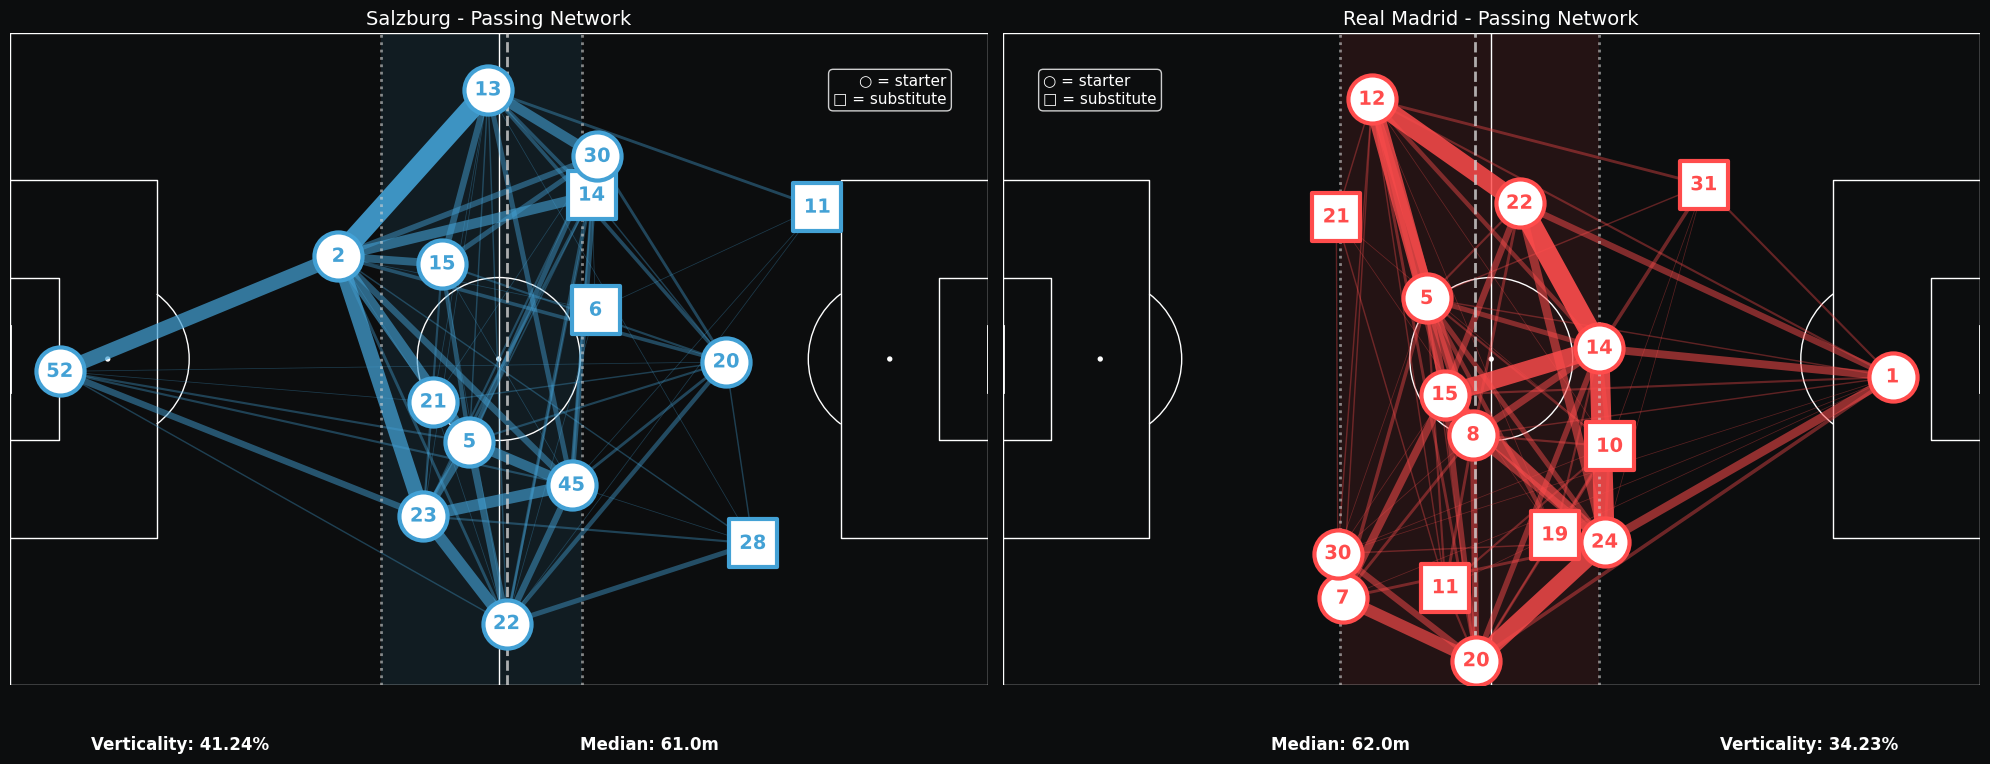

In [13]:
# Enhanced analysis with Athletic-style colors
passes_df = prepare_enhanced_passes(df_events)

# Home team analysis
home_avg_locs = get_enhanced_positions(passes_df, home_team['team_id'], 
                                      home_team['players'], matchdict_data['playerIdNameDictionary'])
home_combinations = get_pass_combinations(passes_df, home_team['team_id'])
home_metrics = calculate_team_metrics(passes_df, home_avg_locs, home_team['team_id'])

# Away team analysis  
away_avg_locs = get_enhanced_positions(passes_df, away_team['team_id'],
                                      away_team['players'], matchdict_data['playerIdNameDictionary'])
away_combinations = get_pass_combinations(passes_df, away_team['team_id'])
away_metrics = calculate_team_metrics(passes_df, away_avg_locs, away_team['team_id'])

# THE ATHLETIC STYLING
background_color = '#0C0D0E'  # The Athletic's dark background
home_color = '#43A1D5'       # Keep your blue but it'll pop on dark background
away_color = '#FF4C4C'       # Keep your red

# Plot with Athletic styling
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.patch.set_facecolor(background_color)  # Dark background for entire figure

plot_enhanced_network(ax1, passes_df, home_avg_locs, home_combinations, home_metrics,
                     home_team['name'], color=home_color, is_home=True, bg_color=background_color)

plot_enhanced_network(ax2, passes_df, away_avg_locs, away_combinations, away_metrics,
                     away_team['name'], color=away_color, is_home=False, bg_color=background_color)

plt.tight_layout()
plt.show()

###### Defensive Actions Map

In [14]:
def filter_defensive_actions(df_events: pd.DataFrame) -> pd.DataFrame:
    """
    Filter events to get only defensive actions using type_display_name.
    
    Args:
        df_events: DataFrame with match events
        
    Returns:
        DataFrame containing only defensive actions
    """
    # Use type_display_name (not type) and include all defensive actions from your data
    defensive_types = [
        'Tackle', 'Interception', 'BallRecovery', 'BlockedPass', 
        'Challenge', 'Clearance', 'Foul', 'Aerial'
    ]
    
    defensive_actions = df_events[
        df_events['type_display_name'].isin(defensive_types)
    ].copy()
    
    # Convert coordinates from WhoScored (0-100) to StatsBomb (0-120x0-80)
    defensive_actions['x_sb'] = defensive_actions['x'] * 1.2
    defensive_actions['y_sb'] = defensive_actions['y'] * 0.8
    
    return defensive_actions

def create_player_info(player: dict) -> dict:
    """Create standardized player info from team data."""
    return {
        'id': player['playerId'],
        'name': player['name'],
        'position': player['position'],
        'shirt_no': player['shirtNo'],
        'is_starter': player.get('isFirstEleven', False)
    }

def calculate_player_defensive_positions(defensive_actions: pd.DataFrame, 
                                       team_id: int, 
                                       team_players: list) -> dict:
    """
    Calculate average defensive positions and action counts for each player.
    """
    # Filter actions for this team
    team_actions = defensive_actions[defensive_actions['team_id'] == team_id]
    
    if len(team_actions) == 0:
        return {}
    
    # Create player info lookup
    player_info = {p['playerId']: create_player_info(p) for p in team_players}
    
    # Calculate player statistics
    player_stats = (
        team_actions.groupby('player_id')
        .agg({
            'x_sb': 'median',  # Use median like inspirational code
            'y_sb': 'median',
            'id': 'count'
        })
        .round(2)
        .rename(columns={'id': 'action_count'})
    )
    
    # Combine with player info
    positions = {}
    for player_id, stats in player_stats.iterrows():
        if player_id in player_info:
            positions[player_id] = {
                'x': stats['x_sb'],
                'y': stats['y_sb'],
                'action_count': stats['action_count'],
                'name': player_info[player_id]['name'],
                'position': player_info[player_id]['position'],
                'shirt_no': player_info[player_id]['shirt_no'],
                'is_starter': player_info[player_id]['is_starter']
            }
    
    return positions

def defensive_block(ax, team_positions: dict, team_actions: pd.DataFrame, 
                   team_name: str, team_color: str, is_away_team: bool = False):
    """
    Create defensive block visualization for one team - 
    """
    # Create pitch - following inspirational code exactly
    pitch = Pitch(
        pitch_type='statsbomb',  # Changed to statsbomb for my data
        pitch_color='#0C0D0E',
        line_color='white',
        linewidth=2,
        line_zorder=2,
        corner_arcs=True
    )
    pitch.draw(ax=ax)
    ax.set_facecolor('#0C0D0E')
    ax.set_xlim(-0.5, 120.5)  # StatsBomb dimensions
    ax.set_ylim(-0.5, 80.5)
    
    if len(team_positions) == 0 or len(team_actions) == 0:
        ax.set_title(f"{team_name}\nDefensive Action Heatmap", 
                    color='white', fontsize=20, fontweight='bold')
        return {}
    
    # Convert positions to DataFrame for easier manipulation
    positions_df = pd.DataFrame.from_dict(team_positions, orient='index')
    
    # Variable marker size based on defensive actions - FAITHFUL TO INSPIRATIONAL
    MAX_MARKER_SIZE = 3500
    positions_df['marker_size'] = (
        positions_df['action_count'] / positions_df['action_count'].max() * MAX_MARKER_SIZE
    )
    
    # Create KDE heatmap - 
    from matplotlib.colors import LinearSegmentedColormap
    from matplotlib.colors import to_rgba
    import numpy as np
    
    color = np.array(to_rgba(team_color))
    flamingo_cmap = LinearSegmentedColormap.from_list(
        "Team colors", ['#0C0D0E', team_color], N=500
    )
    
    # KDE plot 
    kde = pitch.kdeplot(
        team_actions['x_sb'], team_actions['y_sb'], 
        ax=ax, fill=True, levels=5000, thresh=0.02, cut=4, cmap=flamingo_cmap
    )
    
    # Plot player nodes 
    for idx, row in positions_df.iterrows():
        if row['is_starter']:
            marker = 'o'  # Circle for starters
        else:
            marker = 's'  # Square for substitutes
            
        pitch.scatter(
            row['x'], row['y'], 
            s=row['marker_size'] + 100,
            marker=marker, 
            color='#0C0D0E',
            edgecolor='white',
            linewidth=1,
            alpha=1, 
            zorder=3, 
            ax=ax
        )
    
    # Plot tiny scatter for defensive actions
    pitch.scatter(
        team_actions['x_sb'], team_actions['y_sb'],
        s=10, marker='x', color='yellow', alpha=0.2, ax=ax
    )
    
    # Add shirt numbers
    for idx, row in positions_df.iterrows():
        pitch.annotate(
            str(row['shirt_no']), 
            xy=(row['x'], row['y']),
            c='white', ha='center', va='center', size=14, ax=ax
        )
    
    # Calculate metrics
    dah = round(positions_df['x'].mean(), 2)  # Defensive Actions Height
    dah_show = round((dah * 1.05), 2)
    
    # Defense line height (center backs)
    center_backs = positions_df[positions_df['position'] == 'DC']
    if len(center_backs) > 0:
        def_line_h = round(center_backs['x'].median(), 2)
    else:
        def_line_h = dah
    
    # Forward line height (top 2 advanced players)
    starters = positions_df[positions_df['is_starter'] == True]
    if len(starters) >= 2:
        forwards = starters.nlargest(2, 'x')
        fwd_line_h = round(forwards['x'].mean(), 2)
    else:
        fwd_line_h = dah
    
    # Calculate compactness
    compactness = round((1 - ((fwd_line_h - def_line_h) / 120)) * 100, 2)
    
    # Add vertical lines 
    ax.axvline(x=dah, color='gray', linestyle='--', alpha=0.75, linewidth=2)
    ax.axvline(x=def_line_h, color='gray', linestyle='dotted', alpha=0.5, linewidth=2)
    ax.axvline(x=fwd_line_h, color='gray', linestyle='dotted', alpha=0.5, linewidth=2)
    
    # Invert axes for away team 
    if is_away_team:
        ax.invert_xaxis()
        ax.invert_yaxis()
        ax.text(dah-1, 78, f"{dah_show}m", fontsize=15, color='white', ha='left', va='center')
        ax.text(120, 78, f'Compact:{compactness}%', fontsize=15, color='white', ha='left', va='center')
        ax.text(2, 2, "circle = starter\nbox = sub", color='gray', size=12, ha='right', va='top')
    else:
        ax.text(dah-1, -3, f"{dah_show}m", fontsize=15, color='white', ha='right', va='center')
        ax.text(120, -3, f'Compact:{compactness}%', fontsize=15, color='white', ha='right', va='center')
        ax.text(2, 78, "circle = starter\nbox = sub", color='gray', size=12, ha='left', va='top')
    
    # Set title 
    ax.set_title(f"{team_name}\nDefensive Action Heatmap", 
                color='white', fontsize=20, fontweight='bold')
    
    return {
        'Team_Name': team_name,
        'Average_Defensive_Action_Height': dah,
        'Forward_Line_Pressing_Height': fwd_line_h,
        'Compactness': compactness
    }

def create_defensive_heatmap_analysis(df_events: pd.DataFrame, 
                                    home_team: dict, 
                                    away_team: dict) -> tuple:
    """
    Complete defensive heatmap analysis 
    """
    # Filter defensive actions
    defensive_actions = filter_defensive_actions(df_events)
    print(f"Found {len(defensive_actions)} defensive actions")
    
    # Get player positions for both teams
    home_positions = calculate_player_defensive_positions(
        defensive_actions, home_team['team_id'], home_team['players']
    )
    away_positions = calculate_player_defensive_positions(
        defensive_actions, away_team['team_id'], away_team['players']
    )
    
    # Filter team actions
    home_actions = defensive_actions[defensive_actions['team_id'] == home_team['team_id']]
    away_actions = defensive_actions[defensive_actions['team_id'] == away_team['team_id']]
    
    print(f"Home players with defensive actions: {len(home_positions)}")
    print(f"Away players with defensive actions: {len(away_positions)}")
    
    # Create TWO subplots side by side - 
    fig, axs = plt.subplots(1, 2, figsize=(20, 10), facecolor='#0C0D0E')
    
    # Create defensive blocks for each team 
    home_stats = defensive_block(
        axs[0], home_positions, home_actions, 
        home_team['name'], '#43A1D5', is_away_team=False
    )
    
    away_stats = defensive_block(
        axs[1], away_positions, away_actions, 
        away_team['name'], '#FF4C4C', is_away_team=True
    )
    
    # Combine stats
    stats_list = [home_stats, away_stats]
    stats_df = pd.DataFrame(stats_list)
    
    plt.tight_layout()
    return home_stats, away_stats, fig

Found 309 defensive actions
Home players with defensive actions: 14
Away players with defensive actions: 16
Home Team Stats: {'Team_Name': 'Salzburg', 'Average_Defensive_Action_Height': 51.54, 'Forward_Line_Pressing_Height': 76.8, 'Compactness': 49.15}
Away Team Stats: {'Team_Name': 'Real Madrid', 'Average_Defensive_Action_Height': 38.72, 'Forward_Line_Pressing_Height': 69.24, 'Compactness': 71.4}


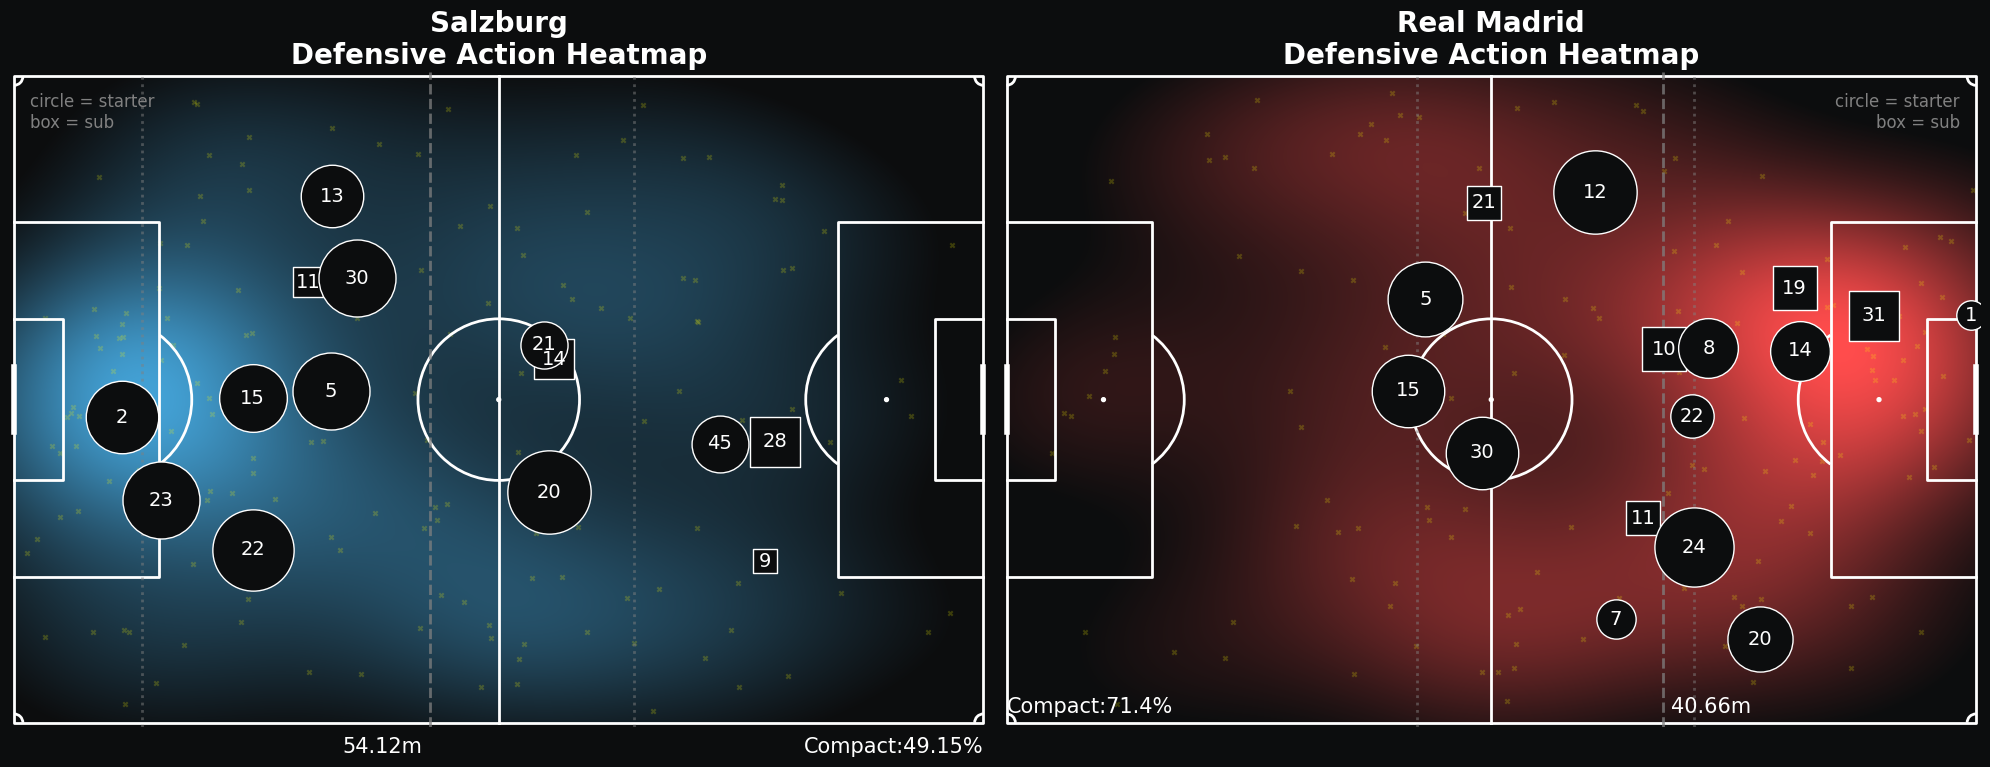

In [15]:
# Run the defensive heatmap analysis
home_stats, away_stats, fig = create_defensive_heatmap_analysis(df_events, home_team, away_team)

# Display the results
print("Home Team Stats:", home_stats)
print("Away Team Stats:", away_stats)
plt.show()

###### Progressive Passes

In [16]:
# Calculating carrying distance, to find out progressive carry
df_events['prog_carry'] = np.where((df_events['type_display_name'] == 'Carry'), 
                            np.sqrt((105 - df_events['x'])**2 + (34 - df_events['y'])**2) - np.sqrt((105 - df_events['end_x'])**2 + (34 - df_events['end_y'])**2), 0)
df_events['pass_or_carry_angle'] = np.degrees(np.arctan2(df_events['end_y'] - df_events['y'], df_events['end_x'] - df_events['x']))

df_events.head()

id  event_id  minute  second  team_id     x     y  \
0  2.824468e+09         2       0     0.0      361   0.0   0.0   
1  2.824468e+09         2       0     0.0       52   0.0   0.0   
2  2.824468e+09         3       0     0.0       52  49.7  50.1   
3  2.824468e+09         4       0     4.0       52  21.5  49.0   
4  2.824468e+09         3       0     8.0      361  29.9  84.5   

   expanded_minute                                    period  \
0                0  {'value': 1, 'displayName': 'FirstHalf'}   
1                0  {'value': 1, 'displayName': 'FirstHalf'}   
2                0  {'value': 1, 'displayName': 'FirstHalf'}   
3                0  {'value': 1, 'displayName': 'FirstHalf'}   
4                0  {'value': 1, 'displayName': 'FirstHalf'}   

                                    type  ... is_shot relatedEventId  \
0  {'value': 32, 'displayName': 'Start'}  ...     NaN            NaN   
1  {'value': 32, 'displayName': 'Start'}  ...     NaN            NaN   
2    {'value': 1, 'displayName': 'Pass'}  ...     NaN            NaN   
3    {'value': 1, 'displayName': 'Pass'}  ...     NaN            NaN   
4    {'value': 1, 'displayName': 'Pass'}  ...     NaN            NaN   

  relatedPlayerId  is_goal                               outcome_type.1  \
0             NaN      NaN    {'value': 1, 'displayName': 'Successful'}   
1             NaN      NaN    {'value': 1, 'displayName': 'Successful'}   
2             NaN      NaN    {'value': 1, 'displayName': 'Successful'}   
3             NaN      NaN  {'value': 0, 'displayName': 'Unsuccessful'}   
4             NaN      NaN    {'value': 1, 'displayName': 'Successful'}   

   type_display_name  outcome_type_display_name  period_display_name  \
0              Start                 Successful            FirstHalf   
1              Start                 Successful            FirstHalf   
2               Pass                 Successful            FirstHalf   
3               Pass               Unsuccessful            FirstHalf   
4               Pass                 Successful            FirstHalf   

   prog_carry  pass_or_carry_angle  
0         0.0                  NaN  
1         0.0                  NaN  
2         0.0           180.000000  
3         0.0           -34.238598  
4         0.0            52.263245  

[5 rows x 31 columns]

In [17]:
# Calculating passing distance, to find out progressive pass
df_events['prog_pass'] = np.where((df_events['type_display_name'] == 'Pass'), 
                           np.sqrt((105 - df_events['x'])**2 + (34 - df_events['y'])**2) - np.sqrt((105 - df_events['end_x'])**2 + (34 - df_events['end_y'])**2), 0)

df_events.head()

id  event_id  minute  second  team_id     x     y  \
0  2.824468e+09         2       0     0.0      361   0.0   0.0   
1  2.824468e+09         2       0     0.0       52   0.0   0.0   
2  2.824468e+09         3       0     0.0       52  49.7  50.1   
3  2.824468e+09         4       0     4.0       52  21.5  49.0   
4  2.824468e+09         3       0     8.0      361  29.9  84.5   

   expanded_minute                                    period  \
0                0  {'value': 1, 'displayName': 'FirstHalf'}   
1                0  {'value': 1, 'displayName': 'FirstHalf'}   
2                0  {'value': 1, 'displayName': 'FirstHalf'}   
3                0  {'value': 1, 'displayName': 'FirstHalf'}   
4                0  {'value': 1, 'displayName': 'FirstHalf'}   

                                    type  ... relatedEventId relatedPlayerId  \
0  {'value': 32, 'displayName': 'Start'}  ...            NaN             NaN   
1  {'value': 32, 'displayName': 'Start'}  ...            NaN             NaN   
2    {'value': 1, 'displayName': 'Pass'}  ...            NaN             NaN   
3    {'value': 1, 'displayName': 'Pass'}  ...            NaN             NaN   
4    {'value': 1, 'displayName': 'Pass'}  ...            NaN             NaN   

  is_goal                               outcome_type.1  type_display_name  \
0     NaN    {'value': 1, 'displayName': 'Successful'}              Start   
1     NaN    {'value': 1, 'displayName': 'Successful'}              Start   
2     NaN    {'value': 1, 'displayName': 'Successful'}               Pass   
3     NaN  {'value': 0, 'displayName': 'Unsuccessful'}               Pass   
4     NaN    {'value': 1, 'displayName': 'Successful'}               Pass   

   outcome_type_display_name  period_display_name  prog_carry  \
0                 Successful            FirstHalf         0.0   
1                 Successful            FirstHalf         0.0   
2                 Successful            FirstHalf         0.0   
3               Unsuccessful            FirstHalf         0.0   
4                 Successful            FirstHalf         0.0   

   pass_or_carry_angle  prog_pass  
0                  NaN   0.000000  
1                  NaN   0.000000  
2           180.000000 -25.086639  
3           -34.238598  45.123637  
4            52.263245  -0.199669  

[5 rows x 32 columns]

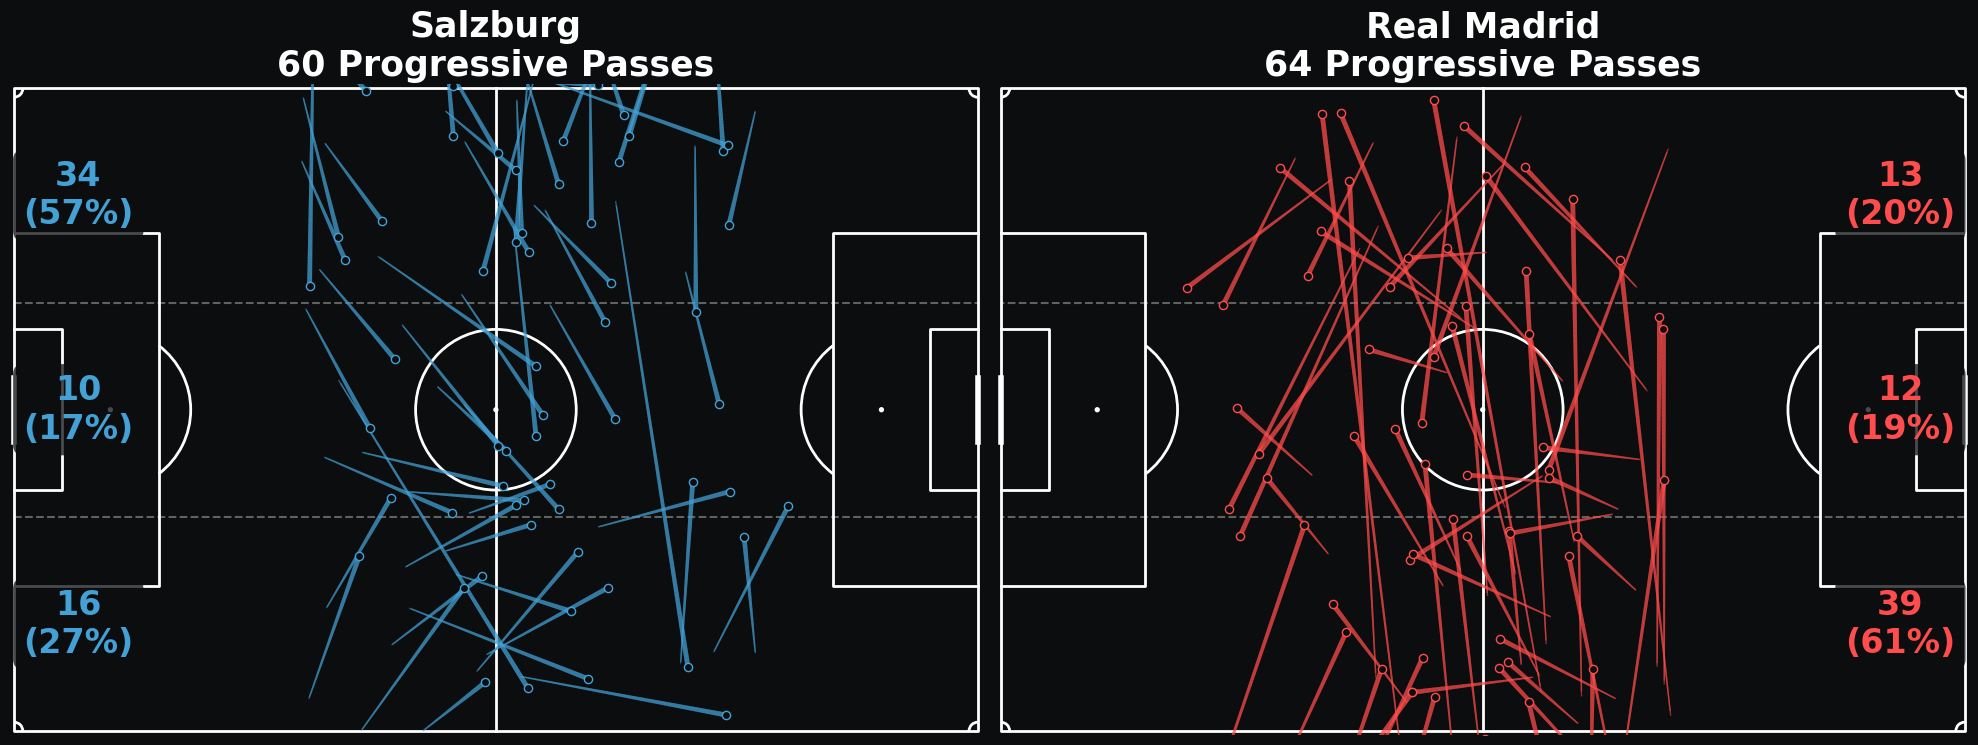


Progressive Passes Statistics:
     Team_Name  Total_Progressive_Passes  Progressive_Passes_From_Left  \
0     Salzburg                        60                            34   
1  Real Madrid                        64                            39   

   Progressive_Passes_From_Center  Progressive_Passes_From_Right  \
0                              10                             16   
1                              12                             13   

   Left_Percentage  Center_Percentage  Right_Percentage  
0               57                 17                27  
1               61                 19                20  


In [18]:
def draw_progressive_pass_map(ax, team_id, team_name, team_color, is_away_team=False):
    """
    Draw progressive pass map with defensive block aesthetic
    """
    # Filter progressive passes using prog_pass calculation
    dfpro = df_events[
        (df_events['team_id'] == team_id) & 
        (df_events['type_display_name'] == 'Pass') &
        (df_events['outcome_type_display_name'] == 'Successful') &
        (~df_events['qualifiers'].astype(str).str.contains('CornerTaken|Freekick', na=False)) & 
        (df_events['x'] >= 35) &
        (df_events['prog_pass'] >= 9.11)  # Using prog_pass calculation
    ].copy()
    
    # Create pitch with defensive block aesthetic
    pitch = Pitch(
        pitch_type='statsbomb',
        pitch_color='#0C0D0E',
        line_color='white',
        linewidth=2,
        line_zorder=2,
        corner_arcs=True
    )
    pitch.draw(ax=ax)
    ax.set_facecolor('#0C0D0E')
    ax.set_xlim(-0.5, 120.5)
    ax.set_ylim(-0.5, 80.5)
    
    # Invert axes for away team
    if is_away_team:
        ax.invert_xaxis()
        ax.invert_yaxis()
    
    pro_count = len(dfpro)
    
    if pro_count > 0:
        # Calculate zone statistics (StatsBomb coordinates: 0-80 width)
        left_pro = len(dfpro[dfpro['y'] >= 53.33])    # Top third (53.33-80)
        mid_pro = len(dfpro[(dfpro['y'] >= 26.67) & (dfpro['y'] < 53.33)])  # Middle third
        right_pro = len(dfpro[dfpro['y'] < 26.67])    # Bottom third (0-26.67)
        
        left_percentage = round((left_pro/pro_count)*100) if pro_count > 0 else 0
        mid_percentage = round((mid_pro/pro_count)*100) if pro_count > 0 else 0
        right_percentage = round((right_pro/pro_count)*100) if pro_count > 0 else 0
        
        # Add zone dividing lines
        ax.hlines(26.67, xmin=0, xmax=120, colors='white', linestyle='dashed', alpha=0.35)
        ax.hlines(53.33, xmin=0, xmax=120, colors='white', linestyle='dashed', alpha=0.35)
        
        # Text styling matching defensive block
        bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="None", facecolor='#0C0D0E', alpha=0.75)
        
        # Position text annotations
        ax.text(8, 13.335, f'{right_pro}\n({right_percentage}%)', color=team_color, fontsize=24, 
               va='center', ha='center', bbox=bbox_props, weight='bold')
        ax.text(8, 40, f'{mid_pro}\n({mid_percentage}%)', color=team_color, fontsize=24, 
               va='center', ha='center', bbox=bbox_props, weight='bold')
        ax.text(8, 66.67, f'{left_pro}\n({left_percentage}%)', color=team_color, fontsize=24, 
               va='center', ha='center', bbox=bbox_props, weight='bold')
        
        # Plot progressive passes with comet effect
        pitch.lines(dfpro['x'], dfpro['y'], dfpro['end_x'], dfpro['end_y'], 
                   lw=3.5, comet=True, color=team_color, ax=ax, alpha=0.5)
        
        # Add end points (matching inspirational code styling)
        pitch.scatter(dfpro['end_x'], dfpro['end_y'], s=35, edgecolor=team_color, 
                     linewidth=1, facecolor='#0C0D0E', zorder=2, ax=ax)
    
    else:
        left_pro = mid_pro = right_pro = 0
        left_percentage = mid_percentage = right_percentage = 0
    
    # Title color matching aesthetic
    counttext = f"{pro_count} Progressive Passes"
    ax.set_title(f"{team_name}\n{counttext}", color='white', fontsize=25, fontweight='bold')
    
    return {
        'Team_Name': team_name,
        'Total_Progressive_Passes': pro_count,
        'Progressive_Passes_From_Left': left_pro,
        'Progressive_Passes_From_Center': mid_pro,
        'Progressive_Passes_From_Right': right_pro,
        'Left_Percentage': left_percentage,
        'Center_Percentage': mid_percentage,
        'Right_Percentage': right_percentage
    }

# Create the visualization
fig, axs = plt.subplots(1, 2, figsize=(20, 10), facecolor='#0C0D0E')

# Get team IDs and names dynamically from matchdict_data
home_team_id = matchdict_data['home']['teamId']
away_team_id = matchdict_data['away']['teamId']
home_team_name = matchdict_data['home']['name']
away_team_name = matchdict_data['away']['name']

# Generate plots
home_stats = draw_progressive_pass_map(axs[0], home_team_id, home_team_name, '#43A1D5', is_away_team=False)
away_stats = draw_progressive_pass_map(axs[1], away_team_id, away_team_name, '#FF4C4C', is_away_team=True)

# Combine stats
progressive_passes_stats = [home_stats, away_stats]
progressive_passes_df = pd.DataFrame(progressive_passes_stats)

plt.tight_layout()
plt.show()

# Display stats
print("\nProgressive Passes Statistics:")
print(progressive_passes_df)

###### Shot Map

In [19]:
# Merge to get qualifiers
df_events_shots = df_events[df_events['is_shot'] == True][['id', 'qualifiers', 'type']]
shots_merged = pd.merge(shots_df, df_events_shots, left_on='id', right_on='id', how='left')

# Print the first few rows of the merged dataframe
print(shots_merged.head())

           id     eventType  teamId  playerId           playerName          x  \
0  2824468943  AttemptSaved    8633   1253890           Arda Güler  86.352941   
1  2824469259          Miss    8633    276738      Antonio Rüdiger  97.859649   
2  2824471477  AttemptSaved    8633    846033      Vinicius Junior  94.192982   
3  2824471647          Miss    8633   1367619         Dean Huijsen  95.736842   
4  2824472203  AttemptSaved    8633    914458  Aurélien Tchouaméni  91.700000   

           y  min  minAdded  isBlocked  ...  isFromInsideBox   keeperId  \
0  28.034762    6       NaN       True  ...            False        NaN   
1  35.677500    8       NaN      False  ...             True        NaN   
2  37.355000   20       NaN      False  ...             True  1572337.0   
3  32.703750   21       NaN      False  ...             True        NaN   
4  31.865000   25       NaN       True  ...             True        NaN   

   firstName    lastName             fullName  teamColor  shor

In [20]:
# Helper functions
def is_big_chance(qualifiers):
    return 'BigChance' in str(qualifiers)

def is_own_goal(qualifiers):
    return 'OwnGoal' in str(qualifiers)

# Add flags
shots_merged['is_big_chance'] = shots_merged['qualifiers'].apply(is_big_chance)
shots_merged['is_own_goal'] = shots_merged['qualifiers'].apply(is_own_goal)

# Team info
home_id, away_id = 10013, 8633
home_name, away_name = "Salzburg", "Real Madrid"
home_color, away_color = "#F13032", "#085098"

# Split by team
home_shots = shots_merged[shots_merged['teamId'] == home_id]
away_shots = shots_merged[shots_merged['teamId'] == away_id]

In [21]:
# Calculate stats
def team_stats(df):
    goals = np.sum((df['eventType'] == 'Goal') & (~df['is_own_goal']))
    xg = np.round(df['expectedGoals'].sum(), 2)
    xgot = np.round(df['expectedGoalsOnTarget'].sum(), 2)
    shots = len(df)
    on_target = np.sum(df['isOnTarget'])
    big_chances = np.sum(df['is_big_chance'])
    big_chance_miss = np.sum((df['is_big_chance']) & (df['eventType'] != 'Goal'))
    xg_per_shot = np.round(xg / shots, 2) if shots > 0 else 0
    avg_dist = np.round(np.sqrt((df['x'] - 105)**2 + (df['y'] - 34)**2).mean(), 2)
    return [goals, xg, xgot, shots, on_target, big_chances, big_chance_miss, xg_per_shot, avg_dist]

home_stats = team_stats(home_shots)
away_stats = team_stats(away_shots)

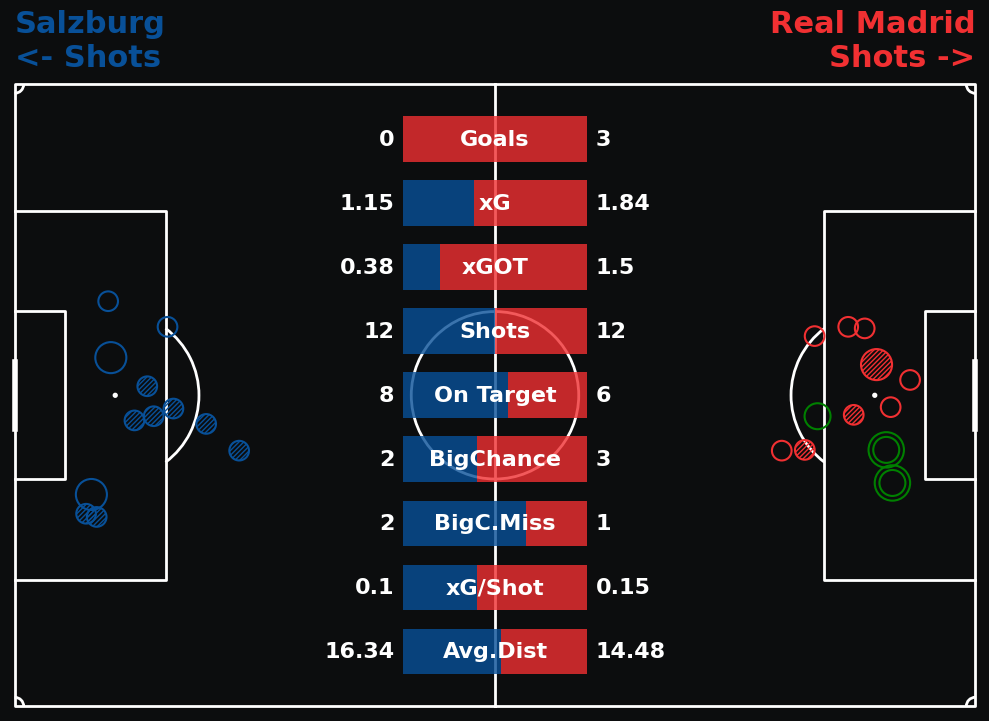

In [22]:
def plot_shot_map_with_stats(shots_merged, home_stats, away_stats, 
                           home_id, away_id, home_name, away_name, 
                           home_color, away_color, bg_color='#0C0D0E'):
    """
    Plot shot map with stats bar using your data structure
    """
    fig, ax = plt.subplots(figsize=(10, 10), facecolor=bg_color)
    pitch = Pitch(pitch_type='uefa', pitch_color=bg_color, line_color='white', linewidth=2, corner_arcs=True)
    pitch.draw(ax=ax)
    ax.set_ylim(-0.5, 68.5)
    ax.set_xlim(-0.5, 105.5)
    
    # Split shots by team
    home_shots = shots_merged[shots_merged['teamId'] == home_id]
    away_shots = shots_merged[shots_merged['teamId'] == away_id]
    
    # Helper function to plot shots with correct positioning
    def plot_shots(df, color, is_home_team=True, marker='o', s=200, edgecolor=None, fill=True, hatch=None, zorder=2):
        if len(df) > 0:
            face_color = color if fill else 'none'
            edge_color = edgecolor if edgecolor else color
            
            # Transform coordinates based on team
            if is_home_team:
                # Home team (left side): flip coordinates
                x_coords = 105 - df['x']
                y_coords = 68 - df['y']
            else:
                # Away team (right side): use original coordinates
                x_coords = df['x']
                y_coords = df['y']
                
            ax.scatter(x_coords, y_coords, s=s, c=face_color, marker=marker, 
                      edgecolors=edge_color, zorder=zorder, hatch=hatch, linewidth=1.5)
    
    # --- HOME TEAM SHOTS (LEFT SIDE) ---
    # Goals (green football marker)
    home_goals = home_shots[(home_shots['eventType'] == 'Goal') & (~home_shots['is_own_goal'])]
    plot_shots(home_goals, 'none', is_home_team=True, marker='o', s=350, edgecolor='green', zorder=3)
    
    # Own goals (orange football marker)
    home_own_goals = home_shots[home_shots['is_own_goal']]
    plot_shots(home_own_goals, 'none', is_home_team=True, marker='o', s=350, edgecolor='orange', zorder=3)
    
    # Regular shots (not big chances)
    home_misses = home_shots[(home_shots['eventType'] == 'Miss') & (~home_shots['is_big_chance'])]
    plot_shots(home_misses, 'none', is_home_team=True, edgecolor=home_color, fill=False)
    
    home_saves = home_shots[(home_shots['eventType'] == 'AttemptSaved') & (~home_shots['is_big_chance'])]
    plot_shots(home_saves, 'none', is_home_team=True, edgecolor=home_color, fill=False, hatch='///////')
    
    home_posts = home_shots[(home_shots['eventType'] == 'Post') & (~home_shots['is_big_chance'])]
    plot_shots(home_posts, home_color, is_home_team=True, edgecolor=home_color)
    
    # Big chances (bigger markers)
    home_big_misses = home_shots[(home_shots['eventType'] == 'Miss') & (home_shots['is_big_chance'])]
    plot_shots(home_big_misses, 'none', is_home_team=True, edgecolor=home_color, fill=False, s=500)
    
    home_big_saves = home_shots[(home_shots['eventType'] == 'AttemptSaved') & (home_shots['is_big_chance'])]
    plot_shots(home_big_saves, 'none', is_home_team=True, edgecolor=home_color, fill=False, hatch='///////', s=500)
    
    home_big_posts = home_shots[(home_shots['eventType'] == 'Post') & (home_shots['is_big_chance'])]
    plot_shots(home_big_posts, home_color, is_home_team=True, edgecolor=home_color, s=500)
    
    home_big_goals = home_shots[(home_shots['eventType'] == 'Goal') & (home_shots['is_big_chance']) & (~home_shots['is_own_goal'])]
    plot_shots(home_big_goals, 'none', is_home_team=True, marker='o', s=650, edgecolor='green', zorder=3)
    
    # --- AWAY TEAM SHOTS (RIGHT SIDE) ---
    # Goals (green football marker)
    away_goals = away_shots[(away_shots['eventType'] == 'Goal') & (~away_shots['is_own_goal'])]
    plot_shots(away_goals, 'none', is_home_team=False, marker='o', s=350, edgecolor='green', zorder=3)
    
    # Own goals (orange football marker)
    away_own_goals = away_shots[away_shots['is_own_goal']]
    plot_shots(away_own_goals, 'none', is_home_team=False, marker='o', s=350, edgecolor='orange', zorder=3)
    
    # Regular shots (not big chances)
    away_misses = away_shots[(away_shots['eventType'] == 'Miss') & (~away_shots['is_big_chance'])]
    plot_shots(away_misses, 'none', is_home_team=False, edgecolor=away_color, fill=False)
    
    away_saves = away_shots[(away_shots['eventType'] == 'AttemptSaved') & (~away_shots['is_big_chance'])]
    plot_shots(away_saves, 'none', is_home_team=False, edgecolor=away_color, fill=False, hatch='///////')
    
    away_posts = away_shots[(away_shots['eventType'] == 'Post') & (~away_shots['is_big_chance'])]
    plot_shots(away_posts, away_color, is_home_team=False, edgecolor=away_color)
    
    # Big chances (bigger markers)
    away_big_misses = away_shots[(away_shots['eventType'] == 'Miss') & (away_shots['is_big_chance'])]
    plot_shots(away_big_misses, 'none', is_home_team=False, edgecolor=away_color, fill=False, s=500)
    
    away_big_saves = away_shots[(away_shots['eventType'] == 'AttemptSaved') & (away_shots['is_big_chance'])]
    plot_shots(away_big_saves, 'none', is_home_team=False, edgecolor=away_color, fill=False, hatch='///////', s=500)
    
    away_big_posts = away_shots[(away_shots['eventType'] == 'Post') & (away_shots['is_big_chance'])]
    plot_shots(away_big_posts, away_color, is_home_team=False, edgecolor=away_color, s=500)
    
    away_big_goals = away_shots[(away_shots['eventType'] == 'Goal') & (away_shots['is_big_chance']) & (~away_shots['is_own_goal'])]
    plot_shots(away_big_goals, 'none', is_home_team=False, marker='o', s=650, edgecolor='green', zorder=3)
    
    # --- STATS BAR ---
    stats_labels = ["Goals", "xG", "xGOT", "Shots", "On Target", "BigChance", "BigC.Miss", "xG/Shot", "Avg.Dist"]
    y_positions = [62 - i * 7 for i in range(len(stats_labels))]
    
    # Normalize stats for bar visualization
    def safe_normalize(home_val, away_val, max_width=20):
        total = home_val + away_val
        if total == 0:
            return max_width / 2, max_width / 2
        home_norm = (home_val / total) * max_width
        away_norm = (away_val / total) * max_width
        return home_norm, away_norm
    
    # Draw bars for each stat
    start_x = 42.5
    for i, (y, label) in enumerate(zip(y_positions, stats_labels)):
        home_norm, away_norm = safe_normalize(home_stats[i], away_stats[i])
        
        # Draw bars
        ax.barh(y, home_norm, height=5, color=home_color, left=start_x, alpha=0.8)
        ax.barh(y, away_norm, height=5, color=away_color, left=start_x + home_norm, alpha=0.8)
        
        # Stat labels (center, WHITE text on colored background)
        ax.text(52.5, y, label, color='white', fontsize=16, ha='center', va='center', fontweight='bold')
        
        # Stat values (home on left, away on right)
        ax.text(41.5, y, str(home_stats[i]), color='white', fontsize=16, ha='right', va='center', fontweight='bold')
        ax.text(63.5, y, str(away_stats[i]), color='white', fontsize=16, ha='left', va='center', fontweight='bold')
    
    # Team names and direction indicators
    ax.text(0, 70, f"{home_name}\n<- Shots", color=home_color, size=22, ha='left', fontweight='bold')
    ax.text(105, 70, f"{away_name}\nShots ->", color=away_color, size=22, ha='right', fontweight='bold')
    
    # Remove axis
    ax.axis('off')
    
    return fig, ax

# Call the function with CORRECTED COLORS (blue for home, red for away)
home_color, away_color = "#085098", "#F13032"  # Blue for Salzburg, Red for Real Madrid

fig, ax = plot_shot_map_with_stats(
    shots_merged, home_stats, away_stats,
    home_id, away_id, home_name, away_name,
    home_color, away_color
)

plt.tight_layout()
plt.show()

###### Match Momentum

In [23]:
from scipy.ndimage import gaussian_filter1d

def plot_xt_momentum(
    df_events: pd.DataFrame,
    xT_grid: np.ndarray,
    team_id_to_name: dict,
    home_team_id: int,
    away_team_id: int,
    window_size: int = 4,
    decay_rate: float = 0.25,
    sigma: float = 1.0,
    home_color: str = '#43A1D5',
    away_color: str = '#FF4C4C',
    bg_color: str = '#0C0D0E',
    line_color: str = 'white',
    figsize: tuple = (12, 6)
):
    """
    Plots match momentum using xT, adapted to your data schema and project style.
    """
    # 1. Scale coordinates if needed (my data is 0-100, grid expects 0-120/0-80)
    df = df_events.copy()
    df['x'] = df['x'] * 1.2
    df['y'] = df['y'] * 0.8
    df['end_x'] = df['end_x'] * 1.2
    df['end_y'] = df['end_y'] * 0.8

    n_rows, n_cols = xT_grid.shape

    # 2. Filter for successful passes and carries
    mask = (
        df['type_display_name'].isin(['Pass', 'Carry']) &
        (df['outcome_type_display_name'] == 'Successful')
    )
    df_xT = df[mask].copy()

    # 3. Bin start/end locations to xT grid
    def get_bin(val, max_val, n_bins):
        val = max(0, min(val, max_val))
        bin_idx = int(val / max_val * n_bins)
        return min(bin_idx, n_bins - 1)

    df_xT['start_x_bin'] = df_xT['x'].apply(lambda x: get_bin(x, 120, n_cols))
    df_xT['start_y_bin'] = df_xT['y'].apply(lambda y: get_bin(y, 80, n_rows))
    df_xT['end_x_bin'] = df_xT['end_x'].apply(lambda x: get_bin(x, 120, n_cols))
    df_xT['end_y_bin'] = df_xT['end_y'].apply(lambda y: get_bin(y, 80, n_rows))

    # 4. Calculate xT for each action
    df_xT['start_zone_value'] = df_xT.apply(lambda row: xT_grid[row['start_y_bin'], row['start_x_bin']], axis=1)
    df_xT['end_zone_value'] = df_xT.apply(lambda row: xT_grid[row['end_y_bin'], row['end_x_bin']], axis=1)
    df_xT['xT'] = df_xT['end_zone_value'] - df_xT['start_zone_value']

    # 5. Clip xT values (e.g., max 0.1)
    df_xT['xT_clipped'] = np.clip(df_xT['xT'], 0, 0.1)

    # 6. Map team_id to team name for grouping
    df_xT['team'] = df_xT['team_id'].map(team_id_to_name)

    # 7. For each team and minute, keep only the max xT (clipped)
    max_xT_per_minute = df_xT.groupby(['team', 'minute'])['xT_clipped'].max().reset_index()

    # 8. Calculate weighted sum of xT in rolling window for each minute/team
    minutes = sorted(max_xT_per_minute['minute'].unique())
    teams = [team_id_to_name[home_team_id], team_id_to_name[away_team_id]]
    weighted_xT_sum = {team: [] for team in teams}
    momentum = []

    for current_minute in minutes:
        for team in teams:
            recent_xT = max_xT_per_minute[
                (max_xT_per_minute['team'] == team) &
                (max_xT_per_minute['minute'] <= current_minute) &
                (max_xT_per_minute['minute'] > current_minute - window_size)
            ]
            weights = np.exp(-decay_rate * (current_minute - recent_xT['minute'].values))
            weighted_sum = np.sum(weights * recent_xT['xT_clipped'].values)
            weighted_xT_sum[team].append(weighted_sum)
        # Home minus away for momentum
        momentum.append(weighted_xT_sum[teams[0]][-1] - weighted_xT_sum[teams[1]][-1])

    momentum_df = pd.DataFrame({
        'minute': minutes,
        'momentum': momentum
    })

    # 9. Plotting
    fig, ax = plt.subplots(figsize=figsize)
    fig.set_facecolor(bg_color)
    ax.set_facecolor(bg_color)

    # Smoothing
    momentum_df['smoothed_momentum'] = gaussian_filter1d(momentum_df['momentum'], sigma=sigma)
    ax.plot(momentum_df['minute'], momentum_df['smoothed_momentum'], color=line_color, linewidth=2)

    ax.axhline(0, color=line_color, linestyle='--', linewidth=1, alpha=0.7)
    ax.fill_between(momentum_df['minute'], momentum_df['smoothed_momentum'], where=(momentum_df['smoothed_momentum'] > 0), color=home_color, alpha=0.5, interpolate=True)
    ax.fill_between(momentum_df['minute'], momentum_df['smoothed_momentum'], where=(momentum_df['smoothed_momentum'] < 0), color=away_color, alpha=0.5, interpolate=True)

    # Team names and score
    ax.text(2, 0.07, team_id_to_name[home_team_id], fontsize=16, ha='left', va='center', color=home_color, fontweight='bold')
    ax.text(2, -0.07, team_id_to_name[away_team_id], fontsize=16, ha='left', va='center', color=away_color, fontweight='bold')

    # Mark goals
    for team_id, y in [(home_team_id, 0.06), (away_team_id, -0.06)]:
        goals = df_events[
            (df_events['team_id'] == team_id) &
            (df_events['type_display_name'] == 'Goal')
        ]['minute']
        for minute in goals:
            ax.axvline(minute, color=line_color, linestyle=':', linewidth=1, alpha=0.5)
            ax.scatter(minute, y, color=line_color, s=80, zorder=10, alpha=0.8)
            ax.text(minute+0.2, y+0.01*(1 if y>0 else -1), 'Goal', fontsize=10, ha='left', va='center', color=line_color)

    # Aesthetics
    ax.set_xlabel('Minute', color=line_color, fontsize=15, fontweight='bold')
    ax.set_ylabel('Momentum', color=line_color, fontsize=15, fontweight='bold')
    ax.set_xticks([0,15,30,45,60,75,90])
    ax.tick_params(axis='x', colors=line_color)
    ax.tick_params(axis='y', left=False, right=False, labelleft=False)
    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)
    ax.margins(x=0)
    ax.set_ylim(-0.08, 0.08)
    ax.set_title('xT Momentum', color=line_color, fontsize=20, fontweight='bold', pad=-5)
    plt.tight_layout()
    return fig

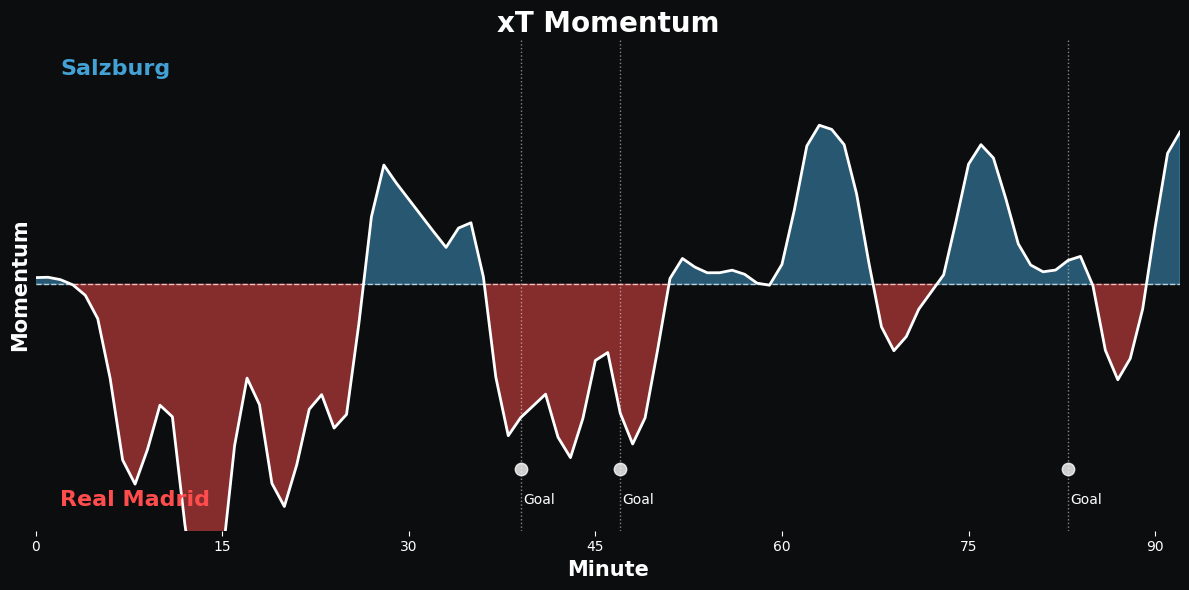

In [24]:
team_id_to_name = {361: "Salzburg", 52: "Real Madrid"}
fig = plot_xt_momentum(df_events, xT_grid, team_id_to_name, 361, 52)
plt.show()

###### Match Stats

In [25]:
def calculate_match_stats(df, hteam_id, ateam_id):
    """
    Calculate match statistics from event data.
    
    Args:
        df: DataFrame containing match events
        hteam_id: Home team ID
        ateam_id: Away team ID
        
    Returns:
        Dictionary containing calculated statistics
    """
    stats = {}
    
    # Helper function to extract qualifiers
    def has_qualifier(event, qualifier_name):
        qualifiers = event.get('qualifiers', [])
        return any(
            q.get('type', {}).get('displayName') == qualifier_name 
            for q in qualifiers if isinstance(q, dict)
        )
    
    # Possession
    home_passes = df[(df['team_id'] == hteam_id) & (df['type_display_name'] == 'Pass')]
    away_passes = df[(df['team_id'] == ateam_id) & (df['type_display_name'] == 'Pass')]
    total_passes = len(home_passes) + len(away_passes)
    stats['Possession'] = {
        'home': round((len(home_passes) / total_passes) * 100, 2) if total_passes else 0,
        'away': round((len(away_passes) / total_passes) * 100, 2) if total_passes else 0
    }
    
    # Field Tilt
    home_touches = df[(df['team_id'] == hteam_id) & (df['is_touch'] == True) & (df['x'] >= 70)]
    away_touches = df[(df['team_id'] == ateam_id) & (df['is_touch'] == True) & (df['x'] >= 70)]
    total_touches = len(home_touches) + len(away_touches)
    stats['Field Tilt'] = {
        'home': round((len(home_touches) / total_touches) * 100, 2) if total_touches else 0,
        'away': round((len(away_touches) / total_touches) * 100, 2) if total_touches else 0
    }
    
    # Passes (Acc.)
    stats['Passes (Acc.)'] = {
        'home': len(home_passes[home_passes['outcome_type_display_name'] == 'Successful']),
        'away': len(away_passes[away_passes['outcome_type_display_name'] == 'Successful'])
    }
    
    # LongBalls (Acc.)
    stats['LongBalls (Acc.)'] = {
        'home': len([e for _, e in home_passes.iterrows() 
                    if e['outcome_type_display_name'] == 'Successful' and has_qualifier(e, 'Longball')]),
        'away': len([e for _, e in away_passes.iterrows() 
                    if e['outcome_type_display_name'] == 'Successful' and has_qualifier(e, 'Longball')])
    }
    
    # Tackles (Wins)
    stats['Tackles (Wins)'] = {
        'home': len(df[(df['team_id'] == hteam_id) & 
                      (df['type_display_name'] == 'Tackle') & 
                      (df['outcome_type_display_name'] == 'Successful')]),
        'away': len(df[(df['team_id'] == ateam_id) & 
                      (df['type_display_name'] == 'Tackle') & 
                      (df['outcome_type_display_name'] == 'Successful')])
    }
    
    # Interceptions
    stats['Interceptions'] = {
        'home': len(df[(df['team_id'] == hteam_id) & (df['type_display_name'] == 'Interception')]),
        'away': len(df[(df['team_id'] == ateam_id) & (df['type_display_name'] == 'Interception')])
    }
    
    # Clearances
    stats['Clearance'] = {
        'home': len(df[(df['team_id'] == hteam_id) & (df['type_display_name'] == 'Clearance')]),
        'away': len(df[(df['team_id'] == ateam_id) & (df['type_display_name'] == 'Clearance')])
    }
    
    # Aerials (Wins)
    stats['Aerials (Wins)'] = {
        'home': len(df[(df['team_id'] == hteam_id) & 
                      (df['type_display_name'] == 'Aerial') & 
                      (df['outcome_type_display_name'] == 'Successful')]),
        'away': len(df[(df['team_id'] == ateam_id) & 
                      (df['type_display_name'] == 'Aerial') & 
                      (df['outcome_type_display_name'] == 'Successful')])
    }
    
    # PPDA
    home_def_actions = df[(df['team_id'] == hteam_id) & 
                        (df['type_display_name'].isin(['Interception', 'Tackle', 'Foul', 'Challenge'])) &
                        (df['x'] > 35)]
    
    away_def_actions = df[(df['team_id'] == ateam_id) & 
                        (df['type_display_name'].isin(['Interception', 'Tackle', 'Foul', 'Challenge'])) &
                        (df['x'] > 35)]
    
    home_passes_ppda = df[(df['team_id'] == hteam_id) & 
                        (df['type_display_name'] == 'Pass') & 
                        (df['outcome_type_display_name'] == 'Successful') &
                        (df['x'] < 70)]
    
    away_passes_ppda = df[(df['team_id'] == ateam_id) & 
                        (df['type_display_name'] == 'Pass') & 
                        (df['outcome_type_display_name'] == 'Successful') &
                        (df['x'] < 70)]
    
    stats['PPDA'] = {
        'home': round(len(away_passes_ppda) / len(home_def_actions), 2) if len(home_def_actions) > 0 else 0,
        'away': round(len(home_passes_ppda) / len(away_def_actions), 2) if len(away_def_actions) > 0 else 0
    }
    
    return stats

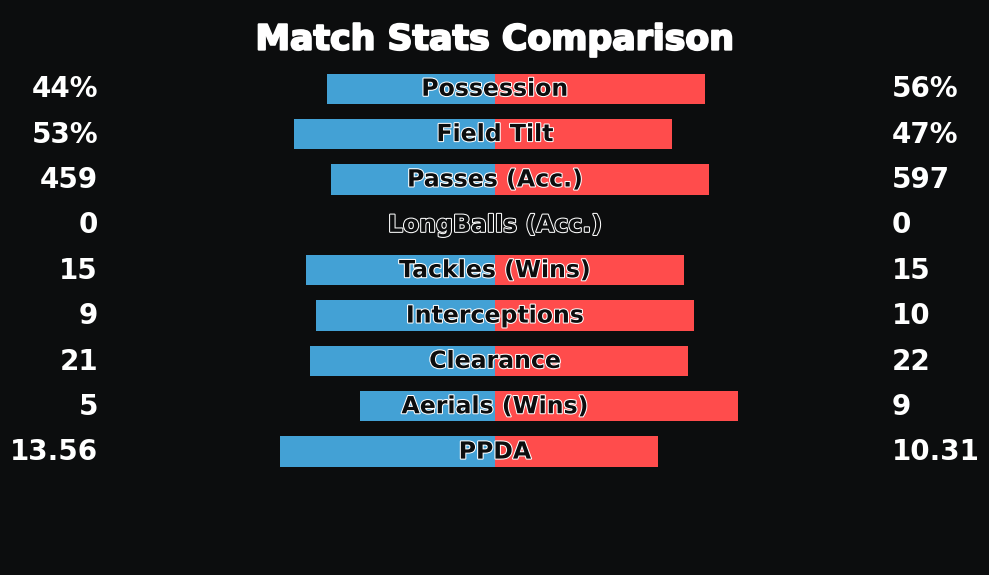

In [26]:
def plot_match_stats_styled(stats, home_team_name="Home", away_team_name="Away"):
    """
    Plot match statistics with your signature dark aesthetic style
    """
    # Signature colors
    bg_color = '#0C0D0E'  # Dark background
    line_color = 'white'  # White text/lines
    col1 = '#43A1D5'      # Home team blue
    col2 = '#FF4C4C'      # Away team red
    
    # Extract data from stats dictionary
    stat_names = list(stats.keys())
    home_values = [stats[stat]['home'] for stat in stat_names]
    away_values = [stats[stat]['away'] for stat in stat_names]
    
    # Calculate normalized values for bars
    normalized_home = []
    normalized_away = []
    
    for i, stat in enumerate(stat_names):
        home_val = home_values[i]
        away_val = away_values[i]
        total = home_val + away_val
        
        if total > 0:
            home_norm = -(home_val / total) * 50  # Negative for left side
            away_norm = (away_val / total) * 50   # Positive for right side
        else:
            home_norm = away_norm = 0
            
        normalized_home.append(home_norm)
        normalized_away.append(away_norm)
    
    # Create figure 
    fig, ax = plt.subplots(figsize=(10, 10), facecolor=bg_color)
    
    # Draw pitch background 
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=bg_color, 
                  line_color=bg_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    ax.set_ylim(-5, 68.5)
    
    # Header box
    #head_y = [62, 68, 68, 62]
    #head_x = [0, 0, 105, 105]
    #ax.fill(head_x, head_y, 'orange')
    
    # Path effects for text
    path_eff = [path_effects.Stroke(linewidth=1.5, foreground=line_color), 
                path_effects.Normal()]
    path_eff1 = [path_effects.Stroke(linewidth=1.5, foreground=line_color), 
                 path_effects.Normal()]
    
    ax.text(52.5, 64.5, "Match Stats Comparison", ha='center', va='center', 
            color=line_color, fontsize=25, fontweight='bold', path_effects=path_eff)
    
    # Y positions for stats 
    stats_y_positions = [58 - (i * 6) for i in range(len(stat_names))]
    
    # Draw bars
    start_x = 52.5
    ax.barh(stats_y_positions, normalized_home, height=4, color=col1, left=start_x)
    ax.barh(stats_y_positions, normalized_away, height=4, left=start_x, color=col2)
    
    # Clean up axis (remove all axis elements)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='both', which='both', bottom=False, top=False, 
                   left=False, right=False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Add stat labels in center
    for i, (stat_name, y_pos) in enumerate(zip(stat_names, stats_y_positions)):
        ax.text(52.5, y_pos, stat_name, color=bg_color, fontsize=17, 
                ha='center', va='center', fontweight='bold', path_effects=path_eff1)
    
    # Add values on left (home) and right (away)
    for i, (home_val, away_val, y_pos) in enumerate(zip(home_values, away_values, stats_y_positions)):
        # Format values based on stat type
        if 'Possession' in stat_names[i] or 'Field Tilt' in stat_names[i]:
            home_text = f"{round(home_val)}%"
            away_text = f"{round(away_val)}%"
        elif 'Passes' in stat_names[i] or 'LongBalls' in stat_names[i] or 'Tackles' in stat_names[i] or 'Aerials' in stat_names[i]:
            # Assuming format like "total(successful)" - you may need to adjust this
            home_text = f"{home_val}"
            away_text = f"{away_val}"
        else:
            home_text = f"{home_val}"
            away_text = f"{away_val}"
            
        # Home team values (left side)
        ax.text(0, y_pos, home_text, color=line_color, fontsize=20, 
                ha='right', va='center', fontweight='bold')
        # Away team values (right side)
        ax.text(105, y_pos, away_text, color=line_color, fontsize=20, 
                ha='left', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Usage with existing code (hardcoded team IDs)
home_team_id = 361
away_team_id = 52 

stats = calculate_match_stats(df_events, home_team_id, away_team_id)
plot_match_stats_styled(stats, "Home Team", "Away Team")

## Match Dashboard

Had to replot some of the functions by making them "subplot" friendly in order to include them on the final dashboard, since some of them were stand alone plots (shots map, match momentum plot, stats table).

I wanted to leave 

#### Experiment 1

=== DATA STANDARDIZATION CHECK ===
shots_merged columns: ['id', 'eventType', 'teamId', 'playerId', 'playerName', 'x', 'y', 'min', 'minAdded', 'isBlocked', 'isOnTarget', 'blockedX', 'blockedY', 'goalCrossedY', 'goalCrossedZ', 'expectedGoals', 'expectedGoalsOnTarget', 'shotType', 'situation', 'period', 'isOwnGoal', 'onGoalShot', 'isSavedOffLine', 'isFromInsideBox', 'keeperId', 'firstName', 'lastName', 'fullName', 'teamColor', 'shortName', 'matchId', 'qualifiers', 'type', 'is_big_chance', 'is_own_goal']
✅ Renamed 'teamId' to 'team_id' in shots_merged
home_team keys: ['name', 'team_id', 'players']
away_team keys: ['name', 'team_id', 'players']
✅ Team IDs extracted: Home=361, Away=52
=== STANDARDIZATION COMPLETE ===

Found 309 defensive actions
Defensive data prepared: Home positions=14, Home actions=158
                         Away positions=16, Away actions=151


TypeError: list indices must be integers or slices, not str

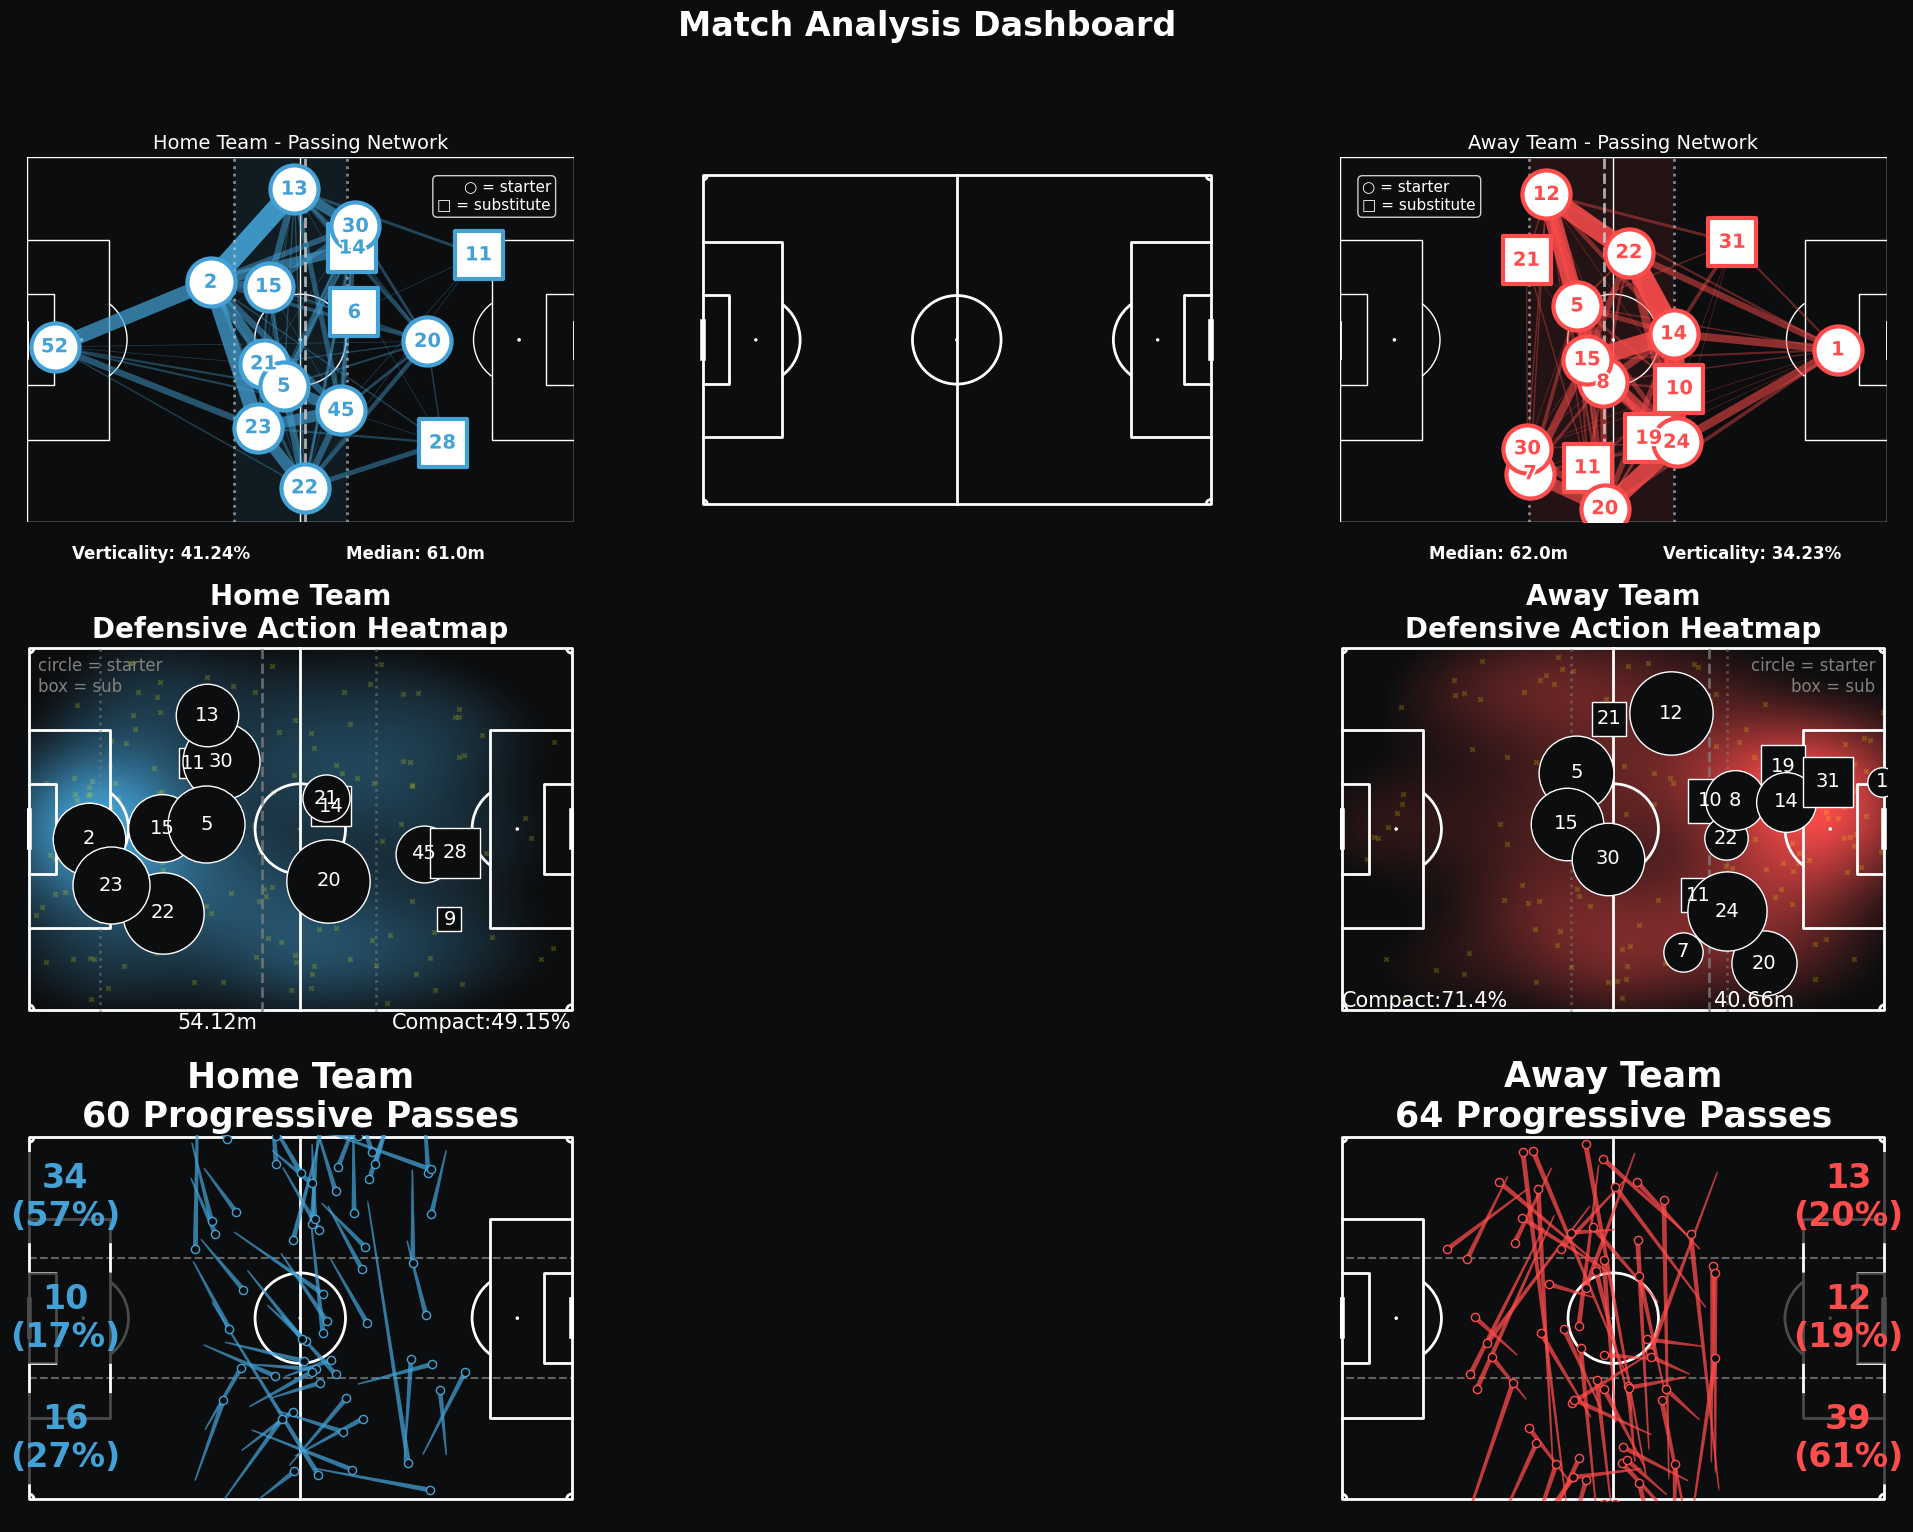

In [28]:
# ==================== DATA STANDARDIZATION SECTION ====================
# Insert this BEFORE "CREAR DASHBOARD CORREGIDO HARDCODEADO" section

print("=== DATA STANDARDIZATION CHECK ===")

# 1. Check shots_merged columns
print(f"shots_merged columns: {list(shots_merged.columns)}")

# 2. Standardize shots_merged naming (if needed)
if 'teamId' in shots_merged.columns and 'team_id' not in shots_merged.columns:
    shots_merged = shots_merged.rename(columns={'teamId': 'team_id'})
    print("✅ Renamed 'teamId' to 'team_id' in shots_merged")

# 3. Check team dictionaries structure  
print(f"home_team keys: {list(home_team.keys())}")
print(f"away_team keys: {list(away_team.keys())}")

# 4. Extract team IDs consistently
if 'teamId' in home_team:
    home_team_id = home_team['teamId']
    away_team_id = away_team['teamId']
elif 'team_id' in home_team:
    home_team_id = home_team['team_id'] 
    away_team_id = away_team['team_id']
else:
    # Fallback to hardcoded
    home_team_id = 361
    away_team_id = 52
    print("⚠️ Using hardcoded team IDs as fallback")

print(f"✅ Team IDs extracted: Home={home_team_id}, Away={away_team_id}")
print("=== STANDARDIZATION COMPLETE ===\n")
# ==================== VERSIONES SUBPLOT-FRIENDLY CORREGIDAS ====================

def plot_shot_map_subplot(ax, shots_merged, home_stats, away_stats, home_team_id, away_team_id, home_team_name, away_team_name):
    """Shot map adaptado para subplot"""
    pitch = Pitch(pitch_type='uefa', pitch_color='#0C0D0E', line_color='white', linewidth=2, corner_arcs=True)
    pitch.draw(ax=ax)
    
    # Home shots
    home_shots = shots_merged[shots_merged['team_id'] == home_team_id]
    away_shots = shots_merged[shots_merged['team_id'] == away_team_id]
    
    # Plot shots
    for _, shot in home_shots.iterrows():
        color = '#00FF41' if shot['outcome_type_display_name'] == 'Goal' else '#43A1D5'
        size = shot['xG'] * 1000 + 50
        ax.scatter(shot['x'] * 1.2, shot['y'] * 0.8, s=size, color=color, alpha=0.7, 
                  edgecolors='white', linewidth=1.5, zorder=3)
    
    for _, shot in away_shots.iterrows():
        x_coord = 120 - (shot['x'] * 1.2)
        y_coord = 80 - (shot['y'] * 0.8)
        color = '#00FF41' if shot['outcome_type_display_name'] == 'Goal' else '#FF4C4C'
        size = shot['xG'] * 1000 + 50
        ax.scatter(x_coord, y_coord, s=size, color=color, alpha=0.7, 
                  edgecolors='white', linewidth=1.5, zorder=3)
    
    # Stats text
    home_goals = home_stats['Goals']
    away_goals = away_stats['Goals']
    home_xg = home_stats['xG']
    away_xg = away_stats['xG']
    
    ax.text(30, 85, f"{home_team_name}\nGoals: {home_goals}\nxG: {home_xg:.2f}", 
            fontsize=12, color='white', weight='bold', ha='center',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='#43A1D5', alpha=0.8))
    
    ax.text(90, 85, f"{away_team_name}\nGoals: {away_goals}\nxG: {away_xg:.2f}", 
            fontsize=12, color='white', weight='bold', ha='center',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='#FF4C4C', alpha=0.8))
    
    ax.set_title('Shot Map & xG', fontsize=16, color='white', weight='bold', pad=20)

def plot_xt_momentum_subplot(ax, df_events, xT_grid, team_id_to_name, home_team_id, away_team_id):
    """xT Momentum adaptado para subplot"""
    ax.set_facecolor('#0C0D0E')
    
    try:
        # Lógica del cálculo de momentum (copiada de tu función)
        df = df_events.copy()
        df['x'] = df['x'] * 1.2
        df['y'] = df['y'] * 0.8
        df['end_x'] = df['end_x'] * 1.2
        df['end_y'] = df['end_y'] * 0.8

        n_rows, n_cols = xT_grid.shape
        
        # Filter for successful passes and carries
        mask = (
            df['type_display_name'].isin(['Pass', 'Carry']) &
            (df['outcome_type_display_name'] == 'Successful')
        )
        df_xT = df[mask].copy()

        if len(df_xT) == 0:
            ax.text(0.5, 0.5, 'No xT data available', transform=ax.transAxes, 
                   ha='center', va='center', color='white', fontsize=14)
            return

        # Bin locations
        def get_bin(val, max_val, n_bins):
            val = max(0, min(val, max_val))
            bin_idx = int(val / max_val * n_bins)
            return min(bin_idx, n_bins - 1)

        df_xT['start_x_bin'] = df_xT['x'].apply(lambda x: get_bin(x, 120, n_cols))
        df_xT['start_y_bin'] = df_xT['y'].apply(lambda y: get_bin(y, 80, n_rows))
        df_xT['end_x_bin'] = df_xT['end_x'].apply(lambda x: get_bin(x, 120, n_cols))
        df_xT['end_y_bin'] = df_xT['end_y'].apply(lambda y: get_bin(y, 80, n_rows))

        # Calculate xT
        df_xT['start_zone_value'] = df_xT.apply(lambda row: xT_grid[row['start_y_bin'], row['start_x_bin']], axis=1)
        df_xT['end_zone_value'] = df_xT.apply(lambda row: xT_grid[row['end_y_bin'], row['end_x_bin']], axis=1)
        df_xT['xT'] = df_xT['end_zone_value'] - df_xT['start_zone_value']
        df_xT['xT_clipped'] = np.clip(df_xT['xT'], 0, 0.1)
        df_xT['team'] = df_xT['team_id'].map(team_id_to_name)

        # Calculate momentum per minute
        max_xT_per_minute = df_xT.groupby(['team', 'minute'])['xT_clipped'].max().reset_index()
        minutes = sorted(max_xT_per_minute['minute'].unique())
        teams = [team_id_to_name[home_team_id], team_id_to_name[away_team_id]]
        
        if len(minutes) == 0:
            ax.text(0.5, 0.5, 'No momentum data', transform=ax.transAxes, 
                   ha='center', va='center', color='white', fontsize=14)
            return
        
        window_size = 4
        decay_rate = 0.25
        weighted_xT_sum = {team: [] for team in teams}
        momentum = []

        for current_minute in minutes:
            for team in teams:
                recent_xT = max_xT_per_minute[
                    (max_xT_per_minute['team'] == team) &
                    (max_xT_per_minute['minute'] <= current_minute) &
                    (max_xT_per_minute['minute'] > current_minute - window_size)
                ]
                weights = np.exp(-decay_rate * (current_minute - recent_xT['minute'].values))
                weighted_sum = np.sum(weights * recent_xT['xT_clipped'].values)
                weighted_xT_sum[team].append(weighted_sum)
            momentum.append(weighted_xT_sum[teams[0]][-1] - weighted_xT_sum[teams[1]][-1])

        # Smoothing y plotting
        momentum_smoothed = gaussian_filter1d(momentum, sigma=1.0)
        
        ax.plot(minutes, momentum_smoothed, color='white', linewidth=2)
        ax.axhline(0, color='white', linestyle='--', linewidth=1, alpha=0.7)
        ax.fill_between(minutes, momentum_smoothed, where=(np.array(momentum_smoothed) > 0), 
                       color='#43A1D5', alpha=0.5, interpolate=True)
        ax.fill_between(minutes, momentum_smoothed, where=(np.array(momentum_smoothed) < 0), 
                       color='#FF4C4C', alpha=0.5, interpolate=True)
        
        # Team names
        ax.text(2, 0.06, team_id_to_name[home_team_id], fontsize=12, ha='left', va='center', 
                color='#43A1D5', fontweight='bold')
        ax.text(2, -0.06, team_id_to_name[away_team_id], fontsize=12, ha='left', va='center', 
                color='#FF4C4C', fontweight='bold')
        
        # Styling
        ax.set_xlabel('Minute', color='white', fontsize=10, fontweight='bold')
        ax.set_title('xT Momentum', color='white', fontsize=12, fontweight='bold')
        ax.tick_params(colors='white')
        for spine in ax.spines.values():
            spine.set_color('white')
            
    except Exception as e:
        ax.text(0.5, 0.5, f'Error: {str(e)}', transform=ax.transAxes, 
               ha='center', va='center', color='white', fontsize=10)

def plot_match_stats_subplot(ax, stats, home_team_name, away_team_name):
    """Match stats adaptado para subplot"""
    ax.set_facecolor('#0C0D0E')
    ax.axis('off')
    
    # Stats principales - usando keys que sabemos que existen
    try:
        stat_keys = list(stats.keys())
        if len(stat_keys) == 0:
            ax.text(0.5, 0.5, 'No stats available', transform=ax.transAxes, 
                   ha='center', va='center', color='white', fontsize=14)
            return
            
        # Tomar primeros 5 stats
        categories = stat_keys[:5]
        y_positions = np.linspace(0.8, 0.2, len(categories))
        
        for i, category in enumerate(categories):
            stat_data = stats[category]
            home_val = stat_data.get('home', 0) if isinstance(stat_data, dict) else 0
            away_val = stat_data.get('away', 0) if isinstance(stat_data, dict) else 0
            
            # Normalizar valores para barras
            total = home_val + away_val
            if total > 0:
                home_width = (home_val / total) * 0.35
                away_width = (away_val / total) * 0.35
            else:
                home_width = away_width = 0.1
            
            # Home bar (izquierda)
            ax.barh(y_positions[i], home_width, left=0.5-home_width, height=0.05, 
                    color='#43A1D5', alpha=0.8)
            # Away bar (derecha)  
            ax.barh(y_positions[i], away_width, left=0.5, height=0.05, 
                    color='#FF4C4C', alpha=0.8)
            
            # Textos
            ax.text(0.25, y_positions[i], f'{home_val}', ha='center', va='center', 
                    color='white', fontsize=10, weight='bold')
            ax.text(0.75, y_positions[i], f'{away_val}', ha='center', va='center', 
                    color='white', fontsize=10, weight='bold')
            ax.text(0.5, y_positions[i], category, ha='center', va='center', 
                    color='white', fontsize=8, weight='bold')
        
        # Títulos de equipos
        ax.text(0.25, 0.95, home_team_name, ha='center', va='center', 
                color='#43A1D5', fontsize=12, weight='bold')
        ax.text(0.75, 0.95, away_team_name, ha='center', va='center', 
                color='#FF4C4C', fontsize=12, weight='bold')
        
    except Exception as e:
        ax.text(0.5, 0.5, f'Stats error: {str(e)}', transform=ax.transAxes, 
               ha='center', va='center', color='white', fontsize=10)
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

# ==================== PREPARAR DATOS DEFENSIVOS HARDCODEADO ====================

try:
    # Filtrar acciones defensivas
    defensive_actions = filter_defensive_actions(df_events)
    print(f"Found {len(defensive_actions)} defensive actions")

    # Calcular posiciones defensivas para cada equipo - HARDCODEADO
    home_positions = calculate_player_defensive_positions(
        defensive_actions, 361, home_team['players']  # HARDCODEADO: 361
    )
    away_positions = calculate_player_defensive_positions(
        defensive_actions, 52, away_team['players']   # HARDCODEADO: 52
    )

    # Filtrar acciones por equipo - HARDCODEADO
    home_actions = defensive_actions[defensive_actions['team_id'] == 361]  # HARDCODEADO: 361
    away_actions = defensive_actions[defensive_actions['team_id'] == 52]   # HARDCODEADO: 52

    print(f"Defensive data prepared: Home positions={len(home_positions)}, Home actions={len(home_actions)}")
    print(f"                         Away positions={len(away_positions)}, Away actions={len(away_actions)}")

except Exception as e:
    print(f"Error preparing defensive data: {e}")
    home_positions = {}
    away_positions = {}
    home_actions = pd.DataFrame()
    away_actions = pd.DataFrame()

# ==================== CREAR DASHBOARD CORREGIDO HARDCODEADO ====================

# Setup del dashboard
fig, axs = plt.subplots(3, 3, figsize=(24, 18), facecolor='#0C0D0E')
fig.suptitle('Match Analysis Dashboard', fontsize=24, color='white', weight='bold', y=0.95)

# Eliminar ejes centrales (columna del medio)
axs[0,1].axis('off')
axs[1,1].axis('off') 
axs[2,1].axis('off')

# FILA 1: Passing Networks - HARDCODEADO
plot_enhanced_network(axs[0,0], passes_df, home_avg_locs, home_combinations, home_metrics,
                     "Home Team", color='#43A1D5', is_home=True, bg_color='#0C0D0E')  # HARDCODEADO: "Home Team"

plot_enhanced_network(axs[0,2], passes_df, away_avg_locs, away_combinations, away_metrics,
                     "Away Team", color='#FF4C4C', is_home=False, bg_color='#0C0D0E')  # HARDCODEADO: "Away Team"

# FILA 2: Defensive Actions - HARDCODEADO
defensive_block(axs[1,0], home_positions, home_actions, 
               "Home Team", '#43A1D5', is_away_team=False)  # HARDCODEADO: "Home Team"
defensive_block(axs[1,2], away_positions, away_actions, 
               "Away Team", '#FF4C4C', is_away_team=True)   # HARDCODEADO: "Away Team"

# FILA 3: Progressive Passes - HARDCODEADO
draw_progressive_pass_map(axs[2,0], 361, "Home Team", '#43A1D5', is_away_team=False)  # HARDCODEADO: 361, "Home Team"
draw_progressive_pass_map(axs[2,2], 52, "Away Team", '#FF4C4C', is_away_team=True)   # HARDCODEADO: 52, "Away Team"

# COLUMNA CENTRAL: Shot Map, Momentum, Match Stats - HARDCODEADO
plot_shot_map_subplot(axs[0,1], shots_merged, home_stats, away_stats, 
                     361, 52,                                    # HARDCODEADO: 361, 52
                     "Home Team", "Away Team")                   # HARDCODEADO: "Home Team", "Away Team"

plot_xt_momentum_subplot(axs[1,1], df_events, xT_grid, team_id_to_name, 
                        361, 52)                                 # HARDCODEADO: 361, 52

plot_match_stats_subplot(axs[2,1], stats, "Home Team", "Away Team")  # HARDCODEADO: "Home Team", "Away Team"

# Ajustar spacing
plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.3, wspace=0.2)
plt.show()

#### Experiment 2

=== SHOT MAP DEBUGGING ===
shots_merged shape: (24, 35)
shots_merged columns: ['id', 'eventType', 'team_id', 'playerId', 'playerName', 'x', 'y', 'min', 'minAdded', 'isBlocked', 'isOnTarget', 'blockedX', 'blockedY', 'goalCrossedY', 'goalCrossedZ', 'expectedGoals', 'expectedGoalsOnTarget', 'shotType', 'situation', 'period', 'isOwnGoal', 'onGoalShot', 'isSavedOffLine', 'isFromInsideBox', 'keeperId', 'firstName', 'lastName', 'fullName', 'teamColor', 'shortName', 'matchId', 'qualifiers', 'type', 'is_big_chance', 'is_own_goal']
Unique team_ids in shots_merged: [ 8633 10013]
Looking for home_team_id: 361, away_team_id: 52
Home shots found: 0
Away shots found: 0
❌ Missing columns: ['outcome_type_display_name', 'xG']
Available similar columns: ['goalCrossedY', 'goalCrossedZ', 'expectedGoals', 'expectedGoalsOnTarget', 'isOwnGoal', 'onGoalShot', 'is_own_goal']
First shot example:
team_id         8633
x          86.352941
y          28.034762
x          86.352941
y          28.034762
Name: 0, dtyp

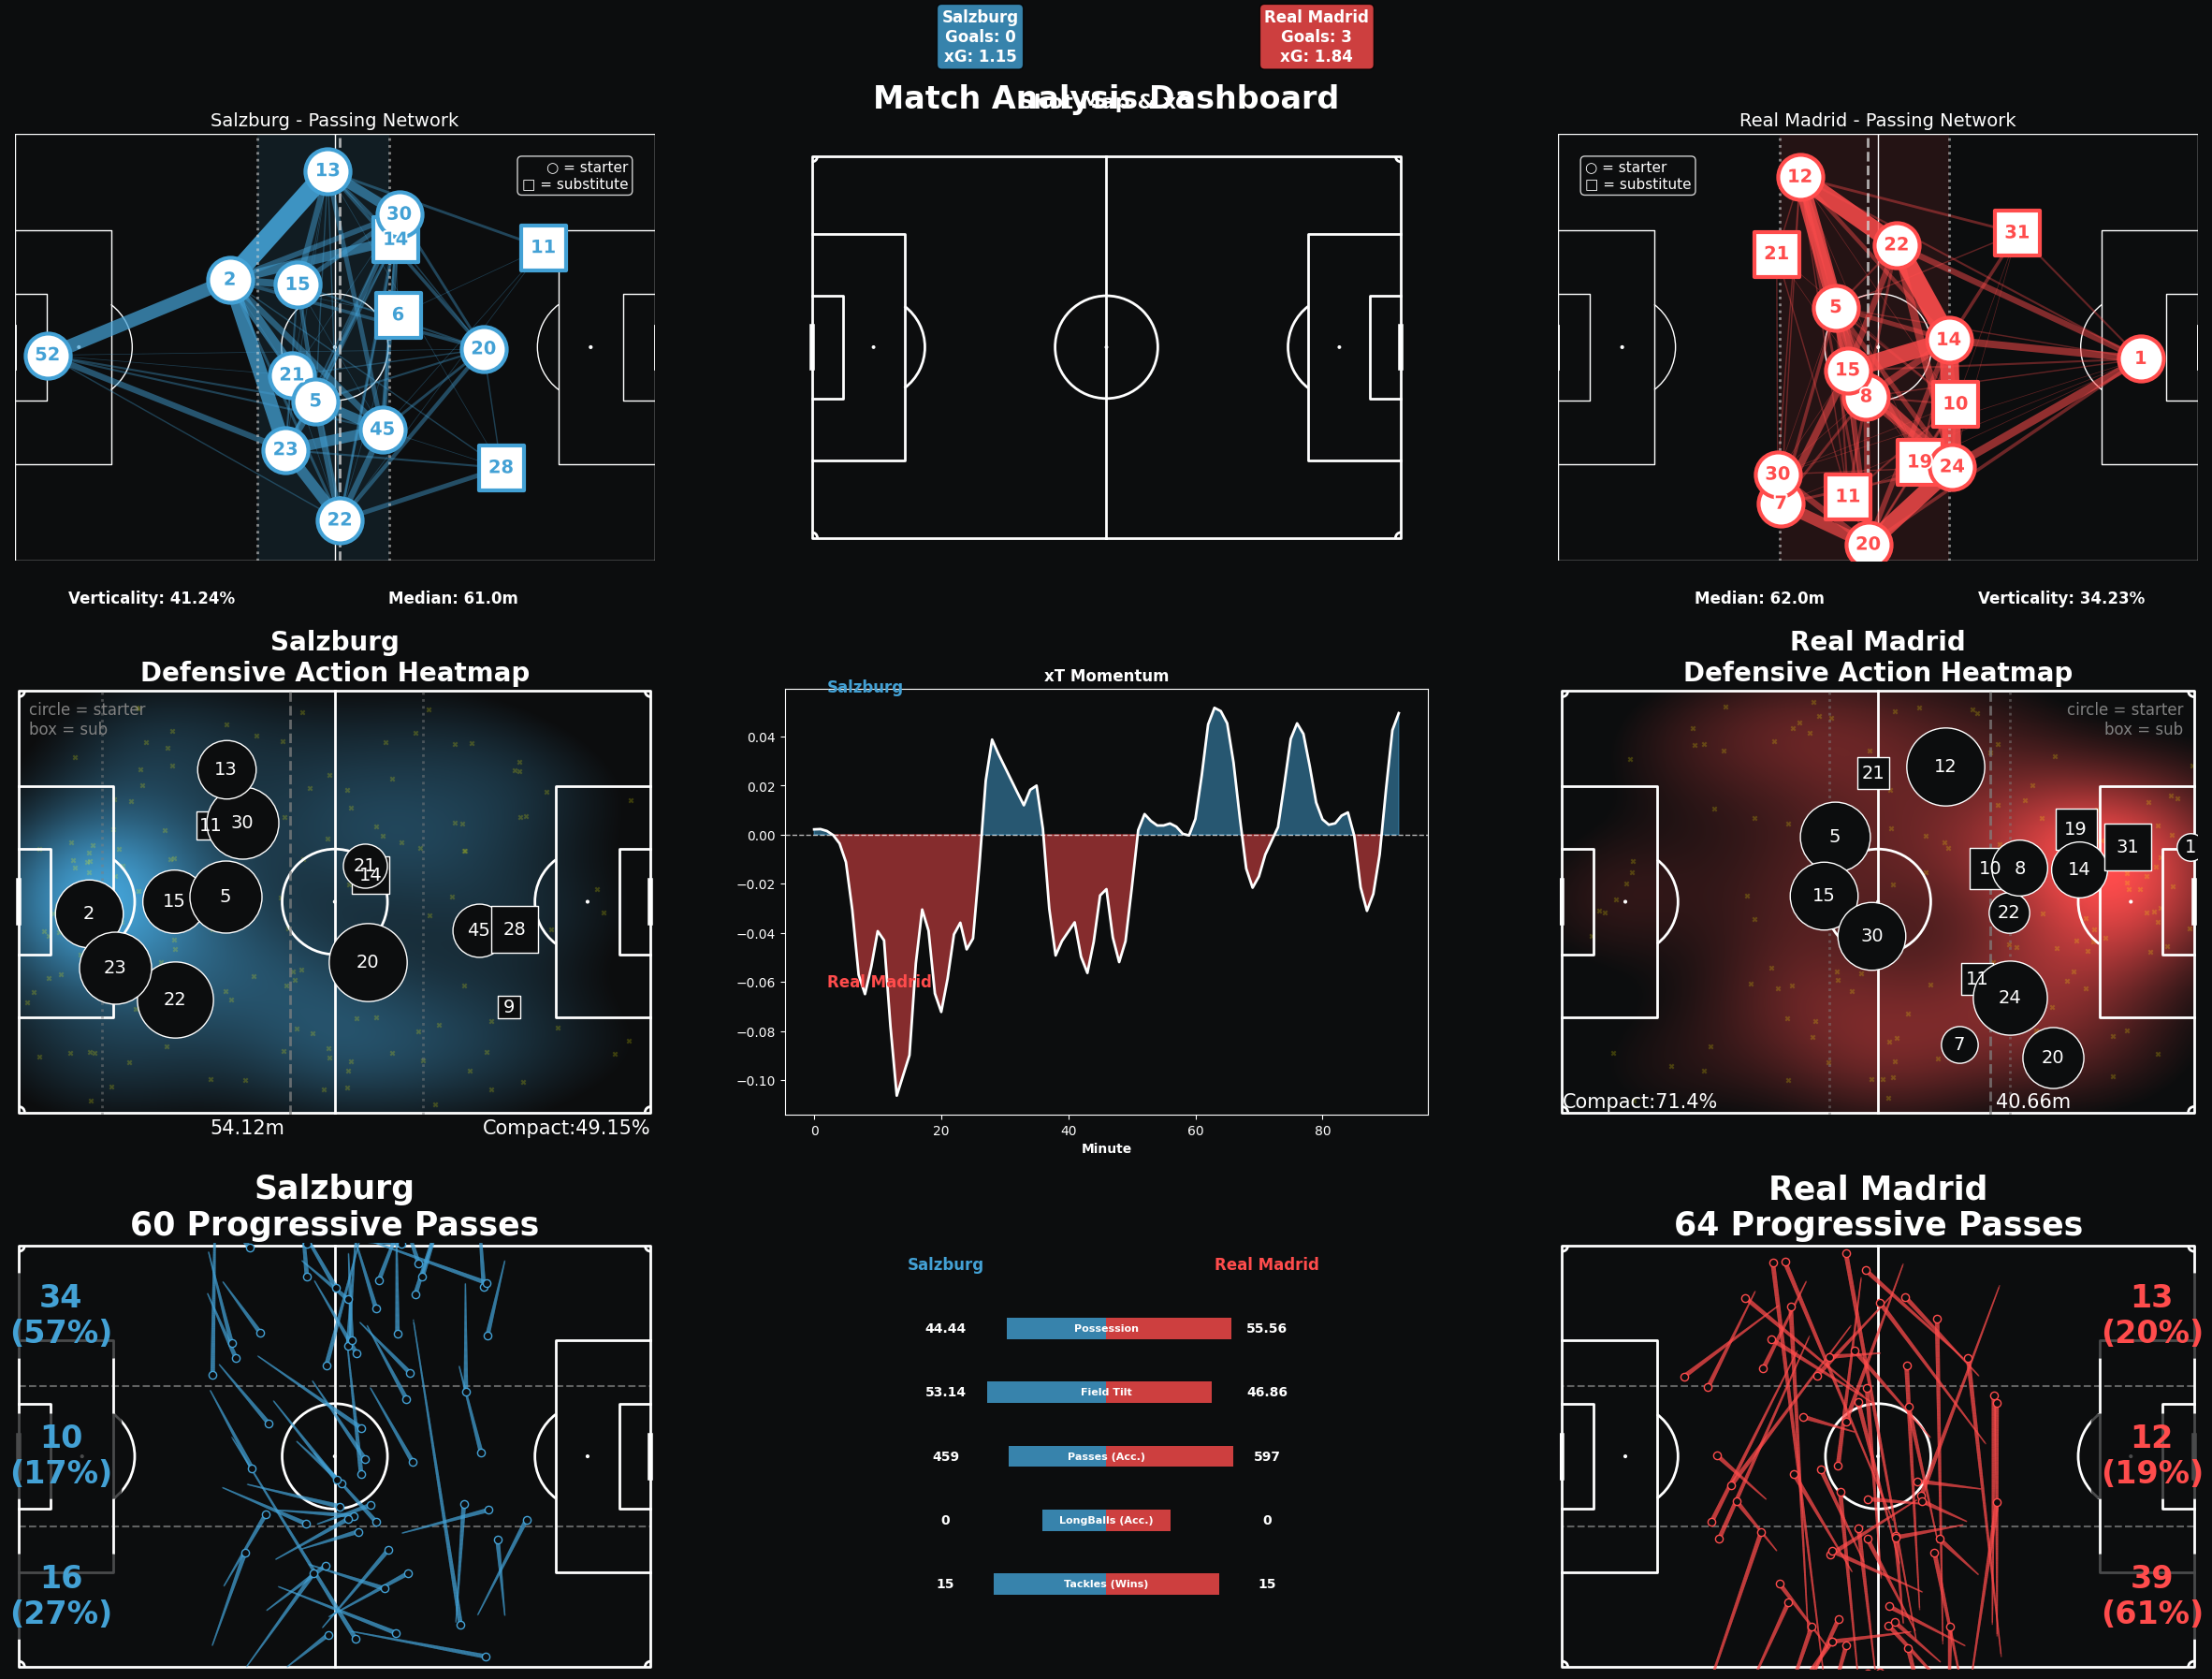

In [29]:
# ==================== SHOT MAP DEBUG SECTION ====================
print("=== SHOT MAP DEBUGGING ===")

# 1. Check shots_merged basic info
print(f"shots_merged shape: {shots_merged.shape}")
print(f"shots_merged columns: {list(shots_merged.columns)}")

# 2. Check team_id values
print(f"Unique team_ids in shots_merged: {shots_merged['team_id'].unique()}")
print(f"Looking for home_team_id: {home_team_id}, away_team_id: {away_team_id}")

# 3. Check if filtering works
home_shots_debug = shots_merged[shots_merged['team_id'] == home_team_id]
away_shots_debug = shots_merged[shots_merged['team_id'] == away_team_id]
print(f"Home shots found: {len(home_shots_debug)}")
print(f"Away shots found: {len(away_shots_debug)}")

# 4. Check required columns exist
required_cols = ['outcome_type_display_name', 'xG', 'x', 'y']
missing_cols = [col for col in required_cols if col not in shots_merged.columns]
if missing_cols:
    print(f"❌ Missing columns: {missing_cols}")
    print(f"Available similar columns: {[col for col in shots_merged.columns if any(req in col.lower() for req in ['outcome', 'xg', 'goal'])]}")
else:
    print("✅ All required columns present")

# 5. Show first few rows if data exists
if len(shots_merged) > 0:
    print(f"First shot example:")
    print(shots_merged.iloc[0][['team_id', 'x', 'y'] + [col for col in required_cols if col in shots_merged.columns]])

print("=== DEBUG COMPLETE ===\n")
# ==================== VERSIONES SUBPLOT-FRIENDLY CORREGIDAS ====================

def plot_shot_map_subplot(ax, shots_merged, home_stats, away_stats, home_team_id, away_team_id, home_team_name, away_team_name):
    """Shot map adaptado para subplot"""
    pitch = Pitch(pitch_type='uefa', pitch_color='#0C0D0E', line_color='white', linewidth=2, corner_arcs=True)
    pitch.draw(ax=ax)
    
    # Home shots
    home_shots = shots_merged[shots_merged['team_id'] == home_team_id]
    away_shots = shots_merged[shots_merged['team_id'] == away_team_id]
    
    # Plot shots
    for _, shot in home_shots.iterrows():
        color = '#00FF41' if shot['outcome_type_display_name'] == 'Goal' else '#43A1D5'
        size = shot['xG'] * 1000 + 50
        ax.scatter(shot['x'] * 1.2, shot['y'] * 0.8, s=size, color=color, alpha=0.7, 
                  edgecolors='white', linewidth=1.5, zorder=3)
    
    for _, shot in away_shots.iterrows():
        x_coord = 120 - (shot['x'] * 1.2)
        y_coord = 80 - (shot['y'] * 0.8)
        color = '#00FF41' if shot['outcome_type_display_name'] == 'Goal' else '#FF4C4C'
        size = shot['xG'] * 1000 + 50
        ax.scatter(x_coord, y_coord, s=size, color=color, alpha=0.7, 
                  edgecolors='white', linewidth=1.5, zorder=3)
    
    # Stats text - USE LIST INDICES instead of dict keys
    home_goals = home_stats[0]   # goals is index 0
    away_goals = away_stats[0]   # goals is index 0  
    home_xg = home_stats[1]      # xg is index 1
    away_xg = away_stats[1]      # xg is index 1
    
    ax.text(30, 85, f"{home_team_name}\nGoals: {home_goals}\nxG: {home_xg:.2f}", 
            fontsize=12, color='white', weight='bold', ha='center',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='#43A1D5', alpha=0.8))
    
    ax.text(90, 85, f"{away_team_name}\nGoals: {away_goals}\nxG: {away_xg:.2f}", 
            fontsize=12, color='white', weight='bold', ha='center',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='#FF4C4C', alpha=0.8))
    
    ax.set_title('Shot Map & xG', fontsize=16, color='white', weight='bold', pad=20)

def plot_xt_momentum_subplot(ax, df_events, xT_grid, team_id_to_name, home_team_id, away_team_id):
    """xT Momentum adaptado para subplot"""
    ax.set_facecolor('#0C0D0E')
    
    try:
        # Lógica del cálculo de momentum (copiada de tu función)
        df = df_events.copy()
        df['x'] = df['x'] * 1.2
        df['y'] = df['y'] * 0.8
        df['end_x'] = df['end_x'] * 1.2
        df['end_y'] = df['end_y'] * 0.8

        n_rows, n_cols = xT_grid.shape
        
        # Filter for successful passes and carries
        mask = (
            df['type_display_name'].isin(['Pass', 'Carry']) &
            (df['outcome_type_display_name'] == 'Successful')
        )
        df_xT = df[mask].copy()

        if len(df_xT) == 0:
            ax.text(0.5, 0.5, 'No xT data available', transform=ax.transAxes, 
                   ha='center', va='center', color='white', fontsize=14)
            return

        # Bin locations
        def get_bin(val, max_val, n_bins):
            val = max(0, min(val, max_val))
            bin_idx = int(val / max_val * n_bins)
            return min(bin_idx, n_bins - 1)

        df_xT['start_x_bin'] = df_xT['x'].apply(lambda x: get_bin(x, 120, n_cols))
        df_xT['start_y_bin'] = df_xT['y'].apply(lambda y: get_bin(y, 80, n_rows))
        df_xT['end_x_bin'] = df_xT['end_x'].apply(lambda x: get_bin(x, 120, n_cols))
        df_xT['end_y_bin'] = df_xT['end_y'].apply(lambda y: get_bin(y, 80, n_rows))

        # Calculate xT
        df_xT['start_zone_value'] = df_xT.apply(lambda row: xT_grid[row['start_y_bin'], row['start_x_bin']], axis=1)
        df_xT['end_zone_value'] = df_xT.apply(lambda row: xT_grid[row['end_y_bin'], row['end_x_bin']], axis=1)
        df_xT['xT'] = df_xT['end_zone_value'] - df_xT['start_zone_value']
        df_xT['xT_clipped'] = np.clip(df_xT['xT'], 0, 0.1)
        df_xT['team'] = df_xT['team_id'].map(team_id_to_name)

        # Calculate momentum per minute
        max_xT_per_minute = df_xT.groupby(['team', 'minute'])['xT_clipped'].max().reset_index()
        minutes = sorted(max_xT_per_minute['minute'].unique())
        teams = [team_id_to_name[home_team_id], team_id_to_name[away_team_id]]
        
        if len(minutes) == 0:
            ax.text(0.5, 0.5, 'No momentum data', transform=ax.transAxes, 
                   ha='center', va='center', color='white', fontsize=14)
            return
        
        window_size = 4
        decay_rate = 0.25
        weighted_xT_sum = {team: [] for team in teams}
        momentum = []

        for current_minute in minutes:
            for team in teams:
                recent_xT = max_xT_per_minute[
                    (max_xT_per_minute['team'] == team) &
                    (max_xT_per_minute['minute'] <= current_minute) &
                    (max_xT_per_minute['minute'] > current_minute - window_size)
                ]
                weights = np.exp(-decay_rate * (current_minute - recent_xT['minute'].values))
                weighted_sum = np.sum(weights * recent_xT['xT_clipped'].values)
                weighted_xT_sum[team].append(weighted_sum)
            momentum.append(weighted_xT_sum[teams[0]][-1] - weighted_xT_sum[teams[1]][-1])

        # Smoothing y plotting
        momentum_smoothed = gaussian_filter1d(momentum, sigma=1.0)
        
        ax.plot(minutes, momentum_smoothed, color='white', linewidth=2)
        ax.axhline(0, color='white', linestyle='--', linewidth=1, alpha=0.7)
        ax.fill_between(minutes, momentum_smoothed, where=(np.array(momentum_smoothed) > 0), 
                       color='#43A1D5', alpha=0.5, interpolate=True)
        ax.fill_between(minutes, momentum_smoothed, where=(np.array(momentum_smoothed) < 0), 
                       color='#FF4C4C', alpha=0.5, interpolate=True)
        
        # Team names
        ax.text(2, 0.06, team_id_to_name[home_team_id], fontsize=12, ha='left', va='center', 
                color='#43A1D5', fontweight='bold')
        ax.text(2, -0.06, team_id_to_name[away_team_id], fontsize=12, ha='left', va='center', 
                color='#FF4C4C', fontweight='bold')
        
        # Styling
        ax.set_xlabel('Minute', color='white', fontsize=10, fontweight='bold')
        ax.set_title('xT Momentum', color='white', fontsize=12, fontweight='bold')
        ax.tick_params(colors='white')
        for spine in ax.spines.values():
            spine.set_color('white')
            
    except Exception as e:
        ax.text(0.5, 0.5, f'Error: {str(e)}', transform=ax.transAxes, 
               ha='center', va='center', color='white', fontsize=10)

def plot_match_stats_subplot(ax, stats, home_team_name, away_team_name):
    """Match stats adaptado para subplot"""
    ax.set_facecolor('#0C0D0E')
    ax.axis('off')
    
    # Stats principales - usando keys que sabemos que existen
    try:
        stat_keys = list(stats.keys())
        if len(stat_keys) == 0:
            ax.text(0.5, 0.5, 'No stats available', transform=ax.transAxes, 
                   ha='center', va='center', color='white', fontsize=14)
            return
            
        # Tomar primeros 5 stats
        categories = stat_keys[:5]
        y_positions = np.linspace(0.8, 0.2, len(categories))
        
        for i, category in enumerate(categories):
            stat_data = stats[category]
            home_val = stat_data.get('home', 0) if isinstance(stat_data, dict) else 0
            away_val = stat_data.get('away', 0) if isinstance(stat_data, dict) else 0
            
            # Normalizar valores para barras
            total = home_val + away_val
            if total > 0:
                home_width = (home_val / total) * 0.35
                away_width = (away_val / total) * 0.35
            else:
                home_width = away_width = 0.1
            
            # Home bar (izquierda)
            ax.barh(y_positions[i], home_width, left=0.5-home_width, height=0.05, 
                    color='#43A1D5', alpha=0.8)
            # Away bar (derecha)  
            ax.barh(y_positions[i], away_width, left=0.5, height=0.05, 
                    color='#FF4C4C', alpha=0.8)
            
            # Textos
            ax.text(0.25, y_positions[i], f'{home_val}', ha='center', va='center', 
                    color='white', fontsize=10, weight='bold')
            ax.text(0.75, y_positions[i], f'{away_val}', ha='center', va='center', 
                    color='white', fontsize=10, weight='bold')
            ax.text(0.5, y_positions[i], category, ha='center', va='center', 
                    color='white', fontsize=8, weight='bold')
        
        # Títulos de equipos
        ax.text(0.25, 0.95, home_team_name, ha='center', va='center', 
                color='#43A1D5', fontsize=12, weight='bold')
        ax.text(0.75, 0.95, away_team_name, ha='center', va='center', 
                color='#FF4C4C', fontsize=12, weight='bold')
        
    except Exception as e:
        ax.text(0.5, 0.5, f'Stats error: {str(e)}', transform=ax.transAxes, 
               ha='center', va='center', color='white', fontsize=10)
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

# ==================== DATA STANDARDIZATION SECTION ====================
print("=== DATA STANDARDIZATION CHECK ===")

# 1. Check shots_merged columns
print(f"shots_merged columns: {list(shots_merged.columns)}")

# 2. Standardize shots_merged naming (if needed)
if 'teamId' in shots_merged.columns and 'team_id' not in shots_merged.columns:
    shots_merged = shots_merged.rename(columns={'teamId': 'team_id'})
    print("✅ Renamed 'teamId' to 'team_id' in shots_merged")

# 3. Check team dictionaries structure  
print(f"home_team keys: {list(home_team.keys())}")
print(f"away_team keys: {list(away_team.keys())}")

# 4. Extract team IDs and names consistently
if 'teamId' in home_team:
    home_team_id = home_team['teamId']
    away_team_id = away_team['teamId']
elif 'team_id' in home_team:
    home_team_id = home_team['team_id'] 
    away_team_id = away_team['team_id']
else:
    # Fallback to hardcoded
    home_team_id = 361
    away_team_id = 52
    print("⚠️ Using hardcoded team IDs as fallback")

# Extract team names
home_team_name = home_team.get('name', 'Home Team')
away_team_name = away_team.get('name', 'Away Team')

print(f"✅ Team IDs extracted: Home={home_team_id} ({home_team_name}), Away={away_team_id} ({away_team_name})")
print("=== STANDARDIZATION COMPLETE ===\n")

# ==================== PREPARAR DATOS DEFENSIVOS ====================

try:
    # Filtrar acciones defensivas
    defensive_actions = filter_defensive_actions(df_events)
    print(f"Found {len(defensive_actions)} defensive actions")

    # Calcular posiciones defensivas para cada equipo - USANDO VARIABLES DINÁMICAS
    home_positions = calculate_player_defensive_positions(
        defensive_actions, home_team_id, home_team['players']
    )
    away_positions = calculate_player_defensive_positions(
        defensive_actions, away_team_id, away_team['players']
    )

    # Filtrar acciones por equipo - USANDO VARIABLES DINÁMICAS
    home_actions = defensive_actions[defensive_actions['team_id'] == home_team_id]
    away_actions = defensive_actions[defensive_actions['team_id'] == away_team_id]

    print(f"Defensive data prepared: Home positions={len(home_positions)}, Home actions={len(home_actions)}")
    print(f"                         Away positions={len(away_positions)}, Away actions={len(away_actions)}")

except Exception as e:
    print(f"Error preparing defensive data: {e}")
    home_positions = {}
    away_positions = {}
    home_actions = pd.DataFrame()
    away_actions = pd.DataFrame()

# ==================== CREAR DASHBOARD DINÁMICO ====================

# Setup del dashboard
fig, axs = plt.subplots(3, 3, figsize=(24, 18), facecolor='#0C0D0E')
fig.suptitle('Match Analysis Dashboard', fontsize=24, color='white', weight='bold', y=0.95)

# Eliminar ejes centrales (columna del medio)

# FILA 1: Passing Networks - DINÁMICO
plot_enhanced_network(axs[0,0], passes_df, home_avg_locs, home_combinations, home_metrics,
                     home_team_name, color='#43A1D5', is_home=True, bg_color='#0C0D0E')

plot_enhanced_network(axs[0,2], passes_df, away_avg_locs, away_combinations, away_metrics,
                     away_team_name, color='#FF4C4C', is_home=False, bg_color='#0C0D0E')

# FILA 2: Defensive Actions - DINÁMICO
defensive_block(axs[1,0], home_positions, home_actions, 
               home_team_name, '#43A1D5', is_away_team=False)
defensive_block(axs[1,2], away_positions, away_actions, 
               away_team_name, '#FF4C4C', is_away_team=True)

# FILA 3: Progressive Passes - DINÁMICO
draw_progressive_pass_map(axs[2,0], home_team_id, home_team_name, '#43A1D5', is_away_team=False)
draw_progressive_pass_map(axs[2,2], away_team_id, away_team_name, '#FF4C4C', is_away_team=True)

# COLUMNA CENTRAL: Shot Map, Momentum, Match Stats - DINÁMICO
plot_shot_map_subplot(axs[0,1], shots_merged, home_stats, away_stats, 
                     home_team_id, away_team_id, home_team_name, away_team_name)

plot_xt_momentum_subplot(axs[1,1], df_events, xT_grid, team_id_to_name, 
                        home_team_id, away_team_id)

plot_match_stats_subplot(axs[2,1], stats, home_team_name, away_team_name)

# Ajustar spacing
plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.3, wspace=0.2)
plt.show()

#### Experiment 3

✅ WhoScored IDs: Home=361 (Salzburg), Away=52 (Real Madrid)
✅ Fotmob IDs: Home=10013, Away=8633


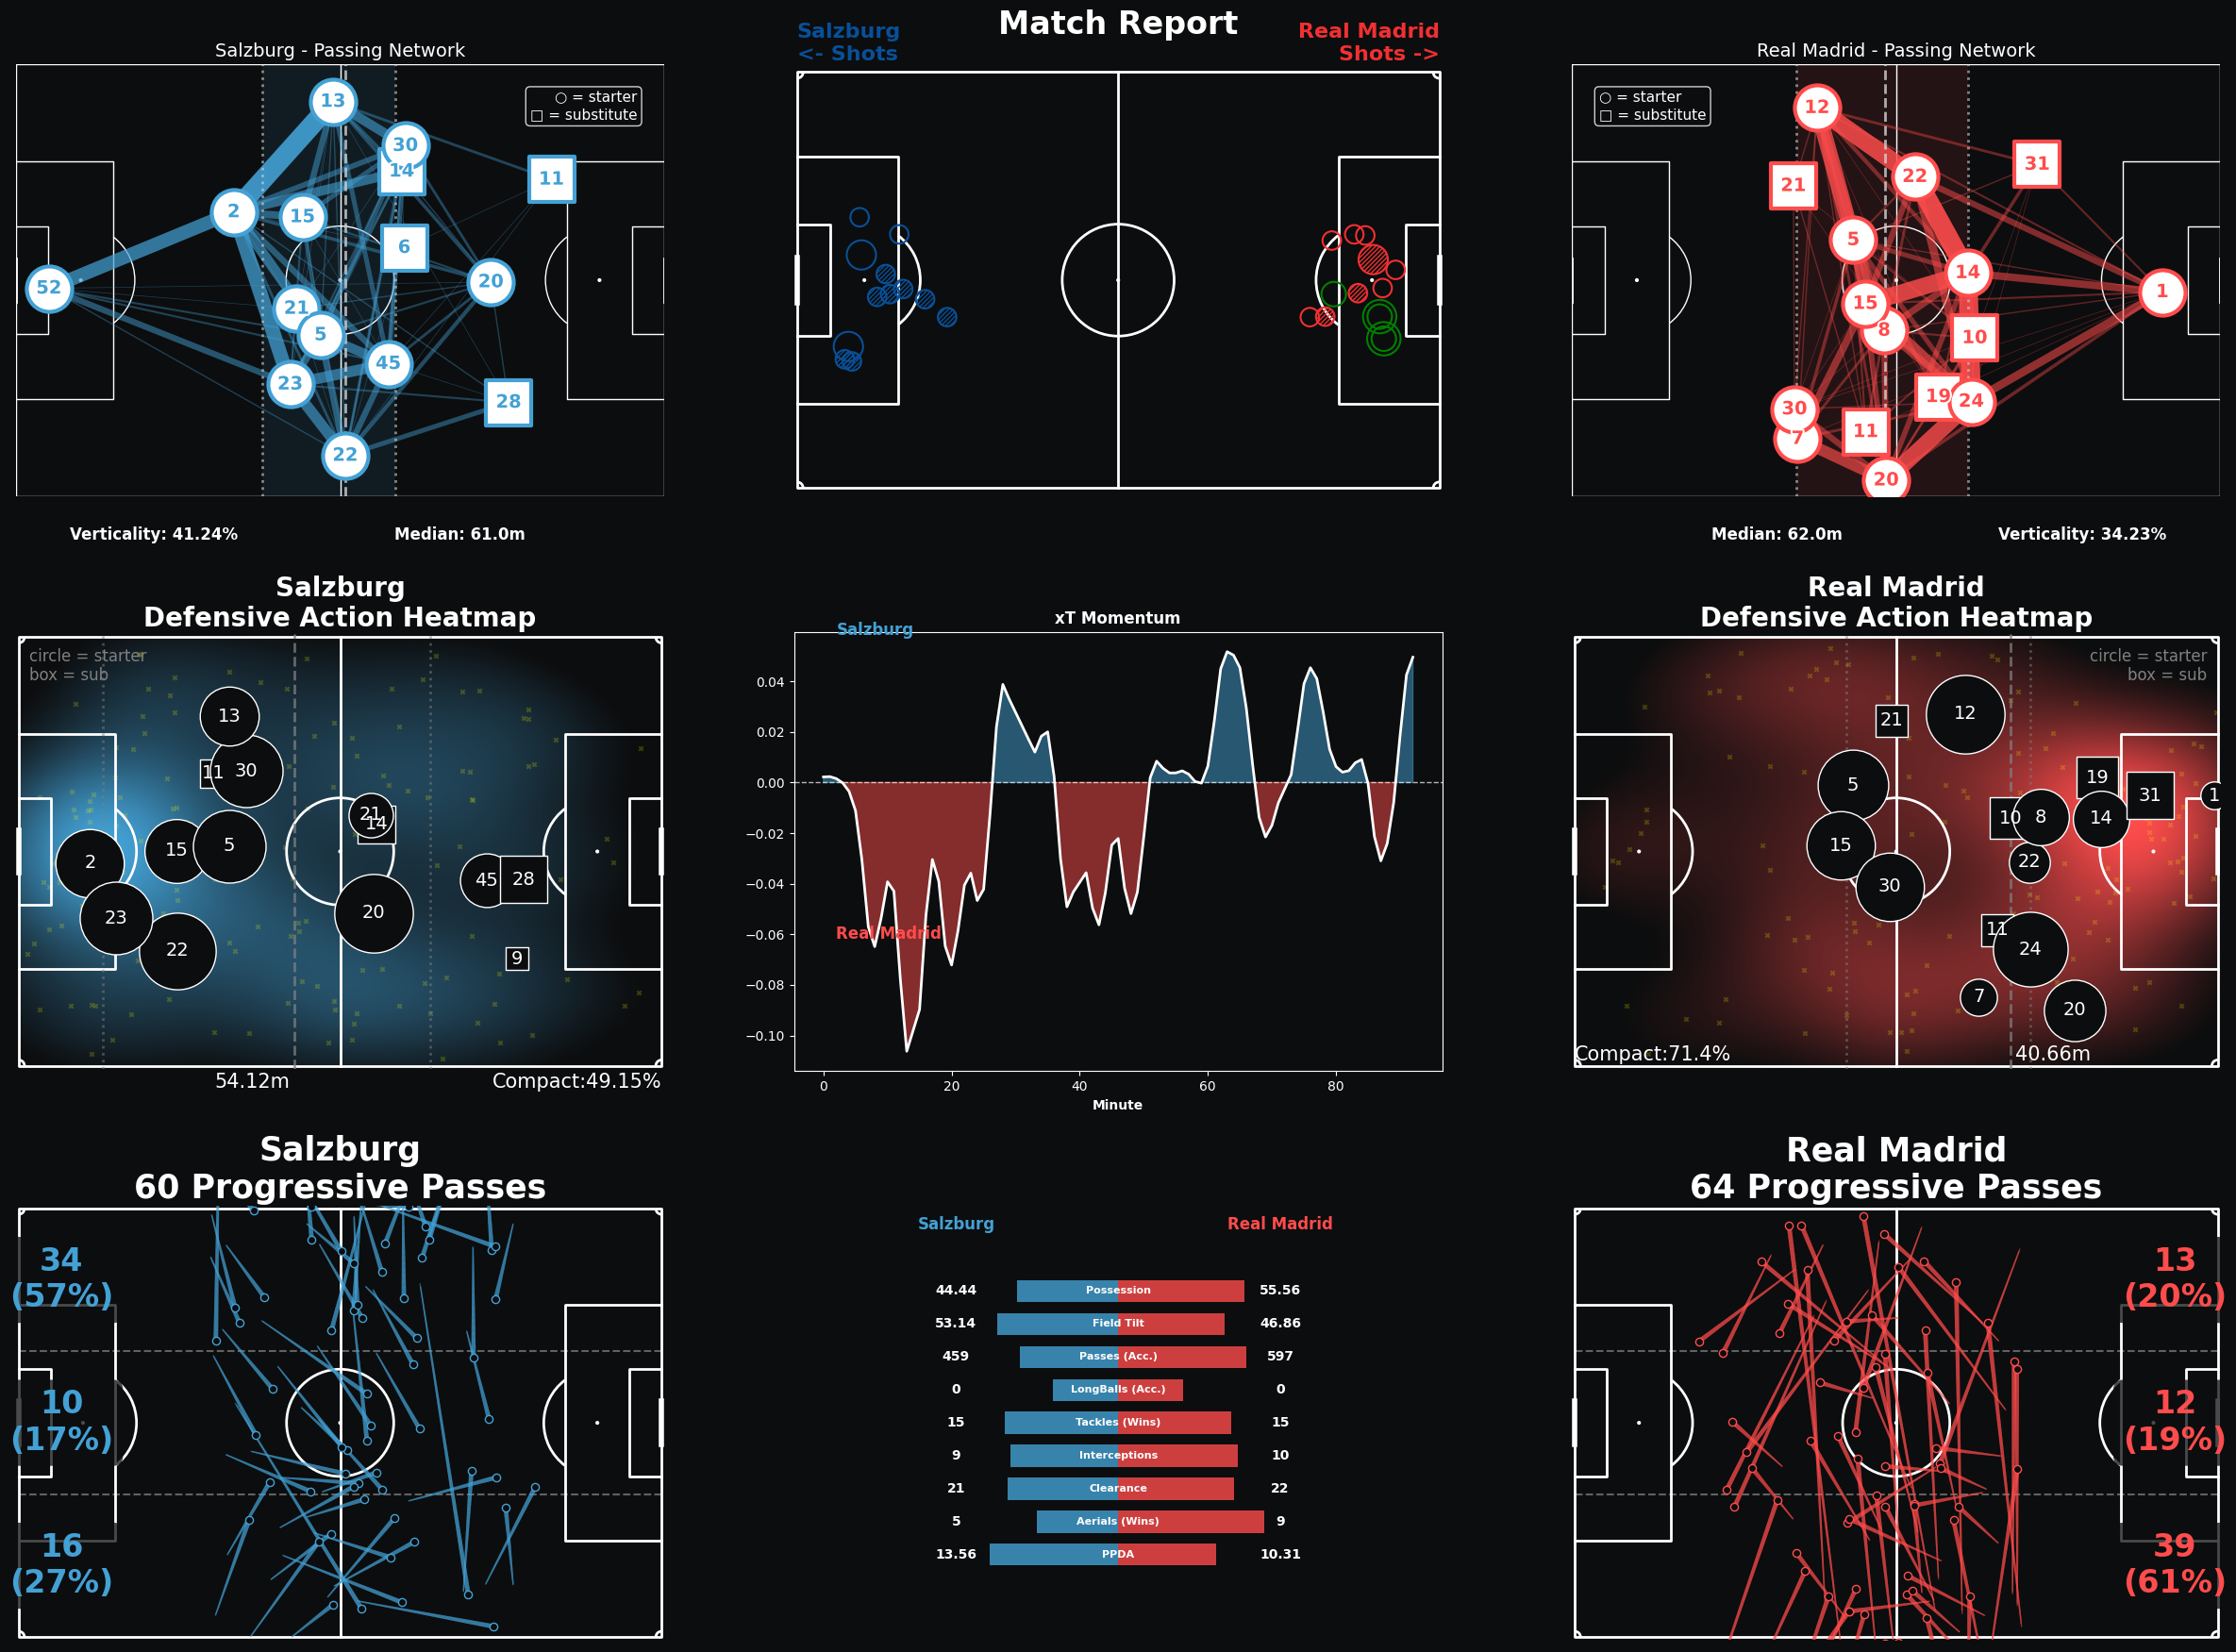

In [30]:
# ==================== VERSIONES SUBPLOT-FRIENDLY CORREGIDAS ====================

def plot_shot_map_subplot(ax, shots_merged, home_stats, away_stats, home_fotmob_id, away_fotmob_id, home_team_name, away_team_name):
    """
    Shot map adaptado para subplot - USANDO TU METODOLOGÍA ORIGINAL
    """
    # Configurar pitch igual que tu original
    pitch = Pitch(pitch_type='uefa', pitch_color='#0C0D0E', line_color='white', linewidth=2, corner_arcs=True)
    pitch.draw(ax=ax)
    ax.set_ylim(-0.5, 68.5)
    ax.set_xlim(-0.5, 105.5)
    
    # Split shots by team - USANDO FOTMOB IDs CORRECTOS
    home_shots = shots_merged[shots_merged['team_id'] == home_fotmob_id]
    away_shots = shots_merged[shots_merged['team_id'] == away_fotmob_id]
    
    # TU HELPER FUNCTION ORIGINAL - ADAPTADA PARA SUBPLOT
    def plot_shots(df, color, is_home_team=True, marker='o', s=200, edgecolor=None, fill=True, hatch=None, zorder=2):
        if len(df) > 0:
            face_color = color if fill else 'none'
            edge_color = edgecolor if edgecolor else color
            
            # Transform coordinates based on team - TU SISTEMA ORIGINAL
            if is_home_team:
                # Home team (left side): flip coordinates
                x_coords = 105 - df['x']
                y_coords = 68 - df['y']
            else:
                # Away team (right side): use original coordinates
                x_coords = df['x']
                y_coords = df['y']
                
            ax.scatter(x_coords, y_coords, s=s, c=face_color, marker=marker, 
                      edgecolors=edge_color, zorder=zorder, hatch=hatch, linewidth=1.5)
    
    # --- HOME TEAM SHOTS (LEFT SIDE) - TU ESTÉTICA ORIGINAL ---
    home_color = "#085098"  # Salzburg blue
    
    # Goals (green football marker)
    home_goals = home_shots[(home_shots['eventType'] == 'Goal') & (~home_shots['is_own_goal'])]
    plot_shots(home_goals, 'none', is_home_team=True, marker='o', s=350, edgecolor='green', zorder=3)
    
    # Own goals (orange football marker)
    home_own_goals = home_shots[home_shots['is_own_goal']]
    plot_shots(home_own_goals, 'none', is_home_team=True, marker='o', s=350, edgecolor='orange', zorder=3)
    
    # Regular shots (not big chances)
    home_misses = home_shots[(home_shots['eventType'] == 'Miss') & (~home_shots['is_big_chance'])]
    plot_shots(home_misses, 'none', is_home_team=True, edgecolor=home_color, fill=False)
    
    home_saves = home_shots[(home_shots['eventType'] == 'AttemptSaved') & (~home_shots['is_big_chance'])]
    plot_shots(home_saves, 'none', is_home_team=True, edgecolor=home_color, fill=False, hatch='///////')
    
    home_posts = home_shots[(home_shots['eventType'] == 'Post') & (~home_shots['is_big_chance'])]
    plot_shots(home_posts, home_color, is_home_team=True, edgecolor=home_color)
    
    # Big chances (bigger markers)
    home_big_misses = home_shots[(home_shots['eventType'] == 'Miss') & (home_shots['is_big_chance'])]
    plot_shots(home_big_misses, 'none', is_home_team=True, edgecolor=home_color, fill=False, s=500)
    
    home_big_saves = home_shots[(home_shots['eventType'] == 'AttemptSaved') & (home_shots['is_big_chance'])]
    plot_shots(home_big_saves, 'none', is_home_team=True, edgecolor=home_color, fill=False, hatch='///////', s=500)
    
    home_big_posts = home_shots[(home_shots['eventType'] == 'Post') & (home_shots['is_big_chance'])]
    plot_shots(home_big_posts, home_color, is_home_team=True, edgecolor=home_color, s=500)
    
    home_big_goals = home_shots[(home_shots['eventType'] == 'Goal') & (home_shots['is_big_chance']) & (~home_shots['is_own_goal'])]
    plot_shots(home_big_goals, 'none', is_home_team=True, marker='o', s=650, edgecolor='green', zorder=3)
    
    # --- AWAY TEAM SHOTS (RIGHT SIDE) - TU ESTÉTICA ORIGINAL ---
    away_color = "#F13032"  # Real Madrid red
    
    # Goals (green football marker)
    away_goals = away_shots[(away_shots['eventType'] == 'Goal') & (~away_shots['is_own_goal'])]
    plot_shots(away_goals, 'none', is_home_team=False, marker='o', s=350, edgecolor='green', zorder=3)
    
    # Own goals (orange football marker)
    away_own_goals = away_shots[away_shots['is_own_goal']]
    plot_shots(away_own_goals, 'none', is_home_team=False, marker='o', s=350, edgecolor='orange', zorder=3)
    
    # Regular shots (not big chances)
    away_misses = away_shots[(away_shots['eventType'] == 'Miss') & (~away_shots['is_big_chance'])]
    plot_shots(away_misses, 'none', is_home_team=False, edgecolor=away_color, fill=False)
    
    away_saves = away_shots[(away_shots['eventType'] == 'AttemptSaved') & (~away_shots['is_big_chance'])]
    plot_shots(away_saves, 'none', is_home_team=False, edgecolor=away_color, fill=False, hatch='///////')
    
    away_posts = away_shots[(away_shots['eventType'] == 'Post') & (~away_shots['is_big_chance'])]
    plot_shots(away_posts, away_color, is_home_team=False, edgecolor=away_color)
    
    # Big chances (bigger markers)
    away_big_misses = away_shots[(away_shots['eventType'] == 'Miss') & (away_shots['is_big_chance'])]
    plot_shots(away_big_misses, 'none', is_home_team=False, edgecolor=away_color, fill=False, s=500)
    
    away_big_saves = away_shots[(away_shots['eventType'] == 'AttemptSaved') & (away_shots['is_big_chance'])]
    plot_shots(away_big_saves, 'none', is_home_team=False, edgecolor=away_color, fill=False, hatch='///////', s=500)
    
    away_big_posts = away_shots[(away_shots['eventType'] == 'Post') & (away_shots['is_big_chance'])]
    plot_shots(away_big_posts, away_color, is_home_team=False, edgecolor=away_color, s=500)
    
    away_big_goals = away_shots[(away_shots['eventType'] == 'Goal') & (away_shots['is_big_chance']) & (~away_shots['is_own_goal'])]
    plot_shots(away_big_goals, 'none', is_home_team=False, marker='o', s=650, edgecolor='green', zorder=3)
    
    # Stats - usando tu formato original con home_stats y away_stats lists
    home_goals_stat = home_stats[0]   # goals is index 0
    away_goals_stat = away_stats[0]   # goals is index 0  
    home_xg = home_stats[1]           # xg is index 1
    away_xg = away_stats[1]           # xg is index 1
    
    # Team names y direction indicators - IGUAL QUE TU ORIGINAL
    ax.text(0, 70, f"{home_team_name}\n<- Shots", color=home_color, size=16, ha='left', fontweight='bold')
    ax.text(105, 70, f"{away_team_name}\nShots ->", color=away_color, size=16, ha='right', fontweight='bold')
    
    # Remove axis
    ax.axis('off')

def plot_xt_momentum_subplot(ax, df_events, xT_grid, team_id_to_name, home_team_id, away_team_id):
    """xT Momentum adaptado para subplot"""
    ax.set_facecolor('#0C0D0E')
    
    try:
        # Lógica del cálculo de momentum (copiada de tu función)
        df = df_events.copy()
        df['x'] = df['x'] * 1.2
        df['y'] = df['y'] * 0.8
        df['end_x'] = df['end_x'] * 1.2
        df['end_y'] = df['end_y'] * 0.8

        n_rows, n_cols = xT_grid.shape
        
        # Filter for successful passes and carries
        mask = (
            df['type_display_name'].isin(['Pass', 'Carry']) &
            (df['outcome_type_display_name'] == 'Successful')
        )
        df_xT = df[mask].copy()

        if len(df_xT) == 0:
            ax.text(0.5, 0.5, 'No xT data available', transform=ax.transAxes, 
                   ha='center', va='center', color='white', fontsize=14)
            return

        # Bin locations
        def get_bin(val, max_val, n_bins):
            val = max(0, min(val, max_val))
            bin_idx = int(val / max_val * n_bins)
            return min(bin_idx, n_bins - 1)

        df_xT['start_x_bin'] = df_xT['x'].apply(lambda x: get_bin(x, 120, n_cols))
        df_xT['start_y_bin'] = df_xT['y'].apply(lambda y: get_bin(y, 80, n_rows))
        df_xT['end_x_bin'] = df_xT['end_x'].apply(lambda x: get_bin(x, 120, n_cols))
        df_xT['end_y_bin'] = df_xT['end_y'].apply(lambda y: get_bin(y, 80, n_rows))

        # Calculate xT
        df_xT['start_zone_value'] = df_xT.apply(lambda row: xT_grid[row['start_y_bin'], row['start_x_bin']], axis=1)
        df_xT['end_zone_value'] = df_xT.apply(lambda row: xT_grid[row['end_y_bin'], row['end_x_bin']], axis=1)
        df_xT['xT'] = df_xT['end_zone_value'] - df_xT['start_zone_value']
        df_xT['xT_clipped'] = np.clip(df_xT['xT'], 0, 0.1)
        df_xT['team'] = df_xT['team_id'].map(team_id_to_name)

        # Calculate momentum per minute
        max_xT_per_minute = df_xT.groupby(['team', 'minute'])['xT_clipped'].max().reset_index()
        minutes = sorted(max_xT_per_minute['minute'].unique())
        teams = [team_id_to_name[home_team_id], team_id_to_name[away_team_id]]
        
        if len(minutes) == 0:
            ax.text(0.5, 0.5, 'No momentum data', transform=ax.transAxes, 
                   ha='center', va='center', color='white', fontsize=14)
            return
        
        window_size = 4
        decay_rate = 0.25
        weighted_xT_sum = {team: [] for team in teams}
        momentum = []

        for current_minute in minutes:
            for team in teams:
                recent_xT = max_xT_per_minute[
                    (max_xT_per_minute['team'] == team) &
                    (max_xT_per_minute['minute'] <= current_minute) &
                    (max_xT_per_minute['minute'] > current_minute - window_size)
                ]
                weights = np.exp(-decay_rate * (current_minute - recent_xT['minute'].values))
                weighted_sum = np.sum(weights * recent_xT['xT_clipped'].values)
                weighted_xT_sum[team].append(weighted_sum)
            momentum.append(weighted_xT_sum[teams[0]][-1] - weighted_xT_sum[teams[1]][-1])

        # Smoothing y plotting
        momentum_smoothed = gaussian_filter1d(momentum, sigma=1.0)
        
        ax.plot(minutes, momentum_smoothed, color='white', linewidth=2)
        ax.axhline(0, color='white', linestyle='--', linewidth=1, alpha=0.7)
        ax.fill_between(minutes, momentum_smoothed, where=(np.array(momentum_smoothed) > 0), 
                       color='#43A1D5', alpha=0.5, interpolate=True)
        ax.fill_between(minutes, momentum_smoothed, where=(np.array(momentum_smoothed) < 0), 
                       color='#FF4C4C', alpha=0.5, interpolate=True)
        
        # Team names
        ax.text(2, 0.06, team_id_to_name[home_team_id], fontsize=12, ha='left', va='center', 
                color='#43A1D5', fontweight='bold')
        ax.text(2, -0.06, team_id_to_name[away_team_id], fontsize=12, ha='left', va='center', 
                color='#FF4C4C', fontweight='bold')
        
        # Styling
        ax.set_xlabel('Minute', color='white', fontsize=10, fontweight='bold')
        ax.set_title('xT Momentum', color='white', fontsize=12, fontweight='bold')
        ax.tick_params(colors='white')
        for spine in ax.spines.values():
            spine.set_color('white')
            
    except Exception as e:
        ax.text(0.5, 0.5, f'Error: {str(e)}', transform=ax.transAxes, 
               ha='center', va='center', color='white', fontsize=10)

def plot_match_stats_subplot(ax, stats, home_team_name, away_team_name):
    """Match stats adaptado para subplot"""
    ax.set_facecolor('#0C0D0E')
    ax.axis('off')
    
    # Stats principales - usando keys que sabemos que existen
    try:
        stat_keys = list(stats.keys())
        if len(stat_keys) == 0:
            ax.text(0.5, 0.5, 'No stats available', transform=ax.transAxes, 
                   ha='center', va='center', color='white', fontsize=14)
            return
            
        # Tomar primeros 5 stats
        categories = stat_keys
        y_positions = np.linspace(0.8, 0.2, len(categories))
        
        for i, category in enumerate(categories):
            stat_data = stats[category]
            home_val = stat_data.get('home', 0) if isinstance(stat_data, dict) else 0
            away_val = stat_data.get('away', 0) if isinstance(stat_data, dict) else 0
            
            # Normalizar valores para barras
            total = home_val + away_val
            if total > 0:
                home_width = (home_val / total) * 0.35
                away_width = (away_val / total) * 0.35
            else:
                home_width = away_width = 0.1
            
            # Home bar (izquierda)
            ax.barh(y_positions[i], home_width, left=0.5-home_width, height=0.05, 
                    color='#43A1D5', alpha=0.8)
            # Away bar (derecha)  
            ax.barh(y_positions[i], away_width, left=0.5, height=0.05, 
                    color='#FF4C4C', alpha=0.8)
            
            # Textos
            ax.text(0.25, y_positions[i], f'{home_val}', ha='center', va='center', 
                    color='white', fontsize=10, weight='bold')
            ax.text(0.75, y_positions[i], f'{away_val}', ha='center', va='center', 
                    color='white', fontsize=10, weight='bold')
            ax.text(0.5, y_positions[i], category, ha='center', va='center', 
                    color='white', fontsize=8, weight='bold')
        
        # Títulos de equipos
        ax.text(0.25, 0.95, home_team_name, ha='center', va='center', 
                color='#43A1D5', fontsize=12, weight='bold')
        ax.text(0.75, 0.95, away_team_name, ha='center', va='center', 
                color='#FF4C4C', fontsize=12, weight='bold')
        
    except Exception as e:
        ax.text(0.5, 0.5, f'Stats error: {str(e)}', transform=ax.transAxes, 
               ha='center', va='center', color='white', fontsize=10)
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

# ==================== DUAL ID SYSTEM - SOLUCIÓN COMPLETA ====================

# WhoScored/Opta IDs (para events, passing, defensive actions, etc.)
home_team_id = home_team['team_id']  # WhoScored ID: 361
away_team_id = away_team['team_id']  # WhoScored ID: 52

# Fotmob IDs (SOLO para shot map)
home_fotmob_id = 10013  # Salzburg en Fotmob
away_fotmob_id = 8633   # Real Madrid en Fotmob

# Team names (iguales para ambas fuentes)
home_team_name = home_team['name'] 
away_team_name = away_team['name']

print(f"✅ WhoScored IDs: Home={home_team_id} ({home_team_name}), Away={away_team_id} ({away_team_name})")
print(f"✅ Fotmob IDs: Home={home_fotmob_id}, Away={away_fotmob_id}")

# ==================== CREAR DASHBOARD COMPLETO ====================

# Setup del dashboard
fig, axs = plt.subplots(3, 3, figsize=(24, 18), facecolor='#0C0D0E')
fig.suptitle('Match Report', fontsize=24, color='white', weight='bold', y=0.97)

# FILA 1: Passing Networks (MANTENER TODO LO QUE YA FUNCIONA)
plot_enhanced_network(axs[0,0], passes_df, home_avg_locs, home_combinations, home_metrics,
                     home_team_name, color='#43A1D5', is_home=True, bg_color='#0C0D0E')

plot_enhanced_network(axs[0,2], passes_df, away_avg_locs, away_combinations, away_metrics,
                     away_team_name, color='#FF4C4C', is_home=False, bg_color='#0C0D0E')

# FILA 2: Defensive Actions (MANTENER TODO LO QUE YA FUNCIONA)
defensive_block(axs[1,0], home_positions, home_actions, 
               home_team_name, '#43A1D5', is_away_team=False)
defensive_block(axs[1,2], away_positions, away_actions, 
               away_team_name, '#FF4C4C', is_away_team=True)

# FILA 3: Progressive Passes (MANTENER TODO LO QUE YA FUNCIONA)
draw_progressive_pass_map(axs[2,0], home_team_id, home_team_name, '#43A1D5', is_away_team=False)
draw_progressive_pass_map(axs[2,2], away_team_id, away_team_name, '#FF4C4C', is_away_team=True)

# COLUMNA CENTRAL: Shot Map (NUEVA VERSIÓN CON TU METODOLOGÍA), Momentum, Match Stats
plot_shot_map_subplot(axs[0,1], shots_merged, home_stats, away_stats, 
                     home_fotmob_id, away_fotmob_id, home_team_name, away_team_name)

plot_xt_momentum_subplot(axs[1,1], df_events, xT_grid, team_id_to_name, 
                        home_team_id, away_team_id)

plot_match_stats_subplot(axs[2,1], stats, home_team_name, away_team_name)

# Ajustar spacing
plt.tight_layout()
plt.subplots_adjust(top=0.94, hspace=0.3, wspace=0.2)
plt.show()

#### Experiment 4

✅ WhoScored IDs: Home=361 (Salzburg), Away=52 (Real Madrid)
✅ Fotmob IDs: Home=10013, Away=8633


KeyError: 'team_id'

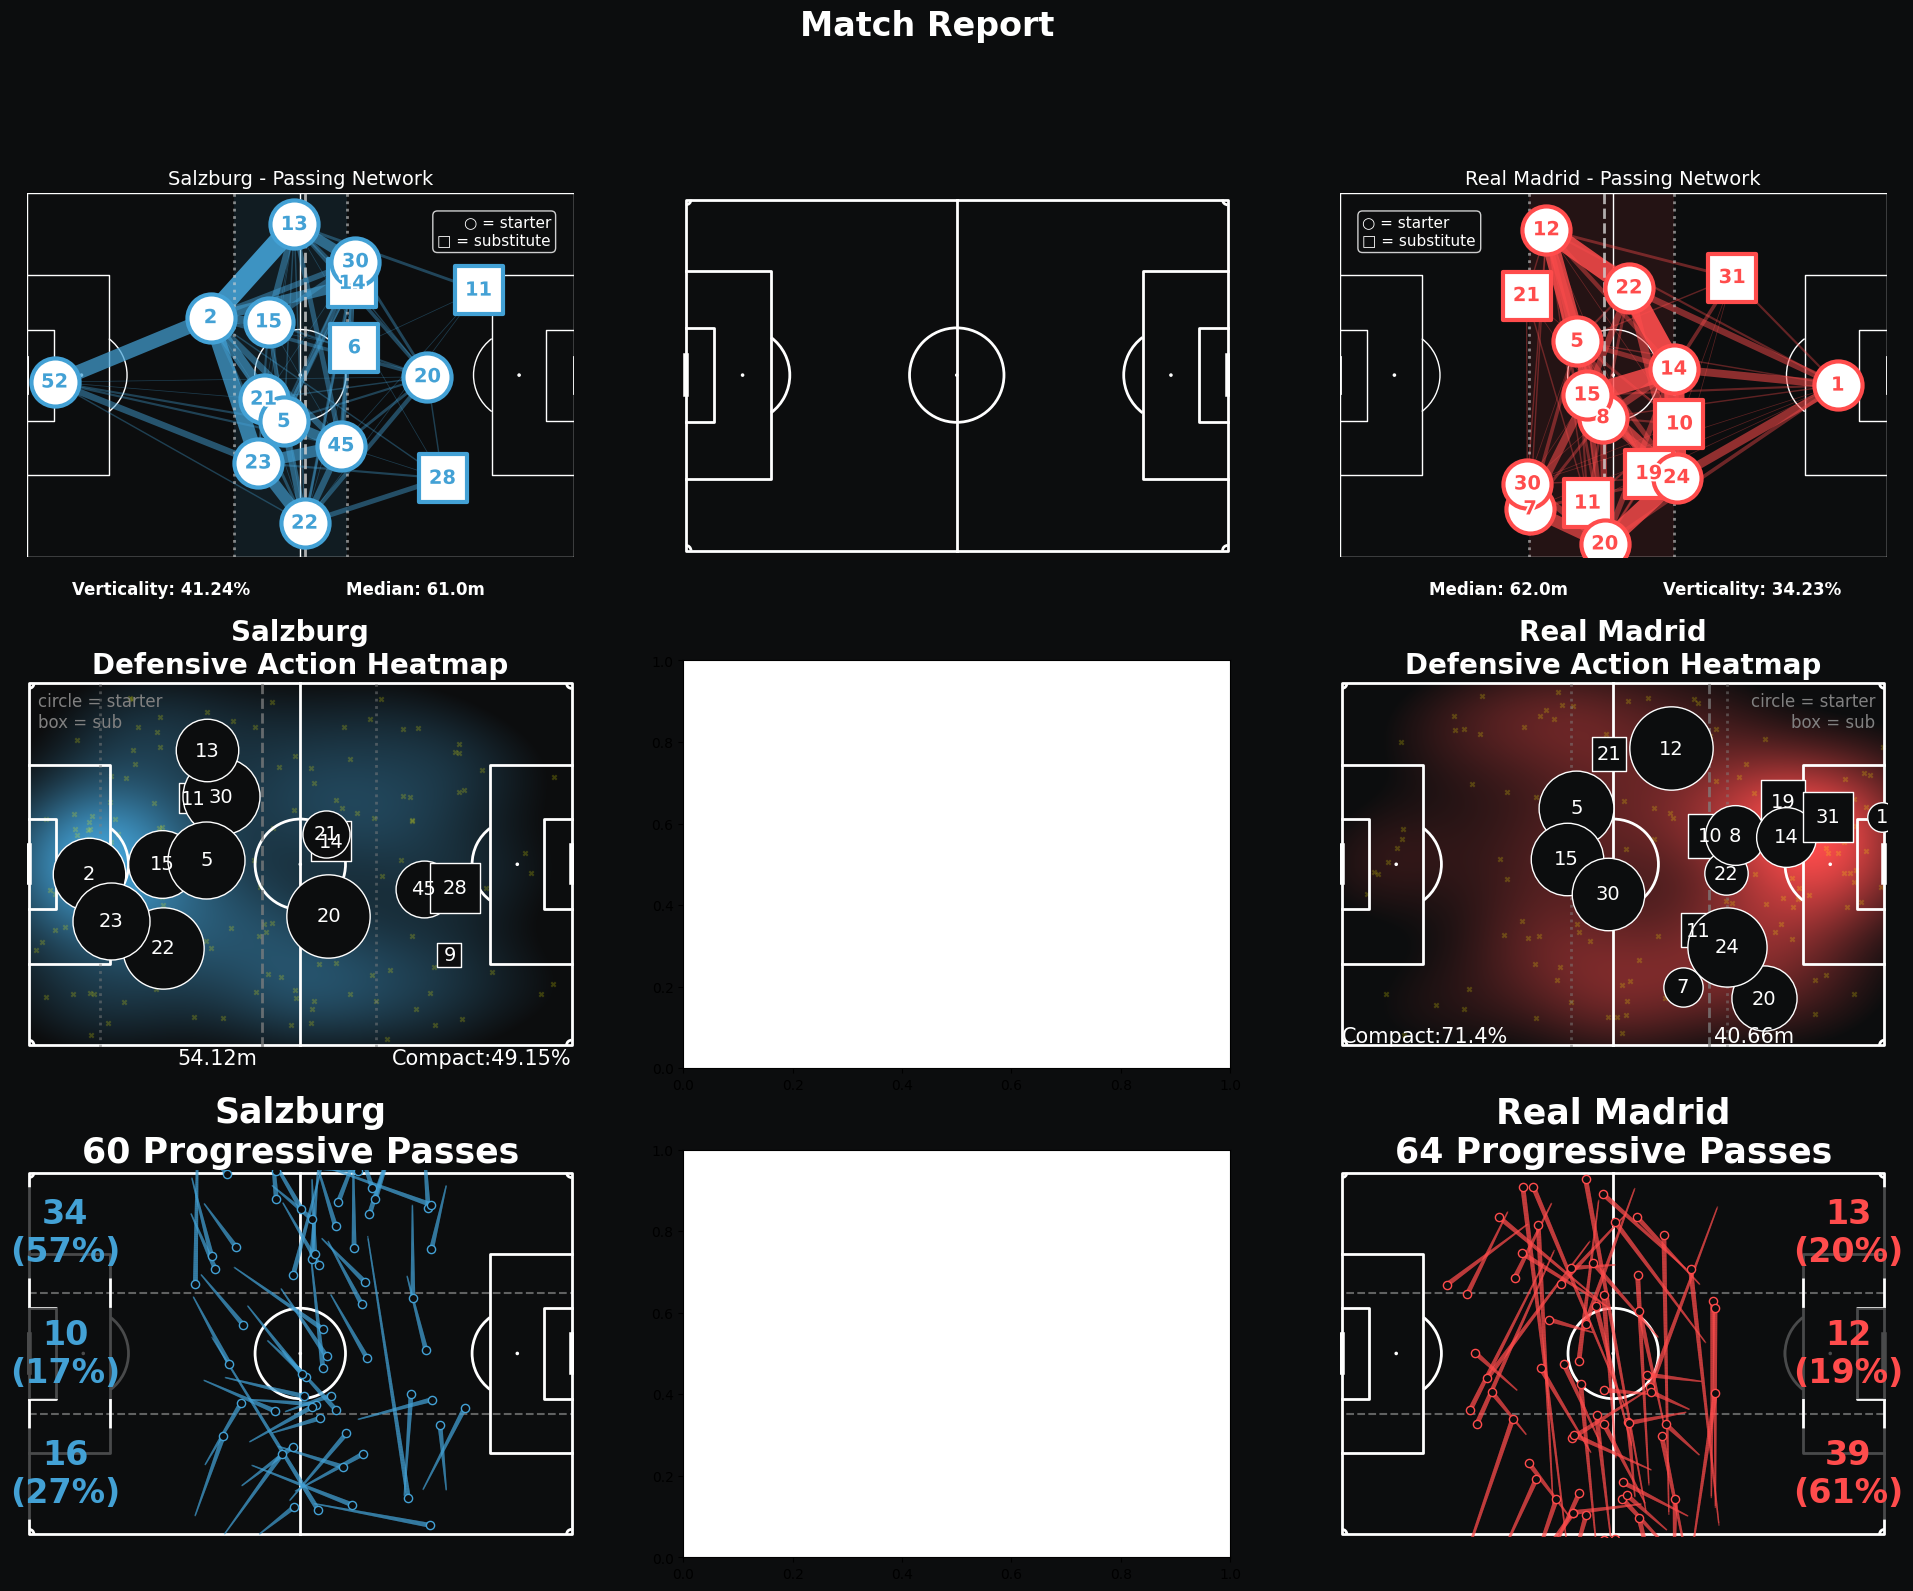

In [ ]:
# ==================== VERSIONES SUBPLOT-FRIENDLY CORREGIDAS ====================

def plot_shot_map_subplot(ax, shots_merged, home_stats, away_stats, home_fotmob_id, away_fotmob_id, home_team_name, away_team_name):
    """
    Shot map adaptado para subplot - USANDO TU METODOLOGÍA ORIGINAL
    """
    # Configurar pitch igual que tu original
    pitch = Pitch(pitch_type='uefa', pitch_color='#0C0D0E', line_color='white', linewidth=2, corner_arcs=True)
    pitch.draw(ax=ax)
    ax.set_ylim(-0.5, 68.5)
    ax.set_xlim(-0.5, 105.5)
    
    # Split shots by team - USANDO FOTMOB IDs CORRECTOS
    home_shots = shots_merged[shots_merged['team_id'] == home_fotmob_id]
    away_shots = shots_merged[shots_merged['team_id'] == away_fotmob_id]
    
    # TU HELPER FUNCTION ORIGINAL - ADAPTADA PARA SUBPLOT
    def plot_shots(df, color, is_home_team=True, marker='o', s=200, edgecolor=None, fill=True, hatch=None, zorder=2):
        if len(df) > 0:
            face_color = color if fill else 'none'
            edge_color = edgecolor if edgecolor else color
            
            # Transform coordinates based on team - TU SISTEMA ORIGINAL
            if is_home_team:
                # Home team (left side): flip coordinates
                x_coords = 105 - df['x']
                y_coords = 68 - df['y']
            else:
                # Away team (right side): use original coordinates
                x_coords = df['x']
                y_coords = df['y']
                
            ax.scatter(x_coords, y_coords, s=s, c=face_color, marker=marker, 
                      edgecolors=edge_color, zorder=zorder, hatch=hatch, linewidth=1.5)
    
    # --- HOME TEAM SHOTS (LEFT SIDE) - TU ESTÉTICA ORIGINAL ---
    home_color = "#085098"  # Salzburg blue
    
    # Goals (green football marker)
    home_goals = home_shots[(home_shots['eventType'] == 'Goal') & (~home_shots['is_own_goal'])]
    plot_shots(home_goals, 'none', is_home_team=True, marker='o', s=350, edgecolor='green', zorder=3)
    
    # Own goals (orange football marker)
    home_own_goals = home_shots[home_shots['is_own_goal']]
    plot_shots(home_own_goals, 'none', is_home_team=True, marker='o', s=350, edgecolor='orange', zorder=3)
    
    # Regular shots (not big chances)
    home_misses = home_shots[(home_shots['eventType'] == 'Miss') & (~home_shots['is_big_chance'])]
    plot_shots(home_misses, 'none', is_home_team=True, edgecolor=home_color, fill=False)
    
    home_saves = home_shots[(home_shots['eventType'] == 'AttemptSaved') & (~home_shots['is_big_chance'])]
    plot_shots(home_saves, 'none', is_home_team=True, edgecolor=home_color, fill=False, hatch='///////')
    
    home_posts = home_shots[(home_shots['eventType'] == 'Post') & (~home_shots['is_big_chance'])]
    plot_shots(home_posts, home_color, is_home_team=True, edgecolor=home_color)
    
    # Big chances (bigger markers)
    home_big_misses = home_shots[(home_shots['eventType'] == 'Miss') & (home_shots['is_big_chance'])]
    plot_shots(home_big_misses, 'none', is_home_team=True, edgecolor=home_color, fill=False, s=500)
    
    home_big_saves = home_shots[(home_shots['eventType'] == 'AttemptSaved') & (home_shots['is_big_chance'])]
    plot_shots(home_big_saves, 'none', is_home_team=True, edgecolor=home_color, fill=False, hatch='///////', s=500)
    
    home_big_posts = home_shots[(home_shots['eventType'] == 'Post') & (home_shots['is_big_chance'])]
    plot_shots(home_big_posts, home_color, is_home_team=True, edgecolor=home_color, s=500)
    
    home_big_goals = home_shots[(home_shots['eventType'] == 'Goal') & (home_shots['is_big_chance']) & (~home_shots['is_own_goal'])]
    plot_shots(home_big_goals, 'none', is_home_team=True, marker='o', s=650, edgecolor='green', zorder=3)
    
    # --- AWAY TEAM SHOTS (RIGHT SIDE) - TU ESTÉTICA ORIGINAL ---
    away_color = "#F13032"  # Real Madrid red
    
    # Goals (green football marker)
    away_goals = away_shots[(away_shots['eventType'] == 'Goal') & (~away_shots['is_own_goal'])]
    plot_shots(away_goals, 'none', is_home_team=False, marker='o', s=350, edgecolor='green', zorder=3)
    
    # Own goals (orange football marker)
    away_own_goals = away_shots[away_shots['is_own_goal']]
    plot_shots(away_own_goals, 'none', is_home_team=False, marker='o', s=350, edgecolor='orange', zorder=3)
    
    # Regular shots (not big chances)
    away_misses = away_shots[(away_shots['eventType'] == 'Miss') & (~away_shots['is_big_chance'])]
    plot_shots(away_misses, 'none', is_home_team=False, edgecolor=away_color, fill=False)
    
    away_saves = away_shots[(away_shots['eventType'] == 'AttemptSaved') & (~away_shots['is_big_chance'])]
    plot_shots(away_saves, 'none', is_home_team=False, edgecolor=away_color, fill=False, hatch='///////')
    
    away_posts = away_shots[(away_shots['eventType'] == 'Post') & (~away_shots['is_big_chance'])]
    plot_shots(away_posts, away_color, is_home_team=False, edgecolor=away_color)
    
    # Big chances (bigger markers)
    away_big_misses = away_shots[(away_shots['eventType'] == 'Miss') & (away_shots['is_big_chance'])]
    plot_shots(away_big_misses, 'none', is_home_team=False, edgecolor=away_color, fill=False, s=500)
    
    away_big_saves = away_shots[(away_shots['eventType'] == 'AttemptSaved') & (away_shots['is_big_chance'])]
    plot_shots(away_big_saves, 'none', is_home_team=False, edgecolor=away_color, fill=False, hatch='///////', s=500)
    
    away_big_posts = away_shots[(away_shots['eventType'] == 'Post') & (away_shots['is_big_chance'])]
    plot_shots(away_big_posts, away_color, is_home_team=False, edgecolor=away_color, s=500)
    
    away_big_goals = away_shots[(away_shots['eventType'] == 'Goal') & (away_shots['is_big_chance']) & (~away_shots['is_own_goal'])]
    plot_shots(away_big_goals, 'none', is_home_team=False, marker='o', s=650, edgecolor='green', zorder=3)
    
    # Stats - usando tu formato original con home_stats y away_stats lists
    home_goals_stat = home_stats[0]   # goals is index 0
    away_goals_stat = away_stats[0]   # goals is index 0  
    home_xg = home_stats[1]           # xg is index 1
    away_xg = away_stats[1]           # xg is index 1
    
    # Team names y direction indicators - IGUAL QUE TU ORIGINAL
    ax.text(0, 70, f"{home_team_name}\n<- Shots", color=home_color, size=16, ha='left', fontweight='bold')
    ax.text(105, 70, f"{away_team_name}\nShots ->", color=away_color, size=16, ha='right', fontweight='bold')
    
    # Remove axis
    ax.axis('off')

def plot_xt_momentum_subplot(ax, df_events, xT_grid, team_id_to_name, home_team_id, away_team_id):
    """xT Momentum adaptado para subplot"""
    ax.set_facecolor('#0C0D0E')
    
    try:
        # Lógica del cálculo de momentum (copiada de tu función)
        df = df_events.copy()
        df['x'] = df['x'] * 1.2
        df['y'] = df['y'] * 0.8
        df['end_x'] = df['end_x'] * 1.2
        df['end_y'] = df['end_y'] * 0.8

        n_rows, n_cols = xT_grid.shape
        
        # Filter for successful passes and carries
        mask = (
            df['type_display_name'].isin(['Pass', 'Carry']) &
            (df['outcome_type_display_name'] == 'Successful')
        )
        df_xT = df[mask].copy()

        if len(df_xT) == 0:
            ax.text(0.5, 0.5, 'No xT data available', transform=ax.transAxes, 
                   ha='center', va='center', color='white', fontsize=14)
            return

        # Bin locations
        def get_bin(val, max_val, n_bins):
            val = max(0, min(val, max_val))
            bin_idx = int(val / max_val * n_bins)
            return min(bin_idx, n_bins - 1)

        df_xT['start_x_bin'] = df_xT['x'].apply(lambda x: get_bin(x, 120, n_cols))
        df_xT['start_y_bin'] = df_xT['y'].apply(lambda y: get_bin(y, 80, n_rows))
        df_xT['end_x_bin'] = df_xT['end_x'].apply(lambda x: get_bin(x, 120, n_cols))
        df_xT['end_y_bin'] = df_xT['end_y'].apply(lambda y: get_bin(y, 80, n_rows))

        # Calculate xT
        df_xT['start_zone_value'] = df_xT.apply(lambda row: xT_grid[row['start_y_bin'], row['start_x_bin']], axis=1)
        df_xT['end_zone_value'] = df_xT.apply(lambda row: xT_grid[row['end_y_bin'], row['end_x_bin']], axis=1)
        df_xT['xT'] = df_xT['end_zone_value'] - df_xT['start_zone_value']
        df_xT['xT_clipped'] = np.clip(df_xT['xT'], 0, 0.1)
        df_xT['team'] = df_xT['team_id'].map(team_id_to_name)

        # Calculate momentum per minute
        max_xT_per_minute = df_xT.groupby(['team', 'minute'])['xT_clipped'].max().reset_index()
        minutes = sorted(max_xT_per_minute['minute'].unique())
        teams = [team_id_to_name[home_team_id], team_id_to_name[away_team_id]]
        
        if len(minutes) == 0:
            ax.text(0.5, 0.5, 'No momentum data', transform=ax.transAxes, 
                   ha='center', va='center', color='white', fontsize=14)
            return
        
        window_size = 4
        decay_rate = 0.25
        weighted_xT_sum = {team: [] for team in teams}
        momentum = []

        for current_minute in minutes:
            for team in teams:
                recent_xT = max_xT_per_minute[
                    (max_xT_per_minute['team'] == team) &
                    (max_xT_per_minute['minute'] <= current_minute) &
                    (max_xT_per_minute['minute'] > current_minute - window_size)
                ]
                weights = np.exp(-decay_rate * (current_minute - recent_xT['minute'].values))
                weighted_sum = np.sum(weights * recent_xT['xT_clipped'].values)
                weighted_xT_sum[team].append(weighted_sum)
            momentum.append(weighted_xT_sum[teams[0]][-1] - weighted_xT_sum[teams[1]][-1])

        # Smoothing y plotting
        momentum_smoothed = gaussian_filter1d(momentum, sigma=1.0)
        
        ax.plot(minutes, momentum_smoothed, color='white', linewidth=2)
        ax.axhline(0, color='white', linestyle='--', linewidth=1, alpha=0.7)
        ax.fill_between(minutes, momentum_smoothed, where=(np.array(momentum_smoothed) > 0), 
                       color='#43A1D5', alpha=0.5, interpolate=True)
        ax.fill_between(minutes, momentum_smoothed, where=(np.array(momentum_smoothed) < 0), 
                       color='#FF4C4C', alpha=0.5, interpolate=True)
        
        # Team names
        ax.text(2, 0.06, team_id_to_name[home_team_id], fontsize=12, ha='left', va='center', 
                color='#43A1D5', fontweight='bold')
        ax.text(2, -0.06, team_id_to_name[away_team_id], fontsize=12, ha='left', va='center', 
                color='#FF4C4C', fontweight='bold')
        
        # Styling
        ax.set_xlabel('Minute', color='white', fontsize=10, fontweight='bold')
        ax.set_title('xT Momentum', color='white', fontsize=12, fontweight='bold')
        ax.tick_params(colors='white')
        for spine in ax.spines.values():
            spine.set_color('white')
            
    except Exception as e:
        ax.text(0.5, 0.5, f'Error: {str(e)}', transform=ax.transAxes, 
               ha='center', va='center', color='white', fontsize=10)

def plot_match_stats_subplot(ax, stats, home_team_name, away_team_name):
    """Match stats adaptado para subplot"""
    ax.set_facecolor('#0C0D0E')
    ax.axis('off')
    
    # Stats principales - usando keys que sabemos que existen
    try:
        stat_keys = list(stats.keys())
        if len(stat_keys) == 0:
            ax.text(0.5, 0.5, 'No stats available', transform=ax.transAxes, 
                   ha='center', va='center', color='white', fontsize=14)
            return
            
        # Tomar primeros 5 stats
        categories = stat_keys
        y_positions = np.linspace(0.8, 0.2, len(categories))
        
        for i, category in enumerate(categories):
            stat_data = stats[category]
            home_val = stat_data.get('home', 0) if isinstance(stat_data, dict) else 0
            away_val = stat_data.get('away', 0) if isinstance(stat_data, dict) else 0
            
            # Normalizar valores para barras
            total = home_val + away_val
            if total > 0:
                home_width = (home_val / total) * 0.35
                away_width = (away_val / total) * 0.35
            else:
                home_width = away_width = 0.1
            
            # Home bar (izquierda)
            ax.barh(y_positions[i], home_width, left=0.5-home_width, height=0.05, 
                    color='#43A1D5', alpha=0.8)
            # Away bar (derecha)  
            ax.barh(y_positions[i], away_width, left=0.5, height=0.05, 
                    color='#FF4C4C', alpha=0.8)
            
            # Textos
            ax.text(0.25, y_positions[i], f'{home_val}', ha='center', va='center', 
                    color='white', fontsize=10, weight='bold')
            ax.text(0.75, y_positions[i], f'{away_val}', ha='center', va='center', 
                    color='white', fontsize=10, weight='bold')
            ax.text(0.5, y_positions[i], category, ha='center', va='center', 
                    color='white', fontsize=8, weight='bold')
        
        # Títulos de equipos
        ax.text(0.25, 0.95, home_team_name, ha='center', va='center', 
                color='#43A1D5', fontsize=12, weight='bold')
        ax.text(0.75, 0.95, away_team_name, ha='center', va='center', 
                color='#FF4C4C', fontsize=12, weight='bold')
        
    except Exception as e:
        ax.text(0.5, 0.5, f'Stats error: {str(e)}', transform=ax.transAxes, 
               ha='center', va='center', color='white', fontsize=10)
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

# ==================== DUAL ID SYSTEM - SOLUCIÓN COMPLETA ====================

# WhoScored/Opta IDs (para events, passing, defensive actions, etc.)
home_team_id = home_team['team_id']  # WhoScored ID: 361
away_team_id = away_team['team_id']  # WhoScored ID: 52

# Fotmob IDs (SOLO para shot map)
home_fotmob_id = 10013  # Salzburg en Fotmob
away_fotmob_id = 8633   # Real Madrid en Fotmob

# Team names (iguales para ambas fuentes)
home_team_name = home_team['name'] 
away_team_name = away_team['name']

print(f"✅ WhoScored IDs: Home={home_team_id} ({home_team_name}), Away={away_team_id} ({away_team_name})")
print(f"✅ Fotmob IDs: Home={home_fotmob_id}, Away={away_fotmob_id}")

# ==================== CREAR DASHBOARD COMPLETO ====================

# Setup del dashboard
fig, axs = plt.subplots(3, 3, figsize=(24, 18), facecolor='#0C0D0E')
fig.suptitle('Match Report', fontsize=24, color='white', weight='bold', y=0.97)

# FILA 1: Passing Networks (MANTENER TODO LO QUE YA FUNCIONA)
plot_enhanced_network(axs[0,0], passes_df, home_avg_locs, home_combinations, home_metrics,
                     home_team_name, color='#43A1D5', is_home=True, bg_color='#0C0D0E')

plot_enhanced_network(axs[0,2], passes_df, away_avg_locs, away_combinations, away_metrics,
                     away_team_name, color='#FF4C4C', is_home=False, bg_color='#0C0D0E')

# FILA 2: Defensive Actions (MANTENER TODO LO QUE YA FUNCIONA)
defensive_block(axs[1,0], home_positions, home_actions, 
               home_team_name, '#43A1D5', is_away_team=False)
defensive_block(axs[1,2], away_positions, away_actions, 
               away_team_name, '#FF4C4C', is_away_team=True)

# FILA 3: Progressive Passes (MANTENER TODO LO QUE YA FUNCIONA)
draw_progressive_pass_map(axs[2,0], home_team_id, home_team_name, '#43A1D5', is_away_team=False)
draw_progressive_pass_map(axs[2,2], away_team_id, away_team_name, '#FF4C4C', is_away_team=True)

# COLUMNA CENTRAL: Shot Map (NUEVA VERSIÓN CON TU METODOLOGÍA), Momentum, Match Stats
plot_shot_map_subplot(axs[0,1], shots_merged, home_stats, away_stats, 
                     home_fotmob_id, away_fotmob_id, home_team_name, away_team_name)

plot_xt_momentum_subplot(axs[1,1], df_events, xT_grid, team_id_to_name, 
                        home_team_id, away_team_id)

plot_match_stats_subplot(axs[2,1], stats, home_team_name, away_team_name)

# Ajustar spacing
plt.tight_layout()
plt.subplots_adjust(top=0.94, hspace=0.3, wspace=0.2)
plt.show()

#### Experiment 6


In [27]:
# ==================== DATA PREPARATION FOR DASHBOARD ====================

print("=== PREPARING DASHBOARD DATA ===")

# 1. Standardize data structure and column naming
if 'teamId' in shots_merged.columns and 'team_id' not in shots_merged.columns:
    shots_merged = shots_merged.rename(columns={'teamId': 'team_id'})

# 2. Extract team information dynamically
home_team_id = home_team['team_id']  # WhoScored ID for events/passes
away_team_id = away_team['team_id']  # WhoScored ID for events/passes
home_team_name = home_team['name']
away_team_name = away_team['name']

# 3. Dual ID system for different data sources
home_fotmob_id = 10013  # Fotmob ID for shots (Salzburg)
away_fotmob_id = 8633   # Fotmob ID for shots (Real Madrid)

# 4. Prepare defensive actions data
defensive_actions = filter_defensive_actions(df_events)
home_positions = calculate_player_defensive_positions(
    defensive_actions, home_team_id, home_team['players']
)
away_positions = calculate_player_defensive_positions(
    defensive_actions, away_team_id, away_team['players']
)
home_actions = defensive_actions[defensive_actions['team_id'] == home_team_id]
away_actions = defensive_actions[defensive_actions['team_id'] == away_team_id]

print(f"✅ Teams: {home_team_name} vs {away_team_name}")
print(f"✅ Defensive data: {len(home_positions)} vs {len(away_positions)} players")
print(f"✅ Shot data: {len(shots_merged)} total shots")
print("=== DATA PREPARATION COMPLETE ===\n")

=== PREPARING DASHBOARD DATA ===
✅ Teams: Salzburg vs Real Madrid
✅ Defensive data: 14 vs 16 players
✅ Shot data: 24 total shots
=== DATA PREPARATION COMPLETE ===



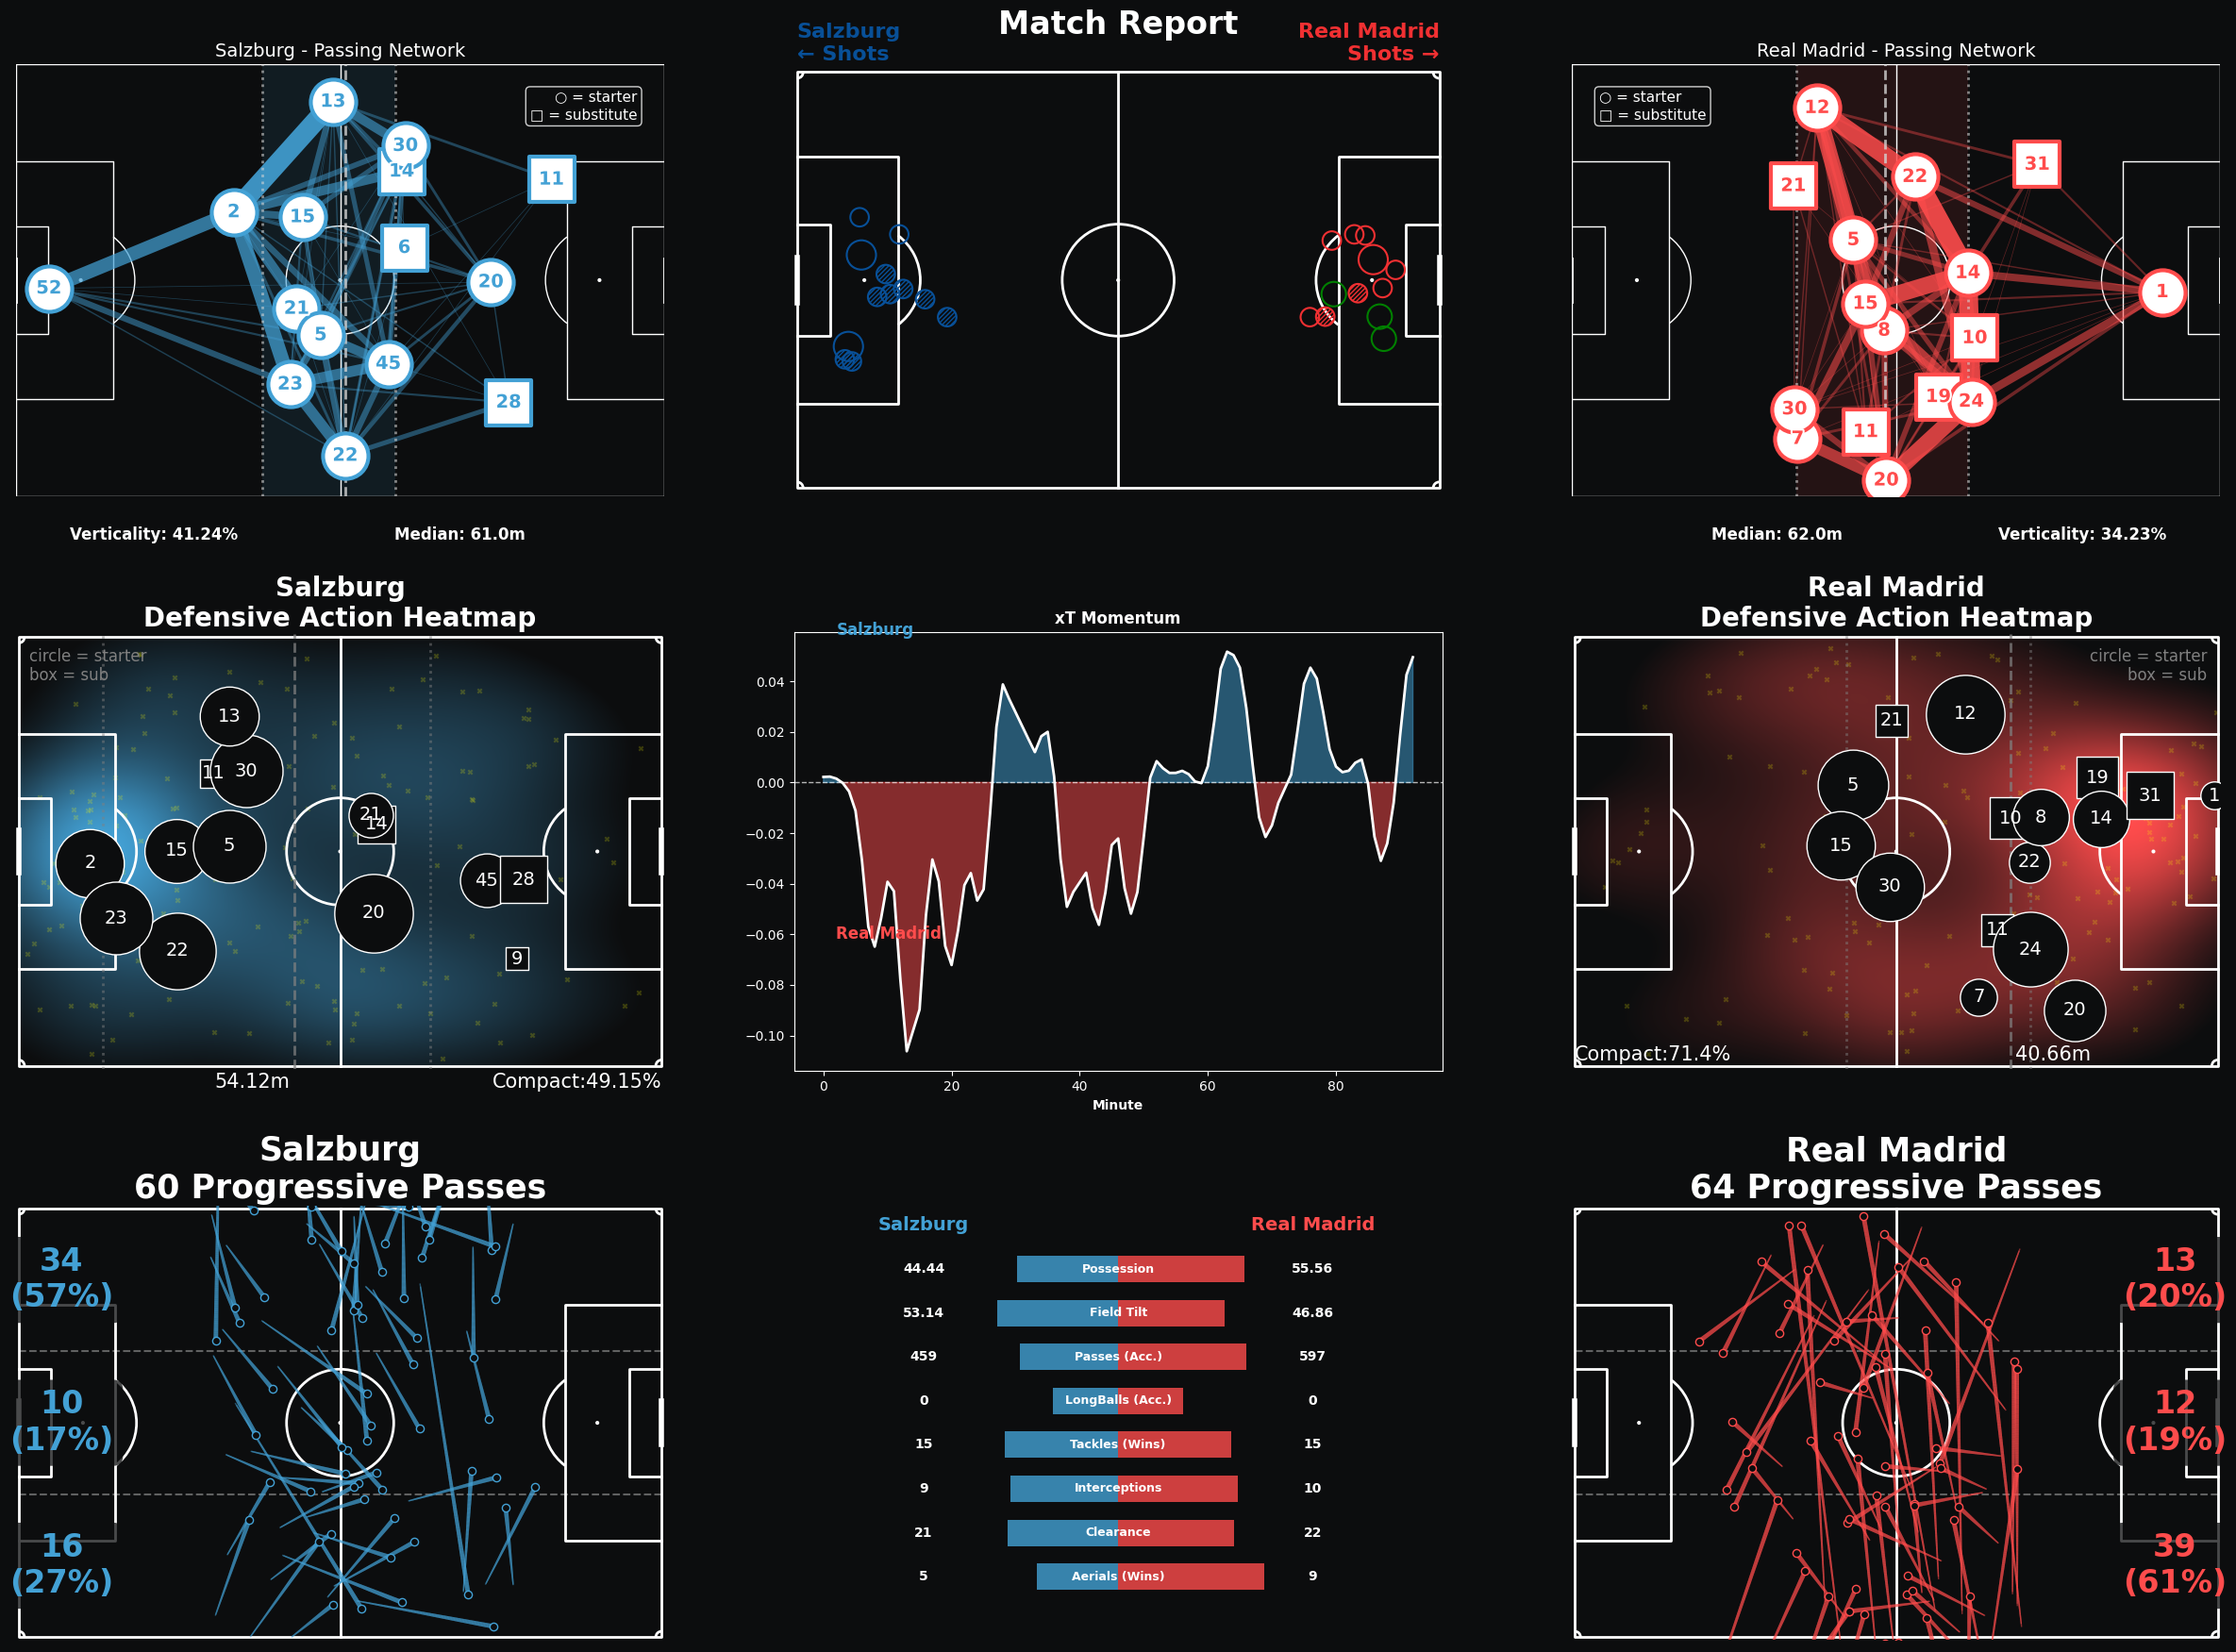

In [28]:
# ==================== SUBPLOT-OPTIMIZED VISUALIZATION FUNCTIONS ====================

def plot_shot_map_subplot(ax, shots_merged, home_stats, away_stats, home_fotmob_id, away_fotmob_id, home_team_name, away_team_name):
    """Advanced shot map with comprehensive shot type visualization"""
    pitch = Pitch(pitch_type='uefa', pitch_color='#0C0D0E', line_color='white', linewidth=2, corner_arcs=True)
    pitch.draw(ax=ax)
    ax.set_ylim(-0.5, 68.5)
    ax.set_xlim(-0.5, 105.5)
    
    # Filter shots by team using Fotmob IDs
    home_shots = shots_merged[shots_merged['team_id'] == home_fotmob_id]
    away_shots = shots_merged[shots_merged['team_id'] == away_fotmob_id]
    
    def plot_shots(df, color, is_home_team=True, marker='o', s=200, edgecolor=None, fill=True, hatch=None, zorder=2):
        if len(df) > 0:
            face_color = color if fill else 'none'
            edge_color = edgecolor if edgecolor else color
            
            # Transform coordinates for proper positioning
            if is_home_team:
                x_coords = 105 - df['x']  # Home team shoots left to right
                y_coords = 68 - df['y']
            else:
                x_coords = df['x']        # Away team shoots right to left
                y_coords = df['y']
                
            ax.scatter(x_coords, y_coords, s=s, c=face_color, marker=marker, 
                      edgecolors=edge_color, zorder=zorder, hatch=hatch, linewidth=1.5)
    
    # Team colors matching dashboard theme
    home_color, away_color = "#085098", "#F13032"
    
    # Home team shots (left side)
    home_goals = home_shots[(home_shots['eventType'] == 'Goal') & (~home_shots['is_own_goal'])]
    plot_shots(home_goals, 'none', True, 'o', 350, 'green', zorder=3)
    
    home_misses = home_shots[(home_shots['eventType'] == 'Miss') & (~home_shots['is_big_chance'])]
    plot_shots(home_misses, 'none', True, edgecolor=home_color, fill=False)
    
    home_saves = home_shots[(home_shots['eventType'] == 'AttemptSaved') & (~home_shots['is_big_chance'])]
    plot_shots(home_saves, 'none', True, edgecolor=home_color, fill=False, hatch='///////')
    
    home_big_chances = home_shots[(home_shots['is_big_chance']) & (home_shots['eventType'] != 'Goal')]
    plot_shots(home_big_chances, 'none', True, edgecolor=home_color, fill=False, s=500)
    
    # Away team shots (right side)
    away_goals = away_shots[(away_shots['eventType'] == 'Goal') & (~away_shots['is_own_goal'])]
    plot_shots(away_goals, 'none', False, 'o', 350, 'green', zorder=3)
    
    away_misses = away_shots[(away_shots['eventType'] == 'Miss') & (~away_shots['is_big_chance'])]
    plot_shots(away_misses, 'none', False, edgecolor=away_color, fill=False)
    
    away_saves = away_shots[(away_shots['eventType'] == 'AttemptSaved') & (~away_shots['is_big_chance'])]
    plot_shots(away_saves, 'none', False, edgecolor=away_color, fill=False, hatch='///////')
    
    away_big_chances = away_shots[(away_shots['is_big_chance']) & (away_shots['eventType'] != 'Goal')]
    plot_shots(away_big_chances, 'none', False, edgecolor=away_color, fill=False, s=500)
    
    # Team labels and shooting direction
    ax.text(0, 70, f"{home_team_name}\n← Shots", color=home_color, size=16, ha='left', fontweight='bold')
    ax.text(105, 70, f"{away_team_name}\nShots →", color=away_color, size=16, ha='right', fontweight='bold')
    
    ax.axis('off')

def plot_xt_momentum_subplot(ax, df_events, xT_grid, team_id_to_name, home_team_id, away_team_id):
    """Match momentum visualization using Expected Threat"""
    ax.set_facecolor('#0C0D0E')
    
    try:
        # Scale coordinates for xT grid
        df = df_events.copy()
        df['x'] = df['x'] * 1.2
        df['y'] = df['y'] * 0.8
        df['end_x'] = df['end_x'] * 1.2
        df['end_y'] = df['end_y'] * 0.8
        
        # Filter successful passes and carries
        df_xT = df[
            (df['type_display_name'].isin(['Pass', 'Carry'])) &
            (df['outcome_type_display_name'] == 'Successful')
        ].copy()
        
        if len(df_xT) == 0:
            ax.text(0.5, 0.5, 'No xT data available', transform=ax.transAxes, 
                   ha='center', va='center', color='white', fontsize=14)
            return
        
        # Calculate xT values
        n_rows, n_cols = xT_grid.shape
        
        def get_bin(val, max_val, n_bins):
            val = max(0, min(val, max_val))
            return min(int(val / max_val * n_bins), n_bins - 1)
        
        df_xT['start_x_bin'] = df_xT['x'].apply(lambda x: get_bin(x, 120, n_cols))
        df_xT['start_y_bin'] = df_xT['y'].apply(lambda y: get_bin(y, 80, n_rows))
        df_xT['end_x_bin'] = df_xT['end_x'].apply(lambda x: get_bin(x, 120, n_cols))
        df_xT['end_y_bin'] = df_xT['end_y'].apply(lambda y: get_bin(y, 80, n_rows))
        
        df_xT['start_zone_value'] = df_xT.apply(lambda row: xT_grid[row['start_y_bin'], row['start_x_bin']], axis=1)
        df_xT['end_zone_value'] = df_xT.apply(lambda row: xT_grid[row['end_y_bin'], row['end_x_bin']], axis=1)
        df_xT['xT'] = df_xT['end_zone_value'] - df_xT['start_zone_value']
        df_xT['xT_clipped'] = np.clip(df_xT['xT'], 0, 0.1)
        df_xT['team'] = df_xT['team_id'].map(team_id_to_name)
        
        # Calculate momentum per minute
        max_xT_per_minute = df_xT.groupby(['team', 'minute'])['xT_clipped'].max().reset_index()
        minutes = sorted(max_xT_per_minute['minute'].unique())
        teams = [team_id_to_name[home_team_id], team_id_to_name[away_team_id]]
        
        if len(minutes) == 0:
            ax.text(0.5, 0.5, 'No momentum data', transform=ax.transAxes, 
                   ha='center', va='center', color='white', fontsize=14)
            return
        
        # Calculate weighted momentum
        window_size, decay_rate = 4, 0.25
        weighted_xT_sum = {team: [] for team in teams}
        momentum = []
        
        for current_minute in minutes:
            for team in teams:
                recent_xT = max_xT_per_minute[
                    (max_xT_per_minute['team'] == team) &
                    (max_xT_per_minute['minute'] <= current_minute) &
                    (max_xT_per_minute['minute'] > current_minute - window_size)
                ]
                weights = np.exp(-decay_rate * (current_minute - recent_xT['minute'].values))
                weighted_sum = np.sum(weights * recent_xT['xT_clipped'].values)
                weighted_xT_sum[team].append(weighted_sum)
            momentum.append(weighted_xT_sum[teams[0]][-1] - weighted_xT_sum[teams[1]][-1])
        
        # Plot momentum with smoothing
        momentum_smoothed = gaussian_filter1d(momentum, sigma=1.0)
        ax.plot(minutes, momentum_smoothed, color='white', linewidth=2)
        ax.axhline(0, color='white', linestyle='--', linewidth=1, alpha=0.7)
        ax.fill_between(minutes, momentum_smoothed, where=(np.array(momentum_smoothed) > 0), 
                       color='#43A1D5', alpha=0.5, interpolate=True)
        ax.fill_between(minutes, momentum_smoothed, where=(np.array(momentum_smoothed) < 0), 
                       color='#FF4C4C', alpha=0.5, interpolate=True)
        
        # Team labels
        ax.text(2, 0.06, team_id_to_name[home_team_id], fontsize=12, ha='left', va='center', 
                color='#43A1D5', fontweight='bold')
        ax.text(2, -0.06, team_id_to_name[away_team_id], fontsize=12, ha='left', va='center', 
                color='#FF4C4C', fontweight='bold')
        
        # Styling
        ax.set_xlabel('Minute', color='white', fontsize=10, fontweight='bold')
        ax.set_title('xT Momentum', color='white', fontsize=12, fontweight='bold')
        ax.tick_params(colors='white')
        for spine in ax.spines.values():
            spine.set_color('white')
            
    except Exception as e:
        ax.text(0.5, 0.5, f'Error calculating momentum', transform=ax.transAxes, 
               ha='center', va='center', color='white', fontsize=10)

def plot_match_stats_subplot(ax, stats, home_team_name, away_team_name):
    """Comprehensive match statistics comparison"""
    ax.set_facecolor('#0C0D0E')
    ax.axis('off')
    
    try:
        stat_keys = list(stats.keys())
        if len(stat_keys) == 0:
            ax.text(0.5, 0.5, 'No stats available', transform=ax.transAxes, 
                   ha='center', va='center', color='white', fontsize=14)
            return
        
        # Display key statistics
        categories = stat_keys[:8]  # Show top 8 stats
        y_positions = np.linspace(0.85, 0.15, len(categories))
        
        for i, category in enumerate(categories):
            stat_data = stats[category]
            home_val = stat_data.get('home', 0) if isinstance(stat_data, dict) else 0
            away_val = stat_data.get('away', 0) if isinstance(stat_data, dict) else 0
            
            # Normalize for bar visualization
            total = home_val + away_val
            if total > 0:
                home_width = (home_val / total) * 0.35
                away_width = (away_val / total) * 0.35
            else:
                home_width = away_width = 0.1
            
            # Draw comparison bars
            ax.barh(y_positions[i], home_width, left=0.5-home_width, height=0.06, 
                    color='#43A1D5', alpha=0.8)
            ax.barh(y_positions[i], away_width, left=0.5, height=0.06, 
                    color='#FF4C4C', alpha=0.8)
            
            # Add values and labels
            ax.text(0.2, y_positions[i], f'{home_val}', ha='center', va='center', 
                    color='white', fontsize=10, weight='bold')
            ax.text(0.8, y_positions[i], f'{away_val}', ha='center', va='center', 
                    color='white', fontsize=10, weight='bold')
            ax.text(0.5, y_positions[i], category, ha='center', va='center', 
                    color='white', fontsize=9, weight='bold')
        
        # Team headers
        ax.text(0.2, 0.95, home_team_name, ha='center', va='center', 
                color='#43A1D5', fontsize=14, weight='bold')
        ax.text(0.8, 0.95, away_team_name, ha='center', va='center', 
                color='#FF4C4C', fontsize=14, weight='bold')
        
    except Exception as e:
        ax.text(0.5, 0.5, f'Stats unavailable', transform=ax.transAxes, 
               ha='center', va='center', color='white', fontsize=10)
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

# ==================== PROFESSIONAL MATCH DASHBOARD ====================

# Create dashboard layout
fig, axs = plt.subplots(3, 3, figsize=(24, 18), facecolor='#0C0D0E')
fig.suptitle('Match Report', fontsize=24, color='white', weight='bold', y=0.97)

# Row 1: Passing Networks + Shot Map
plot_enhanced_network(axs[0,0], passes_df, home_avg_locs, home_combinations, home_metrics,
                     home_team_name, color='#43A1D5', is_home=True, bg_color='#0C0D0E')

plot_shot_map_subplot(axs[0,1], shots_merged, home_stats, away_stats, 
                     home_fotmob_id, away_fotmob_id, home_team_name, away_team_name)

plot_enhanced_network(axs[0,2], passes_df, away_avg_locs, away_combinations, away_metrics,
                     away_team_name, color='#FF4C4C', is_home=False, bg_color='#0C0D0E')

# Row 2: Defensive Actions + xT Momentum
defensive_block(axs[1,0], home_positions, home_actions, 
               home_team_name, '#43A1D5', is_away_team=False)

plot_xt_momentum_subplot(axs[1,1], df_events, xT_grid, team_id_to_name, 
                        home_team_id, away_team_id)

defensive_block(axs[1,2], away_positions, away_actions, 
               away_team_name, '#FF4C4C', is_away_team=True)

# Row 3: Progressive Passes + Match Statistics
draw_progressive_pass_map(axs[2,0], home_team_id, home_team_name, '#43A1D5', is_away_team=False)

plot_match_stats_subplot(axs[2,1], stats, home_team_name, away_team_name)

draw_progressive_pass_map(axs[2,2], away_team_id, away_team_name, '#FF4C4C', is_away_team=True)

# Final layout adjustments
plt.tight_layout()
plt.subplots_adjust(top=0.94, hspace=0.3, wspace=0.2)
plt.show()